# Source Finding Test Case – SRCNET v0.1
---

**Test name:** SWF-010-T1 – Radio continuum source finding with PyBDSF

**Author:** Lara Alegre and Teal team 

**Documentation on confluence:** https://confluence.skatelescope.org/x/5pUSEw

**Summary:** This notebook serves as a test case for evaluating the source-finding using **PyBDSF** on a real-world radio continuum dataset from the **LoTSS** survey. The goal is to extract and visualise radio sources from a single-frequency 2D mosaic using PyBDSF’s Gaussian decomposition approach.

---

### Data:
We use a small-area FITS mosaic from **LoTSS-DR2**, publicly available via the [LOFAR Surveys website](https://lofar-surveys.org/releases.html). The image has a resolution of ~6 arcsec and includes typical survey noise and structure.


### In this test we perform:

- FITS header inspection
- Radio source detection:
  - Background estimation
  - RMS noise map creation
  - Island detection and Gaussian fitting
- Extraction of source and Gaussian component parameters (position, flux, shape, ect)
- Overlay of source positions on the original radio image
- Basic output validation through visual inspection by confirming source positions match radio emission regions that must the same as showed on the plot in the confluence page


### Expected outputs:
- Catalogues that contain information about the sources and the Gaussians (not exported to file currently)
- Each source and Gaussian contain basic information such as
  - RA, Dec
  - Peak and total flux
  - Source size and shape (major, minor axis, position angle)
  
### Outputs for validation: 
- Plot showing detected sources overlapping the radio maps

---

In [1]:
# Imports 
import os
import yaml
import warnings
import bdsf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ZScaleInterval, AsinhStretch, SqrtStretch

In [4]:
# Paths 

config_file = "../config/config.yml"

default_base_path = "../datasets"
default_result_path = "../results"

if os.path.exists(config_file):
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
else:
    warnings.warn(f"! Configuration file '{config_file}' not found. Using default settings.", UserWarning)
    config = {}

base_path = config.get("data_path")
if base_path is None:
    warnings.warn(f"! 'data_path' not found in '{config_file}'. Using default path '{default_base_path}'.", UserWarning)
    base_path = default_base_path

result_path = config.get("result_path")
if result_path is None:
    warnings.warn(f"! 'result_path' not found in '{config_file}'. Using default: '{default_result_path}'.", UserWarning)
    result_path = default_result_path

result_path += "/SWF-010-T1"

# Path to the folders and FITS file (inside the container in this case)
fits_path = base_path + '/P020_39-mosaic-blanked.fits'
# Path to the output directory
output_dir = result_path + '/interim'
# Path to results
results_dir = result_path

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
# Run PyBDSF

# Process the patched file with PyBDSF (this takes a about 5 minutes) 
# Got parameters from https://github.com/mhardcastle/ddf-pipeline/blob/5d11d5ec212da29826433fed44bab329c037855e/scripts/sourcefind.py

# define frequency since the FITS file does not have frequency information and it is needed to run PyBDSF
restfrq=143650000.0 #144000000.0

img = bdsf.process_image(fits_path, thresh_isl=3.0, thresh_pix=5, rms_box=(150,15), rms_map=True, mean_map='zero', ini_method='intensity', adaptive_rms_box=True, adaptive_thresh=150, rms_box_bright=(60,15), group_by_isl=False, group_tol=10.0, output_opts=True, output_all=False, atrous_do=True, atrous_jmax=4, flagging_opts=True, flag_maxsize_fwhm=0.5, advanced_opts=True, blank_limit=None, frequency=restfrq)

# Confirm success without matplotlib
print("Image shape:", img.ch0_arr.shape)
print("Beam:", img.beam)

--> Opened '../../teal/P020_39-mosaic-blanked.fits'
Image size .............................. : (8350, 8350) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (1.66667e-03, 1.66667e-03, 90) degrees
Frequency of image ...................... : 143.650 MHz
Number of blank pixels .................. : 15384119 (22.1%)
Flux from sum of (non-blank) pixels ..... : 66.468 Jy
--> Calculating background rms and mean images
--> Using adaptive scaling of rms_box
Using user-specified rms_box ............ : (60, 15) pixels (small scale)
Using user-specified rms_box ............ : (150, 15) pixels (large scale)
Number of sources using small scale ..... : 184
--> Using 2D map for background rms
--> Using constant background mean
Min/max values of background rms map .... : (7.47e-05, 9.07e-03) Jy/beam
Value of background mean ................ : 0.0 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_

Fitting islands with Gaussians .......... : [|] 0/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/4993

stty: 'standard input': Inappropriate ioctl for device


--

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [-] 2/4993Fitting islands with Gaussians .......... : [-] 2/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 3/4993Fitting islands with Gaussians .......... : [\] 3/4993

stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 5/4993Fitting islands with Gaussians .......... : [/] 5/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

|||Fitting islands with Gaussians .......... : [\] 7/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 7/4993Fitting islands with Gaussians .......... : [|] 8/4993---Fitting islands with Gaussians .......... : [|] 8/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 10/4993||||Fitting islands with Gaussians .......... : [-] 10/4993Fitting islands with Gaussians .......... : [-] 10/4993Fitting islands with Gaussians .......... : [-] 10/4993Fitting islands with Gaussians .......... : [|] 12/4993|||||Fitting islands with Gaussians .......... : [|] 12/4993Fitting islands with Gaussians .......... : [|] 12/4993Fitting islands with Gaussians .......... : [|] 12/4993\\\\\Fitting islands with Gaussians .......... : [|] 16/4993Fitting islands with Gaussians .......... : [|] 16/4993Fitting islands with Gaussians .......... : [|] 16/4993Fitting islands with Gaussians .......... : [|] 16/4993Fitting islands with Gaussians .......... : [|] 16/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 18/4993Fitting islands with Gaussians .......... : [\] 18/4993Fitting islands with Gaussians .......... : [\] 18/4993Fitting islands with Gaussians .......... : [\] 18/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 18/4993-\|\|///Fitting islands with Gaussians .......... : [\] 18/4993|Fitting islands with Gaussians .......... : [\] 18/4993

stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 24/4993Fitting islands with Gaussians .......... : [\] 23/4993Fitting islands with Gaussians .......... : [|] 25/4993/Fitting islands with Gaussians .......... : [-] 23/4993/--Fitting islands with Gaussians .......... : [/] 25/4993Fitting islands with Gaussians .......... : [\] 23/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 25/4993\-Fitting islands with Gaussians .......... : [|] 28/4993Fitting islands with Gaussians .......... : [/] 25/4993|//Fitting islands with Gaussians .......... : [/] 29/4993Fitting islands with Gaussians .......... : [/] 30/4993

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 31/4993Fitting islands with Gaussians .......... : [-] 30/4993Fitting islands with Gaussians .......... : [-] 30/4993Fitting islands with Gaussians .......... : [-] 30/4993\Fitting islands with Gaussians .......... : [|] 32/4993//--||||||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 33/4993Fitting islands with Gaussians .......... : [/] 33/4993Fitting islands with Gaussians .......... : [\] 35/4993Fitting islands with Gaussians .......... : [-] 39/4993Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [-] 38/4993||||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

||Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [/] 37/4993Fitting islands with Gaussians .......... : [|] 39/4993Fitting islands with Gaussians .......... : [/] 37/4993

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 43/4993Fitting islands with Gaussians .......... : [|] 43/4993///\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\\-\\Fitting islands with Gaussians .......... : [|] 43/4993Fitting islands with Gaussians .......... : [|] 43/4993Fitting islands with Gaussians .......... : [|] 43/4993Fitting islands with Gaussians .......... : [|] 43/4993Fitting islands with Gaussians .......... : [/] 49/4993Fitting islands with Gaussians .......... : [/] 48/4993Fitting islands with Gaussians .......... : [/] 49/4993--Fitting islands with Gaussians .......... : [\] 50/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

Fitting islands with Gaussians .......... : [\] 50/4993\||||Fitting islands with Gaussians .......... : [\] 50/4993Fitting islands with Gaussians .......... : [-] 49/4993Fitting islands with Gaussians .......... : [\] 50/4993Fitting islands with Gaussians .......... : [\] 50/4993Fitting islands with Gaussians .......... : [\] 50/4993Fitting islands with Gaussians .......... : [\] 50/4993//Fitting islands with Gaussians .......... : [-] 53/4993Fitting islands with Gaussians .......... : [|] 54/4993

'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 54/4993Fitting islands with Gaussians .......... : [-] 53/4993Fitting islands with Gaussians .......... : [|] 54/4993\\\\\\\\\\Fitting islands with Gaussians .......... : [|] 54/4993Fitting islands with Gaussians .......... : [|] 54/4993Fitting islands with Gaussians .......... : [/] 55/4993Fitting islands with Gaussians .......... : [/] 55/4993Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993/-\||||||Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [\] 63/4993Fitting islands with Gaussians .......... : [-] 69/4993Fitting islands with Gaussians .......... : [|] 70/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 70/4993Fitting islands with Gaussians .......... : [|] 70/4993Fitting islands with Gaussians .......... : [\] 69/4993Fitting islands with Gaussians .......... : [/] 67/4993Fitting islands with Gaussians .......... : [|] 70/4993-\|/////////Fitting islands with Gaussians .......... : [|] 70/4993/Fitting islands with Gaussians .......... : [|] 70/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [\] 75/4993Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [|] 76/4993Fitting islands with Gaussians .......... : [-] 75/4993/Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [/] 76/4993/Fitting islands with Gaussians .......... : [/] 76/4993---\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 77/4993Fitting islands with Gaussians .......... : [/] 76/4993Fitting islands with Gaussians .......... : [\] 78/4993Fitting islands with Gaussians .......... : [\] 78/4993Fitting islands with Gaussians .......... : [/] 80/4993Fitting islands with Gaussians .......... : [/] 80/4993\|||||||///|//Fitting islands with Gaussians .......... : [-] 81/4993|Fitting islands with Gaussians .......... : [\] 82/4993/Fitting islands with Gaussians .......... : [-] 82/4993Fitting islands with Gaussians .......... : [-] 81/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 82/4993Fitting islands with Gaussians .......... : [|] 91/4993Fitting islands with Gaussians .......... : [/] 91/4993Fitting islands with Gaussians .......... : [/] 91/4993Fitting islands with Gaussians .......... : [|] 94/4993Fitting islands with Gaussians .......... : [|] 90/4993Fitting islands with Gaussians .......... : [|] 90/4993Fitting islands with Gaussians .......... : [|] 90/4993Fitting islands with Gaussians .......... : [|] 90/4993||||||||Fitting islands with Gaussians .......... : [/] 91/4993Fitting islands with Gaussians .......... : [|] 91/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 90/4993Fitting islands with Gaussians .......... : [|] 94/4993Fitting islands with Gaussians .......... : [/] 91/4993Fitting islands with Gaussians .......... : [|] 95/4993Fitting islands with Gaussians .......... : [/] 91/4993Fitting islands with Gaussians .......... : [/] 91/4993Fitting islands with Gaussians .......... : [|] 90/4993--\|//////Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993Fitting islands with Gaussians .......... : [|] 99/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||/Fitting islands with Gaussians .......... : [-] 101/4993Fitting islands with Gaussians .......... : [-] 101/4993Fitting islands with Gaussians .......... : [|] 105/4993Fitting islands with Gaussians .......... : [/] 105/4993Fitting islands with Gaussians .......... : [/] 105/4993||||/|///Fitting islands with Gaussians .......... : [/] 105/4993Fitting islands with Gaussians .......... : [/] 105/4993Fitting islands with Gaussians .......... : [/] 105/4993Fitting islands with Gaussians .......... : [/] 105/4993Fitting islands with Gaussians .......... : [|] 108/4993Fitting islands with Gaussians .......... : [\] 103/4993Fitting islands with Gaussians .......... : [|] 107/4993Fitting islands with Gaussians .......... : [/] 108/4993Fitting islands with Gaussians .......... : [|] 110/4993Fitting islands with Gaussians .......... : [/] 108/4993//Fitting islands with Gaussians .......... : [|] 110/4993Fitting islands with Gaussians .......... : [|] 110/4993Fitting islands with Gaussians ...

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\||Fitting islands with Gaussians .......... : [\] 119/4993Fitting islands with Gaussians .......... : [|] 121/4993--Fitting islands with Gaussians .......... : [\] 122/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 125/4993|Fitting islands with Gaussians .......... : [-] 125/4993Fitting islands with Gaussians .......... : [|] 122/4993//Fitting islands with Gaussians .......... : [|] 122/4993-//Fitting islands with Gaussians .......... : [|] 124/4993-/Fitting islands with Gaussians .......... : [\] 122/4993--Fitting islands with Gaussians .......... : [/] 125/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

\-\Fitting islands with Gaussians .......... : [/] 126/4993\-Fitting islands with Gaussians .......... : [-] 126/4993Fitting islands with Gaussians .......... : [/] 126/4993Fitting islands with Gaussians .......... : [/] 126/4993Fitting islands with Gaussians .......... : [-] 127/4993|Fitting islands with Gaussians .......... : [-] 125/4993|Fitting islands with Gaussians .......... : [-] 127/4993/Fitting islands with Gaussians .......... : [\] 128/4993/Fitting islands with Gaussians .......... : [/] 126/4993Fitting islands with Gaussians .......... : [-] 128/4993//Fitting islands with Gaussians .......... : [\] 130/4993/Fitting islands with Gaussians .......... : [\] 128/4993Fitting islands with Gaussians .......... : [-] 128/4993/Fitting islands with Gaussians .......... : [|] 130/4993/Fitting islands with Gaussians .......... : [|] 130/4993Fitting islands with Gaussians .......... : [/] 131/4993Fitting islands with Gaussians .......... : [/] 131/4993-Fitting islands with Gaussians ..

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

Fitting islands with Gaussians .......... : [/] 131/4993Fitting islands with Gaussians .......... : [/] 131/4993Fitting islands with Gaussians .......... : [/] 129/4993Fitting islands with Gaussians .......... : [-] 131/4993|

stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [|] 135/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 137/4993Fitting islands with Gaussians .......... : [|] 135/4993|Fitting islands with Gaussians .......... : [|] 134/4993Fitting islands with Gaussians .......... : [|] 137/4993Fitting islands with Gaussians .......... : [|] 137/4993|///|/Fitting islands with Gaussians .......... : [|] 142/4993-Fitting islands with Gaussians .......... : [/] 140/4993Fitting islands with Gaussians .......... : [/] 139/4993|Fitting islands with Gaussians .......... : [|] 139/4993/Fitting islands with Gaussians .......... : [/] 138/4993-/Fitting islands with Gaussians .......... : [/] 142/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-----Fitting islands with Gaussians .......... : [/] 142/4993Fitting islands with Gaussians .......... : [|] 142/4993-Fitting islands with Gaussians .......... : [-] 142/4993--\--Fitting islands with Gaussians .......... : [|] 142/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 143/4993Fitting islands with Gaussians .......... : [/] 141/4993Fitting islands with Gaussians .......... : [-] 142/4993Fitting islands with Gaussians .......... : [-] 144/4993Fitting islands with Gaussians .......... : [-] 143/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 143/4993|Fitting islands with Gaussians .......... : [-] 143/4993|Fitting islands with Gaussians .......... : [-] 144/4993Fitting islands with Gaussians .......... : [-] 143/4993Fitting islands with Gaussians .......... : [-] 143/4993Fitting islands with Gaussians .......... : [-] 143/4993Fitting islands with Gaussians .......... : [\] 144/4993/Fitting islands with Gaussians .......... : [-] 143/4993Fitting islands with Gaussians .......... : [|] 145/4993\|Fitting islands with Gaussians .......... : [|] 145/4993Fitting islands with Gaussians .......... : [/] 147/4993Fitting islands with Gaussians .......... : [\] 147/4993Fitting islands with Gaussians .......... : [|] 148/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/

stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [|] 150/4993\Fitting islands with Gaussians .......... : [/] 151/4993Fitting islands with Gaussians .......... : [|] 148/4993Fitting islands with Gaussians .......... : [\] 150/4993Fitting islands with Gaussians .......... : [\] 152/4993Fitting islands with Gaussians .......... : [\] 151/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|||Fitting islands with Gaussians .......... : [|] 152/4993-Fitting islands with Gaussians .......... : [|] 154/4993Fitting islands with Gaussians .......... : [|] 152/4993-/--/Fitting islands with Gaussians .......... : [\] 151/4993\Fitting islands with Gaussians .......... : [-] 153/4993\|Fitting islands with Gaussians .......... : [/] 153/4993|Fitting islands with Gaussians .......... : [\] 154/4993Fitting islands with Gaussians .......... : [-] 153/4993Fitting islands with Gaussians .......... : [-] 154/4993Fitting islands with Gaussians .......... : [\] 155/4993|\||Fitting islands with Gaussians .......... : [/] 153/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 153/4993Fitting islands with Gaussians .......... : [|] 156/4993Fitting islands with Gaussians .......... : [|] 156/4993Fitting islands with Gaussians .......... : [|] 156/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [|] 156/4993Fitting islands with Gaussians .......... : [|] 156/4993Fitting islands with Gaussians .......... : [|] 156/4993Fitting islands with Gaussians .......... : [\] 153/4993Fitting islands with Gaussians .......... : [|] 156/4993/Fitting islands with Gaussians .......... : [|] 157/4993//|Fitting islands with Gaussians .......... : [/] 160/4993Fitting islands with Gaussians .......... : [/] 161/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 160/4993-\Fitting islands with Gaussians .......... : [/] 160/4993-Fitting islands with Gaussians .......... : [|] 161/4993-Fitting islands with Gaussians .......... : [/] 161/4993\Fitting islands with Gaussians .......... : [-] 163/4993Fitting islands with Gaussians .......... : [-] 163/4993|Fitting islands with Gaussians .......... : [-] 163/4993|Fitting islands with Gaussians .......... : [\] 164/4993Fitting islands with Gaussians .......... : [\] 164/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 164/4993/Fitting islands with Gaussians .......... : [|] 164/4993|\\|Fitting islands with Gaussians .......... : [\] 168/4993Fitting islands with Gaussians .......... : [|] 169/4993/|Fitting islands with Gaussians .......... : [/] 166/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

||Fitting islands with Gaussians .......... : [|] 167/4993Fitting islands with Gaussians .......... : [\] 167/4993||

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [|] 169/4993Fitting islands with Gaussians .......... : [|] 169/4993Fitting islands with Gaussians .......... : [/] 169/4993Fitting islands with Gaussians .......... : [|] 170/4993Fitting islands with Gaussians .......... : [|] 169/4993Fitting islands with Gaussians .......... : [|] 169/4993Fitting islands with Gaussians .......... : [|] 169/4993Fitting islands with Gaussians .......... : [|] 170/4993/Fitting islands with Gaussians .......... : [/] 171/4993Fitting islands with Gaussians .......... : [|] 171/4993|-////Fitting islands with Gaussians .......... : [/] 172/4993Fitting islands with Gaussians .......... : [|] 173/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 174/4993Fitting islands with Gaussians .......... : [/] 173/4993Fitting islands with Gaussians .......... : [/] 173/4993Fitting islands with Gaussians .......... : [-] 172/4993

: Inappropriate ioctl for device


-\-\|||Fitting islands with Gaussians .......... : [\] 176/4993||Fitting islands with Gaussians .......... : [\] 176/4993Fitting islands with Gaussians .......... : [-] 175/4993Fitting islands with Gaussians .......... : [-] 175/4993|/|//Fitting islands with Gaussians .......... : [/] 174/4993Fitting islands with Gaussians .......... : [|] 176/4993/Fitting islands with Gaussians .......... : [|] 176/4993-Fitting islands with Gaussians .......... : [|] 176/4993Fitting islands with Gaussians .......... : [|] 176/4993---Fitting islands with Gaussians .......... : [/] 178/4993-Fitting islands with Gaussians .......... : [|] 176/4993Fitting islands with Gaussians .......... : [|] 176/4993Fitting islands with Gaussians .......... : [|] 176/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 178/4993Fitting islands with Gaussians .......... : [-] 179/4993Fitting islands with Gaussians .......... : [/] 179/4993Fitting islands with Gaussians .......... : [/] 179/4993Fitting islands with Gaussians .......... : [-] 179/4993Fitting islands with Gaussians .......... : [-] 179/4993Fitting islands with Gaussians .......... : [-] 179/4993Fitting islands with Gaussians .......... : [-] 179/4993\|\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 182/4993Fitting islands with Gaussians .......... : [\] 183/4993|Fitting islands with Gaussians .......... : [\] 182/4993/\Fitting islands with Gaussians .......... : [\] 182/4993/-||Fitting islands with Gaussians .......... : [\] 182/4993Fitting islands with Gaussians .......... : [/] 186/4993Fitting islands with Gaussians .......... : [/] 184/4993/|Fitting islands with Gaussians .......... : [|] 185/4993-Fitting islands with Gaussians .......... : [|] 188/4993Fitting islands with Gaussians .......... : [-] 184/4993Fitting islands with Gaussians .......... : [|] 187/4993Fitting islands with Gaussians .......... : [|] 185/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 187/4993//\-\Fitting islands with Gaussians .......... : [/] 190/4993Fitting islands with Gaussians .......... : [/] 190/4993Fitting islands with Gaussians .......... : [-] 188/4993\/\Fitting islands with Gaussians .......... : [/] 190/4993\\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 190/4993Fitting islands with Gaussians .......... : [\] 191/4993|Fitting islands with Gaussians .......... : [-] 191/4993Fitting islands with Gaussians .......... : [/] 191/4993Fitting islands with Gaussians .......... : [\] 192/4993|Fitting islands with Gaussians .......... : [\] 192/4993Fitting islands with Gaussians .......... : [\] 191/4993Fitting islands with Gaussians .......... : [\] 191/4993|Fitting islands with Gaussians .......... : [|] 192/4993Fitting islands with Gaussians .......... : [|] 194/4993Fitting islands with Gaussians .......... : [|] 194/4993|||//|Fitting islands with Gaussians .......... : [|] 196/4993/Fitting islands with Gaussians .......... : [|] 195/4993Fitting islands with Gaussians .......... : [|] 194/4993Fitting islands with Gaussians .......... : [/] 195/4993Fitting islands with Gaussians .......... : [|] 194/4993|Fitting islands with Gaussians .......... : [|] 195/4993Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 195/4993Fitting islands with Gaussians .......... : [|] 196/4993-Fitting islands with Gaussians .......... : [-] 198/4993Fitting islands with Gaussians .......... : [-] 199/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 198/4993|\||||Fitting islands with Gaussians .......... : [-] 199/4993|||||Fitting islands with Gaussians .......... : [|] 201/4993/|Fitting islands with Gaussians .......... : [|] 200/4993Fitting islands with Gaussians .......... : [|] 201/4993/Fitting islands with Gaussians .......... : [|] 201/4993Fitting islands with Gaussians .......... : [|] 201/4993Fitting islands with Gaussians .......... : [|] 200/4993Fitting islands with Gaussians .......... : [|] 202/4993Fitting islands with Gaussians .......... : [|] 203/4993Fitting islands with Gaussians .......... : [/] 202/4993/Fitting islands with Gaussians .......... : [|] 202/4993Fitting islands with Gaussians .......... : [/] 203/4993-\Fitting islands with Gaussians .......... : [|] 203/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

-Fitting islands with Gaussians .......... : [/] 204/4993

stty: 'standard input'

\Fitting islands with Gaussians .......... : [\] 200/4993Fitting islands with Gaussians .......... : [-] 203/4993Fitting islands with Gaussians .......... : [|] 202/4993Fitting islands with Gaussians .......... : [-] 203/4993Fitting islands with Gaussians .......... : [\] 205/4993Fitting islands with Gaussians .......... : [\] 204/4993Fitting islands with Gaussians .......... : [\] 206/4993\\\--Fitting islands with Gaussians .......... : [-] 209/4993Fitting islands with Gaussians .......... : [\] 210/4993|\\Fitting islands with Gaussians .......... : [-] 209/4993Fitting islands with Gaussians .......... : [\] 210/4993Fitting islands with Gaussians .......... : [\] 210/4993-Fitting islands with Gaussians .......... : [|] 208/4993\Fitting islands with Gaussians .......... : [\] 213/4993\\

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 213/4993/Fitting islands with Gaussians .......... : [\] 214/4993Fitting islands with Gaussians .......... : [-] 210/4993--\\\\\Fitting islands with Gaussians .......... : [/] 214/4993Fitting islands with Gaussians .......... : [\] 214/4993Fitting islands with Gaussians .......... : [\] 217/4993||Fitting islands with Gaussians .......... : [-] 217/4993Fitting islands with Gaussians .......... : [\] 214/4993|||Fitting islands with Gaussians .......... : [-] 215/4993Fitting islands with Gaussians .......... : [\] 214/4993||Fitting islands with Gaussians .......... : [\] 218/4993Fitting islands with Gaussians .......... : [\] 218/4993|Fitting islands with Gaussians .......... : [|] 220/4993Fitting islands with Gaussians .......... : [\] 218/4993Fitting islands with Gaussians .......... : [|] 221/4993Fitting islands with Gaussians .......... : [|] 222/4993Fitting islands with Gaussians .......... : [|] 220/4993Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 222/4993|Fitting islands with Gaussians .......... : [|] 226/4993///\/Fitting islands with Gaussians .......... : [/] 226/4993Fitting islands with Gaussians .......... : [/] 227/4993Fitting islands with Gaussians .......... : [/] 226/4993-Fitting islands with Gaussians .......... : [|] 226/4993||Fitting islands with Gaussians .......... : [\] 228/4993Fitting islands with Gaussians .......... : [/] 227/4993Fitting islands with Gaussians .......... : [|] 229/4993Fitting islands with Gaussians .......... : [|] 229/4993Fitting islands with Gaussians .......... : [-] 228/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-\\||\\|Fitting islands with Gaussians .......... : [/] 230/4993|Fitting islands with Gaussians .......... : [-] 230/4993//-Fitting islands with Gaussians .......... : [\] 231/4993Fitting islands with Gaussians .......... : [|] 231/4993|Fitting islands with Gaussians .......... : [\] 230/4993|Fitting islands with Gaussians .......... : [|] 232/4993Fitting islands with Gaussians .......... : [|] 232/4993Fitting islands with Gaussians .......... : [\] 230/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 230/4993|Fitting islands with Gaussians .......... : [/] 232/4993Fitting islands with Gaussians .......... : [/] 234/4993Fitting islands with Gaussians .......... : [|] 232/4993Fitting islands with Gaussians .......... : [-] 233/4993Fitting islands with Gaussians .......... : [|] 233/4993Fitting islands with Gaussians .......... : [|] 233/4993///-Fitting islands with Gaussians .......... : [|] 233/4993Fitting islands with Gaussians .......... : [/] 233/4993Fitting islands with Gaussians .......... : [/] 235/4993Fitting islands with Gaussians .......... : [-] 235/4993Fitting islands with Gaussians .......... : [/] 233/4993\|Fitting islands with Gaussians .......... : [\] 236/4993-/Fitting islands with Gaussians .......... : [|] 238/4993-/Fitting islands with Gaussians .......... : [-] 238/4993Fitting islands with Gaussians .......... : [/] 238/4993Fitting islands with Gaussians .......... : [/] 238/4993Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 238/4993|Fitting islands with Gaussians .......... : [/] 238/4993Fitting islands with Gaussians .......... : [/] 238/4993Fitting islands with Gaussians .......... : [/] 238/4993Fitting islands with Gaussians .......... : [/] 239/4993Fitting islands with Gaussians .......... : [\] 241/4993Fitting islands with Gaussians .......... : [\] 241/4993Fitting islands with Gaussians .......... : [\] 241/4993Fitting islands with Gaussians .......... : [|] 239/4993Fitting islands with Gaussians .......... : [|] 242/4993\Fitting islands with Gaussians .......... : [\] 241/4993/\---Fitting islands with Gaussians .......... : [\] 239/4993Fitting islands with Gaussians .......... : [/] 243/4993\Fitting islands with Gaussians .......... : [\] 243/4993Fitting islands with Gaussians .......... : [-] 244/4993\Fitting islands with Gaussians .......... : [-] 244/4993|Fitting islands with Gaussians .......... : [-] 245/4993|Fitting islands with Gaussians ......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 248/4993/\/-Fitting islands with Gaussians .......... : [\] 251/4993Fitting islands with Gaussians .......... : [-] 250/4993Fitting islands with Gaussians .......... : [/] 251/4993/Fitting islands with Gaussians .......... : [/] 250/4993Fitting islands with Gaussians .......... : [/] 251/4993/||||\||Fitting islands with Gaussians .......... : [|] 252/4993Fitting islands with Gaussians .......... : [|] 252/4993|Fitting islands with Gaussians .......... : [|] 253/4993||/||Fitting islands with Gaussians .......... : [/] 251/4993Fitting islands with Gaussians .......... : [|] 254/4993/Fitting islands with Gaussians .......... : [|] 252/4993Fitting islands with Gaussians .......... : [|] 251/4993\-Fitting islands with Gaussians .......... : [|] 255/4993\-Fitting islands with Gaussians .......... : [/] 255/4993Fitting islands with Gaussians .......... : [|] 255/4993\Fitting islands with Gaussians .......... : [|] 255/4993Fitting islands with Ga

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 252/4993|||Fitting islands with Gaussians .......... : [\] 258/4993Fitting islands with Gaussians .......... : [\] 252/4993Fitting islands with Gaussians .......... : [/] 256/4993|-\|Fitting islands with Gaussians .......... : [|] 262/4993Fitting islands with Gaussians .......... : [|] 262/4993Fitting islands with Gaussians .......... : [|] 262/4993//Fitting islands with Gaussians .......... : [-] 256/4993Fitting islands with Gaussians .......... : [-] 263/4993Fitting islands with Gaussians .......... : [\] 258/4993Fitting islands with Gaussians .......... : [|] 263/4993/Fitting islands with Gaussians .......... : [|] 262/4993///Fitting islands with Gaussians .......... : [|] 265/4993/Fitting islands with Gaussians .......... : [/] 267/4993Fitting islands with Gaussians .......... : [/] 267/4993-Fitting islands with Gaussians .......... : [/] 268/4993Fitting islands with Gaussians .......... : [/] 267/4993Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 267/4993Fitting islands with Gaussians .......... : [-] 269/4993Fitting islands with Gaussians .......... : [/] 267/4993|Fitting islands with Gaussians .......... : [\] 265/4993||||-Fitting islands with Gaussians .......... : [|] 272/4993Fitting islands with Gaussians .......... : [|] 273/4993Fitting islands with Gaussians .......... : [|] 273/4993-Fitting islands with Gaussians .......... : [|] 272/4993Fitting islands with Gaussians .......... : [-] 275/4993-Fitting islands with Gaussians .......... : [|] 273/4993\Fitting islands with Gaussians .......... : [-] 275/4993Fitting islands with Gaussians .......... : [-] 275/4993\\|Fitting islands with Gaussians .......... : [\] 275/4993|\Fitting islands with Gaussians .......... : [|] 272/4993||Fitting islands with Gaussians .......... : [\] 276/4993Fitting islands with Gaussians .......... : [|] 275/4993Fitting islands with Gaussians .......... : [\] 274/4993\Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 278/4993-Fitting islands with Gaussians .......... : [\] 277/4993\Fitting islands with Gaussians .......... : [/] 280/4993-Fitting islands with Gaussians .......... : [|] 276/4993|Fitting islands with Gaussians .......... : [|] 279/4993|\/Fitting islands with Gaussians .......... : [-] 281/4993Fitting islands with Gaussians .......... : [|] 282/4993|\Fitting islands with Gaussians .......... : [|] 276/4993Fitting islands with Gaussians .......... : [|] 282/4993Fitting islands with Gaussians .......... : [\] 281/4993Fitting islands with Gaussians .......... : [/] 283/4993Fitting islands with Gaussians .......... : [|] 278/4993|Fitting islands with Gaussians .......... : [-] 282/4993Fitting islands with Gaussians .......... : [|] 284/4993\-\-|Fitting islands with Gaussians .......... : [\] 281/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 287/4993Fitting islands with Gaussians .......... : [|] 285/4993|||///Fitting islands with Gaussians .......... : [-] 287/4993Fitting islands with Gaussians .......... : [\] 281/4993Fitting islands with Gaussians .......... : [\] 288/4993/Fitting islands with Gaussians .......... : [-] 287/4993Fitting islands with Gaussians .......... : [|] 285/4993Fitting islands with Gaussians .......... : [|] 289/4993-Fitting islands with Gaussians .......... : [|] 289/4993Fitting islands with Gaussians .......... : [|] 288/4993Fitting islands with Gaussians .......... : [|] 288/4993Fitting islands with Gaussians .......... : [|] 289/4993Fitting islands with Gaussians .......... : [/] 290/4993Fitting islands with Gaussians .......... : [/] 290/4993/Fitting islands with Gaussians .......... : [/] 290/4993/-\\/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

\Fitting islands with Gaussians .......... : [\] 298/4993/Fitting islands with Gaussians .......... : [-] 296/4993-Fitting islands with Gaussians .......... : [-] 291/4993Fitting islands with Gaussians .......... : [\] 298/4993///Fitting islands with Gaussians .......... : [/] 295/4993/Fitting islands with Gaussians .......... : [/] 290/4993Fitting islands with Gaussians .......... : [/] 300/4993Fitting islands with Gaussians .......... : [/] 303/4993Fitting islands with Gaussians .......... : [/] 303/4993Fitting islands with Gaussians .......... : [/] 303/4993Fitting islands with Gaussians .......... : [/] 295/4993\Fitting islands with Gaussians .......... : [/] 303/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 306/4993///Fitting islands with Gaussians .......... : [\] 301/4993/\\\Fitting islands with Gaussians .......... : [/] 303/4993\\\|Fitting islands with Gaussians .......... : [-] 291/4993|Fitting islands with Gaussians .......... : [/] 309/4993\/Fitting islands with Gaussians .......... : [\] 309/4993Fitting islands with Gaussians .......... : [/] 309/4993Fitting islands with Gaussians .......... : [\] 309/4993/Fitting islands with Gaussians .......... : [/] 309/4993Fitting islands with Gaussians .......... : [\] 309/4993Fitting islands with Gaussians .......... : [\] 309/4993\Fitting islands with Gaussians .......... : [\] 309/4993Fitting islands with Gaussians .......... : [\] 309/4993Fitting islands with Gaussians .......... : [|] 310/4993Fitting islands with Gaussians .......... : [/] 309/4993Fitting islands with Gaussians .......... : [/] 310/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 310/4993\Fitting islands with Gaussians .......... : [/] 310/4993/|Fitting islands with Gaussians .......... : [\] 313/4993Fitting islands with Gaussians .......... : [\] 314/4993Fitting islands with Gaussians .......... : [\] 309/4993-Fitting islands with Gaussians .......... : [/] 310/4993Fitting islands with Gaussians .......... : [|] 319/4993\/Fitting islands with Gaussians .......... : [-] 320/4993-Fitting islands with Gaussians .......... : [/] 321/4993-Fitting islands with Gaussians .......... : [-] 320/4993Fitting islands with Gaussians .......... : [\] 320/4993-\/---Fitting islands with Gaussians .......... : [-] 321/4993-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 322/4993Fitting islands with Gaussians .......... : [\] 321/4993Fitting islands with Gaussians .......... : [-] 322/4993Fitting islands with Gaussians .......... : [/] 321/4993\Fitting islands with Gaussians .......... : [-] 321/4993Fitting islands with Gaussians .......... : [-] 321/4993|Fitting islands with Gaussians .......... : [\] 321/4993\Fitting islands with Gaussians .......... : [\] 322/4993||Fitting islands with Gaussians .......... : [-] 321/4993|Fitting islands with Gaussians .......... : [|] 323/4993Fitting islands with Gaussians .......... : [\] 321/4993Fitting islands with Gaussians .......... : [|] 323/4993Fitting islands with Gaussians .......... : [|] 324/4993Fitting islands with Gaussians .......... : [|] 325/4993||//Fitting islands with Gaussians .......... : [|] 326/4993Fitting islands with Gaussians .......... : [|] 326/4993Fitting islands with Gaussians .......... : [/] 324/4993--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 328/4993Fitting islands with Gaussians .......... : [/] 326/4993Fitting islands with Gaussians .......... : [-] 327/4993\----Fitting islands with Gaussians .......... : [\] 330/4993\\\\Fitting islands with Gaussians .......... : [-] 329/4993Fitting islands with Gaussians .......... : [-] 331/4993\|Fitting islands with Gaussians .......... : [-] 331/4993|\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 332/4993Fitting islands with Gaussians .......... : [-] 331/4993Fitting islands with Gaussians .......... : [\] 332/4993Fitting islands with Gaussians .......... : [\] 332/4993----Fitting islands with Gaussians .......... : [|] 333/4993Fitting islands with Gaussians .......... : [\] 332/4993Fitting islands with Gaussians .......... : [\] 332/4993\\\Fitting islands with Gaussians .......... : [|] 334/4993|Fitting islands with Gaussians .......... : [-] 337/4993Fitting islands with Gaussians .......... : [\] 332/4993\Fitting islands with Gaussians .......... : [-] 336/4993-Fitting islands with Gaussians .......... : [-] 336/4993Fitting islands with Gaussians .......... : [\] 337/4993\Fitting islands with Gaussians .......... : [-] 335/4993Fitting islands with Gaussians .......... : [|] 333/4993Fitting islands with Gaussians .......... : [\] 337/4993\|Fitting islands with Gaussians .......... : [\] 337/4993\Fitting islands with Gaussians ...

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||/Fitting islands with Gaussians .......... : [|] 349/4993Fitting islands with Gaussians .......... : [\] 341/4993Fitting islands with Gaussians .......... : [|] 350/4993Fitting islands with Gaussians .......... : [|] 348/4993Fitting islands with Gaussians .......... : [|] 345/4993Fitting islands with Gaussians .......... : [/] 349/4993--|\-|Fitting islands with Gaussians .......... : [/] 344/4993Fitting islands with Gaussians .......... : [-] 350/4993-Fitting islands with Gaussians .......... : [-] 350/4993|Fitting islands with Gaussians .......... : [|] 351/4993Fitting islands with Gaussians .......... : [\] 350/4993Fitting islands with Gaussians .......... : [|] 351/4993///Fitting islands with Gaussians .......... : [|] 351/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [-] 350/4993//Fitting islands with Gaussians .......... : [-] 350/4993Fitting islands with Gaussians .......... : [/] 354/4993Fitting islands with Gaussians .......... : [/] 354/4993-/Fitting islands with Gaussians .......... : [/] 354/4993Fitting islands with Gaussians .......... : [/] 354/4993\Fitting islands with Gaussians .......... : [/] 354/4993||Fitting islands with Gaussians .......... : [/] 354/4993Fitting islands with Gaussians .......... : [/] 354/4993|\Fitting islands with Gaussians .......... : [/] 355/4993Fitting islands with Gaussians .......... : [-] 354/4993Fitting islands with Gaussians .......... : [\] 355/4993-Fitting islands with Gaussians .......... : [|] 356/4993Fitting islands with Gaussians .......... : [|] 356/4993Fitting islands with Gaussians .......... : [\] 356/4993Fitting islands with Gaussians .......... : [-] 358/4993\|\|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 359/4993Fitting islands with Gaussians .......... : [|] 359/4993|Fitting islands with Gaussians .......... : [|] 356/4993\Fitting islands with Gaussians .......... : [\] 359/4993-Fitting islands with Gaussians .......... : [|] 361/4993/Fitting islands with Gaussians .......... : [|] 360/4993|Fitting islands with Gaussians .......... : [|] 360/4993|Fitting islands with Gaussians .......... : [\] 363/4993//Fitting islands with Gaussians .......... : [/] 363/4993Fitting islands with Gaussians .......... : [-] 363/4993Fitting islands with Gaussians .......... : [|] 362/4993/Fitting islands with Gaussians .......... : [|] 363/4993//-/Fitting islands with Gaussians .......... : [/] 365/4993-\Fitting islands with Gaussians .......... : [/] 365/4993Fitting islands with Gaussians .......... : [/] 365/4993Fitting islands with Gaussians .......... : [/] 365/4993Fitting islands with Gaussians .......... : [/] 365/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 365/4993Fitting islands with Gaussians .......... : [/] 364/4993|Fitting islands with Gaussians .......... : [\] 368/4993Fitting islands with Gaussians .......... : [-] 365/4993Fitting islands with Gaussians .......... : [|] 362/4993-\Fitting islands with Gaussians .......... : [-] 370/4993Fitting islands with Gaussians .......... : [\] 371/4993Fitting islands with Gaussians .......... : [|] 367/4993\-/\Fitting islands with Gaussians .......... : [-] 373/4993Fitting islands with Gaussians .......... : [/] 373/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 374/4993Fitting islands with Gaussians .......... : [\] 370/4993-\|-\\---\\Fitting islands with Gaussians .......... : [|] 374/4993||Fitting islands with Gaussians .......... : [\] 376/4993Fitting islands with Gaussians .......... : [\] 374/4993Fitting islands with Gaussians .......... : [-] 376/4993|Fitting islands with Gaussians .......... : [-] 373/4993|Fitting islands with Gaussians .......... : [-] 376/4993Fitting islands with Gaussians .......... : [-] 374/4993Fitting islands with Gaussians .......... : [|] 377/4993Fitting islands with Gaussians .......... : [\] 378/4993Fitting islands with Gaussians .......... : [\] 374/4993Fitting islands with Gaussians .......... : [-] 376/4993Fitting islands with Gaussians .......... : [|] 377/4993|Fitting islands with Gaussians .......... : [\] 378/4993Fitting islands with Gaussians .......... : [|] 377/4993/|Fitting islands with Gaussians .......... : [|] 376/4993|Fitting islands with Gaussian

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 380/4993||Fitting islands with Gaussians .......... : [|] 381/4993Fitting islands with Gaussians .......... : [|] 382/4993\|Fitting islands with Gaussians .......... : [\] 381/4993|||Fitting islands with Gaussians .......... : [|] 382/4993Fitting islands with Gaussians .......... : [|] 383/4993Fitting islands with Gaussians .......... : [|] 382/4993Fitting islands with Gaussians .......... : [|] 384/4993|Fitting islands with Gaussians .......... : [|] 384/4993|/\///Fitting islands with Gaussians .......... : [\] 384/4993\\//|Fitting islands with Gaussians .......... : [/] 385/4993Fitting islands with Gaussians .......... : [/] 384/4993Fitting islands with Gaussians .......... : [/] 385/4993Fitting islands with Gaussians .......... : [/] 384/4993Fitting islands with Gaussians .......... : [\] 385/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 384/4993--Fitting islands with Gaussians .......... : [|] 386/4993-Fitting islands with Gaussians .......... : [/] 385/4993-//-/-Fitting islands with Gaussians .......... : [|] 384/4993Fitting islands with Gaussians .......... : [\] 385/4993Fitting islands with Gaussians .......... : [-] 386/4993-Fitting islands with Gaussians .......... : [-] 385/4993Fitting islands with Gaussians .......... : [-] 386/4993Fitting islands with Gaussians .......... : [/] 386/4993|Fitting islands with Gaussians .......... : [-] 386/4993Fitting islands with Gaussians .......... : [/] 385/4993Fitting islands with Gaussians .......... : [|] 387/4993|Fitting islands with Gaussians .......... : [/] 386/4993|Fitting islands with Gaussians .......... : [-] 387/4993Fitting islands with Gaussians .......... : [-] 385/4993|Fitting islands with Gaussians .......... : [-] 386/4993||Fitting islands with Gaussians .......... : [|] 388/4993Fitting islands with Gaussians .

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inapprop

|\|||Fitting islands with Gaussians .......... : [/] 392/4993Fitting islands with Gaussians .......... : [-] 395/4993Fitting islands with Gaussians .......... : [|] 394/4993Fitting islands with Gaussians .......... : [\] 395/4993Fitting islands with Gaussians .......... : [|] 395/4993Fitting islands with Gaussians .......... : [|] 396/4993\//Fitting islands with Gaussians .......... : [|] 394/4993Fitting islands with Gaussians .......... : [/] 394/4993||/|Fitting islands with Gaussians .......... : [\] 394/4993||/Fitting islands with Gaussians .......... : [/] 394/4993Fitting islands with Gaussians .......... : [|] 394/4993Fitting islands with Gaussians .......... : [|] 395/4993Fitting islands with Gaussians .......... : [|] 395/4993Fitting islands with Gaussians .......... : [|] 394/4993Fitting islands with Gaussians .......... : [/] 395/4993Fitting islands with Gaussians .......... : [|] 395/4993//|Fitting islands with Gaussians .......... : [/] 397/4993Fitting islands with Gaussians

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 397/4993/\Fitting islands with Gaussians .......... : [/] 398/4993Fitting islands with Gaussians .......... : [/] 398/4993\-Fitting islands with Gaussians .......... : [\] 399/4993-Fitting islands with Gaussians .......... : [\] 398/4993Fitting islands with Gaussians .......... : [/] 394/4993\\\\\|-Fitting islands with Gaussians .......... : [-] 399/4993/Fitting islands with Gaussians .......... : [\] 402/4993/Fitting islands with Gaussians .......... : [\] 401/4993\Fitting islands with Gaussians .......... : [/] 404/4993Fitting islands with Gaussians .......... : [-] 399/4993|-Fitting islands with Gaussians .......... : [\] 402/4993Fitting islands with Gaussians .......... : [\] 402/4993Fitting islands with Gaussians .......... : [\] 402/4993Fitting islands with Gaussians .......... : [-] 400/4993|/Fitting islands with Gaussians .......... : [\] 402/4993---Fitting islands with Gaussians .......... : [/] 404/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 403/4993Fitting islands with Gaussians .......... : [-] 400/4993Fitting islands with Gaussians .......... : [-] 405/4993Fitting islands with Gaussians .......... : [|] 404/4993Fitting islands with Gaussians .......... : [|] 403/4993Fitting islands with Gaussians .......... : [-] 404/4993Fitting islands with Gaussians .......... : [-] 405/4993Fitting islands with Gaussians .......... : [/] 404/4993|||Fitting islands with Gaussians .......... : [\] 406/4993|Fitting islands with Gaussians .......... : [|] 407/4993Fitting islands with Gaussians .......... : [|] 407/4993Fitting islands with Gaussians .......... : [|] 408/4993Fitting islands with Gaussians .......... : [|] 408/4993--/|||\\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 410/4993Fitting islands with Gaussians .......... : [/] 410/4993Fitting islands with Gaussians .......... : [|] 410/4993Fitting islands with Gaussians .......... : [|] 410/4993Fitting islands with Gaussians .......... : [\] 410/4993Fitting islands with Gaussians .......... : [-] 409/4993Fitting islands with Gaussians .......... : [|] 409/4993Fitting islands with Gaussians .......... : [\] 410/4993|Fitting islands with Gaussians .......... : [|] 410/4993///Fitting islands with Gaussians .......... : [/] 413/4993////|/Fitting islands with Gaussians .......... : [/] 413/4993Fitting islands with Gaussians .......... : [/] 414/4993Fitting islands with Gaussians .......... : [/] 412/4993Fitting islands with Gaussians .......... : [/] 412/4993Fitting islands with Gaussians .......... : [/] 410/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 413/4993--Fitting islands with Gaussians .......... : [/] 412/4993Fitting islands with Gaussians .......... : [|] 412/4993Fitting islands with Gaussians .......... : [-] 414/4993\||||Fitting islands with Gaussians .......... : [-] 415/4993Fitting islands with Gaussians .......... : [\] 416/4993|||Fitting islands with Gaussians .......... : [|] 416/4993Fitting islands with Gaussians .......... : [|] 415/4993|Fitting islands with Gaussians .......... : [|] 416/4993|||Fitting islands with Gaussians .......... : [|] 416/4993Fitting islands with Gaussians .......... : [|] 417/4993|Fitting islands with Gaussians .......... : [|] 419/4993Fitting islands with Gaussians .......... : [|] 417/4993Fitting islands with Gaussians .......... : [|] 419/4993|Fitting islands with Gaussians .......... : [|] 419/4993Fitting islands with Gaussians .......... : [|] 419/4993Fitting islands with Gaussians .......... : [|] 417/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 419/4993||//|Fitting islands with Gaussians .......... : [|] 418/4993/Fitting islands with Gaussians .......... : [|] 418/4993Fitting islands with Gaussians .......... : [|] 419/4993|Fitting islands with Gaussians .......... : [/] 419/4993Fitting islands with Gaussians .......... : [/] 420/4993Fitting islands with Gaussians .......... : [/] 420/4993Fitting islands with Gaussians .......... : [|] 419/4993//-Fitting islands with Gaussians .......... : [|] 419/4993-Fitting islands with Gaussians .......... : [|] 420/4993Fitting islands with Gaussians .......... : [/] 422/4993Fitting islands with Gaussians .......... : [/] 420/4993-/Fitting islands with Gaussians .......... : [-] 422/4993-Fitting islands with Gaussians .......... : [-] 422/4993\/--Fitting islands with Gaussians .......... : [-] 422/4993Fitting islands with Gaussians .......... : [/] 422/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 421/4993Fitting islands with Gaussians .......... : [-] 422/4993Fitting islands with Gaussians .......... : [/] 422/4993|Fitting islands with Gaussians .......... : [\] 422/4993Fitting islands with Gaussians .......... : [-] 422/4993Fitting islands with Gaussians .......... : [|] 424/4993|\-||Fitting islands with Gaussians .......... : [\] 422/4993Fitting islands with Gaussians .......... : [|] 424/4993Fitting islands with Gaussians .......... : [-] 423/4993Fitting islands with Gaussians .......... : [|] 425/4993Fitting islands with Gaussians .......... : [|] 425/4993/|/||Fitting islands with Gaussians .......... : [/] 426/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 429/4993Fitting islands with Gaussians .......... : [|] 426/4993Fitting islands with Gaussians .......... : [|] 427/4993\/-||-Fitting islands with Gaussians .......... : [|] 427/4993/Fitting islands with Gaussians .......... : [\] 430/4993Fitting islands with Gaussians .......... : [/] 426/4993Fitting islands with Gaussians .......... : [-] 429/4993Fitting islands with Gaussians .......... : [|] 430/4993/Fitting islands with Gaussians .......... : [|] 430/4993Fitting islands with Gaussians .......... : [-] 430/4993-|-Fitting islands with Gaussians .......... : [/] 431/4993\||Fitting islands with Gaussians .......... : [/] 431/4993|Fitting islands with Gaussians .......... : [-] 432/4993Fitting islands with Gaussians .......... : [|] 432/4993Fitting islands with Gaussians .......... : [\] 430/4993|Fitting islands with Gaussians .......... : [|] 432/4993Fitting islands with Gaussians .......... : [|] 430/4993/Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|-//Fitting islands with Gaussians .......... : [/] 433/4993Fitting islands with Gaussians .......... : [|] 432/4993//-Fitting islands with Gaussians .......... : [/] 432/4993/Fitting islands with Gaussians .......... : [|] 429/4993-Fitting islands with Gaussians .......... : [-] 433/4993Fitting islands with Gaussians .......... : [|] 432/4993Fitting islands with Gaussians .......... : [-] 434/4993---Fitting islands with Gaussians .......... : [/] 433/4993\Fitting islands with Gaussians .......... : [/] 434/4993Fitting islands with Gaussians .......... : [/] 434/4993\\\Fitting islands with Gaussians .......... : [-] 434/4993Fitting islands with Gaussians .......... : [-] 434/4993Fitting islands with Gaussians .......... : [-] 434/4993Fitting islands with Gaussians .......... : [/] 434/4993Fitting islands with Gaussians .......... : [\] 435/4993Fitting islands with Gaussians .......... : [-] 435/4993Fitting islands with Gaussians .......... : [\] 434/4993Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 438/4993Fitting islands with Gaussians .......... : [|] 438/4993Fitting islands with Gaussians .......... : [|] 438/4993|/|Fitting islands with Gaussians .......... : [|] 436/4993Fitting islands with Gaussians .......... : [/] 438/4993Fitting islands with Gaussians .......... : [|] 437/4993-/\Fitting islands with Gaussians .......... : [/] 440/4993Fitting islands with Gaussians .......... : [-] 441/4993|\\|Fitting islands with Gaussians .......... : [\] 440/4993Fitting islands with Gaussians .......... : [|] 442/4993Fitting islands with Gaussians .......... : [\] 442/4993Fitting islands with Gaussians .......... : [|] 442/4993Fitting islands with Gaussians .......... : [\] 441/4993|--|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-\\\Fitting islands with Gaussians .......... : [|] 444/4993Fitting islands with Gaussians .......... : [-] 444/4993Fitting islands with Gaussians .......... : [-] 444/4993Fitting islands with Gaussians .......... : [-] 443/4993||Fitting islands with Gaussians .......... : [\] 445/4993\Fitting islands with Gaussians .......... : [|] 443/4993Fitting islands with Gaussians .......... : [\] 444/4993Fitting islands with Gaussians .......... : [\] 444/4993Fitting islands with Gaussians .......... : [|] 447/4993||Fitting islands with Gaussians .......... : [|] 447/4993||Fitting islands with Gaussians .......... : [\] 445/4993Fitting islands with Gaussians .......... : [\] 444/4993//Fitting islands with Gaussians .......... : [|] 447/4993Fitting islands with Gaussians .......... : [|] 447/4993Fitting islands with Gaussians .......... : [|] 447/4993Fitting islands with Gaussians .......... : [|] 447/4993/--Fitting islands with Gaussians .......... : [/] 448/4993Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

---Fitting islands with Gaussians .......... : [-] 449/4993Fitting islands with Gaussians .......... : [-] 449/4993Fitting islands with Gaussians .......... : [-] 448/4993\\|Fitting islands with Gaussians .......... : [-] 449/4993|Fitting islands with Gaussians .......... : [-] 451/4993Fitting islands with Gaussians .......... : [\] 452/4993Fitting islands with Gaussians .......... : [|] 452/4993Fitting islands with Gaussians .......... : [|] 453/4993Fitting islands with Gaussians .......... : [\] 450/4993Fitting islands with Gaussians .......... : [\] 451/4993\Fitting islands with Gaussians .......... : [\] 453/4993|/Fitting islands with Gaussians .......... : [|] 454/4993Fitting islands with Gaussians .......... : [/] 454/4993|\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 455/4993Fitting islands with Gaussians .......... : [\] 453/4993Fitting islands with Gaussians .......... : [\] 453/4993-\---///-///Fitting islands with Gaussians .......... : [\] 454/4993Fitting islands with Gaussians .......... : [-] 455/4993Fitting islands with Gaussians .......... : [-] 456/4993Fitting islands with Gaussians .......... : [-] 455/4993--/-Fitting islands with Gaussians .......... : [/] 455/4993Fitting islands with Gaussians .......... : [-] 456/4993Fitting islands with Gaussians .......... : [/] 457/4993Fitting islands with Gaussians .......... : [/] 457/4993Fitting islands with Gaussians .......... : [/] 458/4993Fitting islands with Gaussians .......... : [-] 456/4993Fitting islands with Gaussians .......... : [/] 458/4993Fitting islands with Gaussians .......... : [-] 458/4993\Fitting islands with Gaussians .......... : [-] 458/4993Fitting islands with Gaussians .......... : [/] 457/4993Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 458/4993|Fitting islands with Gaussians .......... : [|] 462/4993Fitting islands with Gaussians .......... : [|] 461/4993|Fitting islands with Gaussians .......... : [|] 463/4993Fitting islands with Gaussians .......... : [|] 463/4993|/-//Fitting islands with Gaussians .......... : [/] 465/4993-/-Fitting islands with Gaussians .......... : [-] 465/4993/Fitting islands with Gaussians .......... : [/] 465/4993\Fitting islands with Gaussians .......... : [-] 466/4993\\Fitting islands with Gaussians .......... : [-] 466/4993Fitting islands with Gaussians .......... : [/] 462/4993|Fitting islands with Gaussians .......... : [/] 465/4993Fitting islands with Gaussians .......... : [/] 465/4993||Fitting islands with Gaussians .......... : [\] 465/4993|||Fitting islands with Gaussians .......... : [\] 468/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 468/4993|Fitting islands with Gaussians .......... : [|] 468/4993Fitting islands with Gaussians .......... : [|] 463/4993Fitting islands with Gaussians .......... : [|] 467/4993Fitting islands with Gaussians .......... : [\] 465/4993Fitting islands with Gaussians .......... : [|] 468/4993Fitting islands with Gaussians .......... : [|] 468/4993Fitting islands with Gaussians .......... : [|] 470/4993||Fitting islands with Gaussians .......... : [|] 463/4993Fitting islands with Gaussians .......... : [|] 470/4993Fitting islands with Gaussians .......... : [|] 471/4993Fitting islands with Gaussians .......... : [|] 473/4993---|\Fitting islands with Gaussians .......... : [-] 475/4993Fitting islands with Gaussians .......... : [-] 471/4993Fitting islands with Gaussians .......... : [-] 473/4993Fitting islands with Gaussians .......... : [\] 475/4993Fitting islands with Gaussians .......... : [|] 477/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///\-\\\\\|\Fitting islands with Gaussians .......... : [/] 479/4993Fitting islands with Gaussians .......... : [/] 477/4993Fitting islands with Gaussians .......... : [/] 479/4993Fitting islands with Gaussians .......... : [\] 480/4993/Fitting islands with Gaussians .......... : [-] 477/4993/Fitting islands with Gaussians .......... : [\] 480/4993Fitting islands with Gaussians .......... : [\] 479/4993|///Fitting islands with Gaussians .......... : [\] 477/4993/|Fitting islands with Gaussians .......... : [|] 481/4993Fitting islands with Gaussians .......... : [\] 480/4993Fitting islands with Gaussians .......... : [\] 478/4993Fitting islands with Gaussians .......... : [\] 479/4993--/Fitting islands with Gaussians .......... : [/] 481/4993Fitting islands with Gaussians .......... : [/] 481/4993Fitting islands with Gaussians .......... : [/] 481/4993Fitting islands with Gaussians .......... : [|] 481/4993Fitting islands with Gaussians .......... : [|] 481/4993Fitting islands with Gaus

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl

/Fitting islands with Gaussians .......... : [/] 486/4993Fitting islands with Gaussians .......... : [/] 487/4993Fitting islands with Gaussians .......... : [/] 486/4993||/-Fitting islands with Gaussians .......... : [|] 487/4993-Fitting islands with Gaussians .......... : [|] 488/4993Fitting islands with Gaussians .......... : [/] 487/4993Fitting islands with Gaussians .......... : [-] 488/4993Fitting islands with Gaussians .......... : [-] 490/4993//\/\Fitting islands with Gaussians .......... : [/] 491/4993Fitting islands with Gaussians .......... : [/] 491/4993Fitting islands with Gaussians .......... : [\] 491/4993-|\|||Fitting islands with Gaussians .......... : [/] 491/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 491/4993Fitting islands with Gaussians .......... : [|] 491/4993|Fitting islands with Gaussians .......... : [\] 491/4993Fitting islands with Gaussians .......... : [|] 493/4993Fitting islands with Gaussians .......... : [|] 492/4993Fitting islands with Gaussians .......... : [|] 493/4993Fitting islands with Gaussians .......... : [\] 492/4993|Fitting islands with Gaussians .......... : [|] 492/4993|/-\Fitting islands with Gaussians .......... : [|] 492/4993-|\|Fitting islands with Gaussians .......... : [|] 494/4993|Fitting islands with Gaussians .......... : [|] 493/4993|Fitting islands with Gaussians .......... : [|] 491/4993Fitting islands with Gaussians .......... : [\] 495/4993-Fitting islands with Gaussians .......... : [-] 495/4993-Fitting islands with Gaussians .......... : [-] 495/4993-Fitting islands with Gaussians .......... : [\] 496/4993Fitting islands with Gaussians .......... : [|] 495/4993-Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [-] 500/4993\\Fitting islands with Gaussians .......... : [-] 500/4993Fitting islands with Gaussians .......... : [/] 493/4993\Fitting islands with Gaussians .......... : [-] 499/4993/Fitting islands with Gaussians .......... : [\] 500/4993|Fitting islands with Gaussians .......... : [\] 500/4993Fitting islands with Gaussians .......... : [\] 500/4993Fitting islands with Gaussians .......... : [\] 501/4993\Fitting islands with Gaussians .......... : [|] 501/4993\\\\Fitting islands with Gaussians .......... : [\] 506/4993Fitting islands with Gaussians .......... : [\] 507/4993Fitting islands with Gaussians .......... : [\] 508/4993Fitting islands with Gaussians .......... : [\] 506/4993Fitting islands with Gaussians .......... : [\] 507/4993|Fitting islands with Gaussians .......... : [/] 502/4993||--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-|Fitting islands with Gaussians .......... : [|] 508/4993Fitting islands with Gaussians .......... : [|] 508/4993Fitting islands with Gaussians .......... : [-] 508/4993Fitting islands with Gaussians .......... : [-] 509/4993Fitting islands with Gaussians .......... : [|] 508/4993||Fitting islands with Gaussians .......... : [-] 508/4993/-Fitting islands with Gaussians .......... : [|] 508/4993Fitting islands with Gaussians .......... : [/] 510/4993--|\Fitting islands with Gaussians .......... : [-] 508/4993Fitting islands with Gaussians .......... : [|] 509/4993|Fitting islands with Gaussians .......... : [|] 509/4993Fitting islands with Gaussians .......... : [-] 511/4993-Fitting islands with Gaussians .......... : [-] 508/4993Fitting islands with Gaussians .......... : [\] 511/4993-Fitting islands with Gaussians .......... : [|] 512/4993Fitting islands with Gaussians .......... : [-] 514/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//||Fitting islands with Gaussians .......... : [|] 512/4993||||Fitting islands with Gaussians .......... : [-] 514/4993Fitting islands with Gaussians .......... : [/] 512/4993||Fitting islands with Gaussians .......... : [|] 513/4993Fitting islands with Gaussians .......... : [|] 515/4993/Fitting islands with Gaussians .......... : [/] 514/4993Fitting islands with Gaussians .......... : [|] 513/4993-Fitting islands with Gaussians .......... : [|] 515/4993Fitting islands with Gaussians .......... : [|] 514/4993Fitting islands with Gaussians .......... : [|] 513/4993Fitting islands with Gaussians .......... : [|] 513/4993Fitting islands with Gaussians .......... : [|] 515/4993Fitting islands with Gaussians .......... : [/] 513/4993Fitting islands with Gaussians .......... : [-] 516/4993---|Fitting islands with Gaussians .......... : [-] 516/4993Fitting islands with Gaussians .......... : [-] 516/4993Fitting islands with Gaussians .......... : [-] 516/4993\Fitting islands with Gaussians 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [|] 518/4993|Fitting islands with Gaussians .......... : [|] 516/4993Fitting islands with Gaussians .......... : [|] 521/4993Fitting islands with Gaussians .......... : [|] 516/4993Fitting islands with Gaussians .......... : [|] 521/4993/|Fitting islands with Gaussians .......... : [/] 521/4993-Fitting islands with Gaussians .......... : [|] 522/4993--Fitting islands with Gaussians .......... : [-] 525/4993|------\Fitting islands with Gaussians .......... : [-] 524/4993-|Fitting islands with Gaussians .......... : [-] 525/4993Fitting islands with Gaussians .......... : [|] 525/4993||Fitting islands with Gaussians .......... : [-] 525/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [-] 525/4993Fitting islands with Gaussians .......... : [-] 525/4993Fitting islands with Gaussians .......... : [\] 526/4993Fitting islands with Gaussians .......... : [-] 525/4993|Fitting islands with Gaussians .......... : [|] 527/4993-\\|\|Fitting islands with Gaussians .......... : [-] 528/4993Fitting islands with Gaussians .......... : [-] 525/4993Fitting islands with Gaussians .......... : [|] 527/4993||Fitting islands with Gaussians .......... : [\] 529/4993Fitting islands with Gaussians .......... : [-] 526/4993Fitting islands with Gaussians .......... : [-] 525/4993|Fitting islands with Gaussians .......... : [|] 526/4993|Fitting islands with Gaussians .......... : [|] 526/4993|Fitting islands with Gaussians .......... : [\] 529/4993Fitting islands with Gaussians .......... : [\] 529/4993|Fitting islands with Gaussians .......... : [|] 526/4993|Fitting islands with Gaussians .......... : [|] 532/4993Fitting islands with Gaussians ..

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 537/4993Fitting islands with Gaussians .......... : [|] 537/4993Fitting islands with Gaussians .......... : [/] 540/4993/|\Fitting islands with Gaussians .......... : [/] 540/4993Fitting islands with Gaussians .......... : [|] 539/4993/Fitting islands with Gaussians .......... : [\] 542/4993-/-\|Fitting islands with Gaussians .......... : [-] 543/4993Fitting islands with Gaussians .......... : [/] 543/4993||Fitting islands with Gaussians .......... : [-] 544/4993Fitting islands with Gaussians .......... : [/] 541/4993|\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||||-Fitting islands with Gaussians .......... : [|] 545/4993Fitting islands with Gaussians .......... : [|] 545/4993/Fitting islands with Gaussians .......... : [|] 545/4993\\Fitting islands with Gaussians .......... : [|] 544/4993Fitting islands with Gaussians .......... : [\] 544/4993Fitting islands with Gaussians .......... : [|] 546/4993Fitting islands with Gaussians .......... : [|] 545/4993Fitting islands with Gaussians .......... : [|] 545/4993Fitting islands with Gaussians .......... : [\] 544/4993\\\/\-Fitting islands with Gaussians .......... : [\] 548/4993-Fitting islands with Gaussians .......... : [|] 546/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/-Fitting islands with Gaussians .......... : [\] 552/4993Fitting islands with Gaussians .......... : [/] 547/4993Fitting islands with Gaussians .......... : [\] 548/4993Fitting islands with Gaussians .......... : [\] 552/4993/Fitting islands with Gaussians .......... : [-] 555/4993Fitting islands with Gaussians .......... : [-] 547/4993Fitting islands with Gaussians .......... : [\] 552/4993Fitting islands with Gaussians .......... : [/] 554/4993\\Fitting islands with Gaussians .......... : [/] 551/4993Fitting islands with Gaussians .......... : [\] 552/4993Fitting islands with Gaussians .......... : [-] 555/4993|/|Fitting islands with Gaussians .......... : [-] 555/4993Fitting islands with Gaussians .......... : [/] 551/4993Fitting islands with Gaussians .......... : [\] 561/4993Fitting islands with Gaussians .......... : [|] 562/4993Fitting islands with Gaussians .......... : [|] 566/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 559/4993//\\\Fitting islands with Gaussians .......... : [\] 561/4993Fitting islands with Gaussians .......... : [/] 568/4993Fitting islands with Gaussians .......... : [/] 568/4993|Fitting islands with Gaussians .......... : [\] 561/4993Fitting islands with Gaussians .......... : [\] 570/4993Fitting islands with Gaussians .......... : [\] 570/4993Fitting islands with Gaussians .......... : [/] 568/4993/|///Fitting islands with Gaussians .......... : [/] 572/4993-

stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 573/4993-\Fitting islands with Gaussians .......... : [|] 571/4993\||Fitting islands with Gaussians .......... : [/] 573/4993\|Fitting islands with Gaussians .......... : [/] 574/4993Fitting islands with Gaussians .......... : [/] 574/4993\//Fitting islands with Gaussians .......... : [\] 576/4993Fitting islands with Gaussians .......... : [-] 576/4993Fitting islands with Gaussians .......... : [|] 577/4993Fitting islands with Gaussians .......... : [|] 577/4993//Fitting islands with Gaussians .......... : [\] 577/4993Fitting islands with Gaussians .......... : [\] 577/4993\/Fitting islands with Gaussians .......... : [\] 580/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 582/4993Fitting islands with Gaussians .......... : [/] 582/4993Fitting islands with Gaussians .......... : [-] 576/4993Fitting islands with Gaussians .......... : [/] 582/4993Fitting islands with Gaussians .......... : [|] 577/4993Fitting islands with Gaussians .......... : [/] 582/4993/Fitting islands with Gaussians .......... : [/] 580/4993Fitting islands with Gaussians .......... : [/] 582/4993/Fitting islands with Gaussians .......... : [\] 577/4993Fitting islands with Gaussians .......... : [/] 585/4993---Fitting islands with Gaussians .......... : [/] 585/4993\|Fitting islands with Gaussians .......... : [-] 586/4993Fitting islands with Gaussians .......... : [-] 585/4993//Fitting islands with Gaussians .......... : [\] 587/4993Fitting islands with Gaussians .......... : [|] 587/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


|||/|/-\|Fitting islands with Gaussians .......... : [|] 589/4993Fitting islands with Gaussians .......... : [-] 586/4993Fitting islands with Gaussians .......... : [/] 591/4993Fitting islands with Gaussians .......... : [/] 590/4993Fitting islands with Gaussians .......... : [|] 589/4993Fitting islands with Gaussians .......... : [\] 586/4993|Fitting islands with Gaussians .......... : [|] 590/4993|||Fitting islands with Gaussians .......... : [-] 591/4993Fitting islands with Gaussians .......... : [|] 594/4993||-|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 591/4993|Fitting islands with Gaussians .......... : [/] 587/4993Fitting islands with Gaussians .......... : [|] 594/4993Fitting islands with Gaussians .......... : [|] 590/4993Fitting islands with Gaussians .......... : [|] 594/4993Fitting islands with Gaussians .......... : [|] 594/4993//Fitting islands with Gaussians .......... : [|] 596/4993////Fitting islands with Gaussians .......... : [|] 597/4993Fitting islands with Gaussians .......... : [/] 588/4993Fitting islands with Gaussians .......... : [-] 591/4993Fitting islands with Gaussians .......... : [/] 599/4993Fitting islands with Gaussians .......... : [|] 594/4993Fitting islands with Gaussians .......... : [/] 599/4993Fitting islands with Gaussians .......... : [/] 599/4993Fitting islands with Gaussians .......... : [/] 599/4993Fitting islands with Gaussians .......... : [/] 599/4993-|-Fitting islands with Gaussians .......... : [|] 594/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [/] 599/4993Fitting islands with Gaussians .......... : [-] 604/4993|/Fitting islands with Gaussians .......... : [\] 605/4993Fitting islands with Gaussians .......... : [|] 603/4993/Fitting islands with Gaussians .......... : [-] 604/4993Fitting islands with Gaussians .......... : [/] 608/4993///Fitting islands with Gaussians .......... : [|] 607/4993/Fitting islands with Gaussians .......... : [/] 608/4993-Fitting islands with Gaussians .......... : [/] 609/4993Fitting islands with Gaussians .......... : [\] 604/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 609/4993||Fitting islands with Gaussians .......... : [\] 606/4993Fitting islands with Gaussians .......... : [/] 609/4993//Fitting islands with Gaussians .......... : [|] 612/4993Fitting islands with Gaussians .......... : [-] 609/4993/Fitting islands with Gaussians .......... : [|] 612/4993Fitting islands with Gaussians .......... : [/] 613/4993\||\||||Fitting islands with Gaussians .......... : [/] 614/4993//Fitting islands with Gaussians .......... : [/] 608/4993Fitting islands with Gaussians .......... : [|] 617/4993Fitting islands with Gaussians .......... : [|] 617/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 617/4993Fitting islands with Gaussians .......... : [|] 617/4993Fitting islands with Gaussians .......... : [/] 613/4993Fitting islands with Gaussians .......... : [\] 616/4993\\Fitting islands with Gaussians .......... : [/] 621/4993Fitting islands with Gaussians .......... : [/] 621/4993\Fitting islands with Gaussians .......... : [/] 621/4993--Fitting islands with Gaussians .......... : [|] 618/4993Fitting islands with Gaussians .......... : [/] 621/4993|Fitting islands with Gaussians .......... : [\] 623/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


---Fitting islands with Gaussians .......... : [-] 626/4993Fitting islands with Gaussians .......... : [\] 623/4993-Fitting islands with Gaussians .......... : [-] 626/4993Fitting islands with Gaussians .......... : [|] 617/4993\Fitting islands with Gaussians .......... : [\] 623/4993|Fitting islands with Gaussians .......... : [-] 631/4993Fitting islands with Gaussians .......... : [-] 631/4993Fitting islands with Gaussians .......... : [|] 617/4993Fitting islands with Gaussians .......... : [-] 631/4993/---Fitting islands with Gaussians .......... : [-] 631/4993-|Fitting islands with Gaussians .......... : [\] 632/4993Fitting islands with Gaussians .......... : [|] 633/4993Fitting islands with Gaussians .......... : [/] 631/4993/Fitting islands with Gaussians .......... : [/] 635/4993Fitting islands with Gaussians .......... : [-] 636/4993Fitting islands with Gaussians .......... : [-] 636/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 638/4993/Fitting islands with Gaussians .......... : [-] 636/4993Fitting islands with Gaussians .......... : [-] 636/4993Fitting islands with Gaussians .......... : [|] 629/4993/Fitting islands with Gaussians .......... : [-] 642/4993/Fitting islands with Gaussians .......... : [/] 639/4993Fitting islands with Gaussians .......... : [/] 639/4993/|/-Fitting islands with Gaussians .......... : [|] 639/4993\\Fitting islands with Gaussians .......... : [/] 644/4993||/-Fitting islands with Gaussians .......... : [/] 645/4993/-Fitting islands with Gaussians .......... : [-] 646/4993Fitting islands with Gaussians .......... : [/] 645/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [|] 648/4993Fitting islands with Gaussians .......... : [|] 648/4993Fitting islands with Gaussians .......... : [-] 649/4993Fitting islands with Gaussians .......... : [/] 648/4993/Fitting islands with Gaussians .......... : [/] 648/4993Fitting islands with Gaussians .......... : [-] 649/4993Fitting islands with Gaussians .......... : [\] 650/4993/Fitting islands with Gaussians .......... : [\] 647/4993Fitting islands with Gaussians .......... : [\] 650/4993|Fitting islands with Gaussians .......... : [/] 645/4993-Fitting islands with Gaussians .......... : [/] 652/4993/Fitting islands with Gaussians .......... : [\] 648/4993//Fitting islands with Gaussians .......... : [|] 648/4993/Fitting islands with Gaussians .......... : [|] 648/4993Fitting islands with Gaussians .......... : [/] 659/4993-Fitting islands with Gaussians .......... : [/] 659/4993\Fitting islands with Gaussians .......... : [|] 652/4993/\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|-Fitting islands with Gaussians .......... : [/] 659/4993//-\Fitting islands with Gaussians .......... : [/] 662/4993/Fitting islands with Gaussians .......... : [\] 664/4993Fitting islands with Gaussians .......... : [|] 666/4993Fitting islands with Gaussians .......... : [-] 664/4993Fitting islands with Gaussians .......... : [/] 652/4993|Fitting islands with Gaussians .......... : [/] 666/4993Fitting islands with Gaussians .......... : [\] 647/4993|Fitting islands with Gaussians .......... : [/] 666/4993Fitting islands with Gaussians .......... : [-] 663/4993/Fitting islands with Gaussians .......... : [-] 666/4993/Fitting islands with Gaussians .......... : [-] 655/4993Fitting islands with Gaussians .......... : [\] 668/4993/-\Fitting islands with Gaussians .......... : [/] 666/4993Fitting islands with Gaussians .......... : [/] 670/4993Fitting islands with Gaussians .......... : [/] 662/4993Fitting islands with Gaussians .......... : [/] 670/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 670/4993Fitting islands with Gaussians .......... : [|] 670/4993Fitting islands with Gaussians .......... : [/] 670/4993Fitting islands with Gaussians .......... : [|] 670/4993\Fitting islands with Gaussians .......... : [\] 672/4993\|Fitting islands with Gaussians .......... : [\] 678/4993|Fitting islands with Gaussians .......... : [|] 678/4993Fitting islands with Gaussians .......... : [|] 681/4993|||||//|-Fitting islands with Gaussians .......... : [|] 682/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 682/4993Fitting islands with Gaussians .......... : [|] 682/4993Fitting islands with Gaussians .......... : [|] 682/4993Fitting islands with Gaussians .......... : [/] 683/4993Fitting islands with Gaussians .......... : [/] 683/4993Fitting islands with Gaussians .......... : [|] 683/4993Fitting islands with Gaussians .......... : [|] 682/4993Fitting islands with Gaussians .......... : [-] 683/4993||Fitting islands with Gaussians .......... : [\] 678/4993Fitting islands with Gaussians .......... : [-] 683/4993|||Fitting islands with Gaussians .......... : [|] 684/4993Fitting islands with Gaussians .......... : [|] 684/4993Fitting islands with Gaussians .......... : [|] 683/4993Fitting islands with Gaussians .......... : [|] 684/4993Fitting islands with Gaussians .......... : [|] 685/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||/|///Fitting islands with Gaussians .......... : [|] 686/4993////Fitting islands with Gaussians .......... : [|] 686/4993Fitting islands with Gaussians .......... : [/] 686/4993/----Fitting islands with Gaussians .......... : [/] 689/4993Fitting islands with Gaussians .......... : [/] 689/4993Fitting islands with Gaussians .......... : [|] 687/4993-Fitting islands with Gaussians .......... : [/] 689/4993Fitting islands with Gaussians .......... : [|] 687/4993\Fitting islands with Gaussians .......... : [/] 689/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 689/4993Fitting islands with Gaussians .......... : [-] 690/4993|Fitting islands with Gaussians .......... : [/] 689/4993Fitting islands with Gaussians .......... : [/] 689/4993Fitting islands with Gaussians .......... : [-] 690/4993/Fitting islands with Gaussians .......... : [-] 690/4993-Fitting islands with Gaussians .......... : [-] 690/4993Fitting islands with Gaussians .......... : [\] 691/4993-Fitting islands with Gaussians .......... : [/] 687/4993||Fitting islands with Gaussians .......... : [|] 692/4993Fitting islands with Gaussians .......... : [-] 690/4993Fitting islands with Gaussians .......... : [|] 695/4993|Fitting islands with Gaussians .......... : [|] 695/4993Fitting islands with Gaussians .......... : [/] 693/4993Fitting islands with Gaussians .......... : [-] 694/4993Fitting islands with Gaussians .......... : [-] 694/4993\---

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 696/4993Fitting islands with Gaussians .......... : [-] 697/4993-Fitting islands with Gaussians .......... : [\] 699/4993Fitting islands with Gaussians .......... : [-] 699/4993Fitting islands with Gaussians .......... : [-] 699/4993Fitting islands with Gaussians .......... : [-] 700/4993\||||\Fitting islands with Gaussians .......... : [\] 700/4993Fitting islands with Gaussians .......... : [|] 702/4993Fitting islands with Gaussians .......... : [|] 702/4993Fitting islands with Gaussians .......... : [|] 700/4993Fitting islands with Gaussians .......... : [\] 700/4993Fitting islands with Gaussians .......... : [|] 701/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\\\\Fitting islands with Gaussians .......... : [|] 701/4993|Fitting islands with Gaussians .......... : [\] 703/4993|Fitting islands with Gaussians .......... : [\] 704/4993Fitting islands with Gaussians .......... : [\] 704/4993Fitting islands with Gaussians .......... : [\] 703/4993/Fitting islands with Gaussians .......... : [|] 704/4993Fitting islands with Gaussians .......... : [\] 704/4993Fitting islands with Gaussians .......... : [|] 706/4993Fitting islands with Gaussians .......... : [\] 701/4993-Fitting islands with Gaussians .......... : [/] 706/4993\||Fitting islands with Gaussians .......... : [\] 706/4993|Fitting islands with Gaussians .......... : [-] 706/4993||Fitting islands with Gaussians .......... : [|] 707/4993Fitting islands with Gaussians .......... : [|] 707/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 706/4993||Fitting islands with Gaussians .......... : [|] 707/4993Fitting islands with Gaussians .......... : [|] 707/4993-Fitting islands with Gaussians .......... : [|] 708/4993/|Fitting islands with Gaussians .......... : [|] 707/4993Fitting islands with Gaussians .......... : [/] 710/4993Fitting islands with Gaussians .......... : [-] 709/4993Fitting islands with Gaussians .......... : [|] 708/4993Fitting islands with Gaussians .......... : [|] 707/4993-|||Fitting islands with Gaussians .......... : [-] 709/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 711/4993|||Fitting islands with Gaussians .......... : [|] 711/4993/\Fitting islands with Gaussians .......... : [|] 711/4993Fitting islands with Gaussians .......... : [|] 711/4993Fitting islands with Gaussians .......... : [/] 714/4993\Fitting islands with Gaussians .......... : [|] 711/4993|/Fitting islands with Gaussians .......... : [\] 715/4993Fitting islands with Gaussians .......... : [\] 715/4993Fitting islands with Gaussians .......... : [|] 716/4993||||Fitting islands with Gaussians .......... : [|] 711/4993||Fitting islands with Gaussians .......... : [/] 712/4993||Fitting islands with Gaussians .......... : [|] 713/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 712/4993Fitting islands with Gaussians .......... : [|] 714/4993Fitting islands with Gaussians .......... : [|] 714/4993Fitting islands with Gaussians .......... : [|] 713/4993Fitting islands with Gaussians .......... : [|] 714/4993Fitting islands with Gaussians .......... : [|] 714/4993Fitting islands with Gaussians .......... : [|] 716/4993\-|||||Fitting islands with Gaussians .......... : [|] 714/4993Fitting islands with Gaussians .......... : [-] 713/4993Fitting islands with Gaussians .......... : [|] 715/4993Fitting islands with Gaussians .......... : [\] 713/4993|Fitting islands with Gaussians .......... : [|] 715/4993Fitting islands with Gaussians .......... : [|] 716/4993Fitting islands with Gaussians .......... : [|] 716/4993/-Fitting islands with Gaussians .......... : [|] 717/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 719/4993/|\Fitting islands with Gaussians .......... : [/] 717/4993|Fitting islands with Gaussians .......... : [|] 717/4993/Fitting islands with Gaussians .......... : [|] 719/4993Fitting islands with Gaussians .......... : [/] 719/4993|/Fitting islands with Gaussians .......... : [/] 721/4993Fitting islands with Gaussians .......... : [|] 722/4993/Fitting islands with Gaussians .......... : [\] 720/4993-Fitting islands with Gaussians .......... : [|] 722/4993---|\||Fitting islands with Gaussians .......... : [/] 721/4993Fitting islands with Gaussians .......... : [-] 723/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 724/4993Fitting islands with Gaussians .......... : [-] 724/4993Fitting islands with Gaussians .......... : [-] 724/4993Fitting islands with Gaussians .......... : [|] 724/4993Fitting islands with Gaussians .......... : [|] 725/4993Fitting islands with Gaussians .......... : [/] 723/4993//--Fitting islands with Gaussians .......... : [|] 725/4993-Fitting islands with Gaussians .......... : [\] 725/4993Fitting islands with Gaussians .......... : [/] 728/4993Fitting islands with Gaussians .......... : [/] 726/4993-\Fitting islands with Gaussians .......... : [-] 728/4993Fitting islands with Gaussians .......... : [-] 728/4993Fitting islands with Gaussians .......... : [-] 728/4993|Fitting islands with Gaussians .......... : [\] 728/4993|Fitting islands with Gaussians .......... : [-] 728/4993Fitting islands with Gaussians .......... : [|] 731/4993/Fitting islands with Gaussians .......... : [|] 729/4993Fitting islands with Gaussians .......

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|Fitting islands with Gaussians .......... : [/] 731/4993\Fitting islands with Gaussians .......... : [|] 731/4993/|-|----Fitting islands with Gaussians .......... : [\] 734/4993--Fitting islands with Gaussians .......... : [|] 734/4993|||Fitting islands with Gaussians .......... : [|] 732/4993/Fitting islands with Gaussians .......... : [/] 734/4993Fitting islands with Gaussians .......... : [-] 735/4993-Fitting islands with Gaussians .......... : [-] 735/4993Fitting islands with Gaussians .......... : [-] 734/4993//\|Fitting islands with Gaussians .......... : [-] 737/4993-Fitting islands with Gaussians .......... : [-] 735/4993Fitting islands with Gaussians .......... : [-] 734/4993|Fitting islands with Gaussians .......... : [-] 735/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 736/4993Fitting islands with Gaussians .......... : [|] 736/4993Fitting islands with Gaussians .......... : [|] 737/4993Fitting islands with Gaussians .......... : [\] 740/4993Fitting islands with Gaussians .......... : [-] 738/4993Fitting islands with Gaussians .......... : [-] 738/4993Fitting islands with Gaussians .......... : [/] 737/4993Fitting islands with Gaussians .......... : [|] 740/4993/Fitting islands with Gaussians .......... : [|] 741/4993-Fitting islands with Gaussians .......... : [/] 737/4993---Fitting islands with Gaussians .......... : [-] 742/4993Fitting islands with Gaussians .......... : [/] 738/4993Fitting islands with Gaussians .......... : [-] 747/4993Fitting islands with Gaussians .......... : [|] 743/4993|Fitting islands with Gaussians .......... : [-] 747/4993Fitting islands with Gaussians .......... : [-] 747/4993|Fitting islands with Gaussians .......... : [-] 747/4993|Fitting islands with Gaussians ........

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 748/4993||||Fitting islands with Gaussians .......... : [|] 751/4993Fitting islands with Gaussians .......... : [|] 752/4993Fitting islands with Gaussians .......... : [|] 751/4993Fitting islands with Gaussians .......... : [|] 752/4993Fitting islands with Gaussians .......... : [|] 751/4993Fitting islands with Gaussians .......... : [|] 752/4993Fitting islands with Gaussians .......... : [|] 752/4993-/\Fitting islands with Gaussians .......... : [/] 753/4993||/Fitting islands with Gaussians .......... : [|] 753/4993Fitting islands with Gaussians .......... : [-] 752/4993Fitting islands with Gaussians .......... : [\] 753/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 753/4993Fitting islands with Gaussians .......... : [/] 753/4993/////////--Fitting islands with Gaussians .......... : [/] 753/4993Fitting islands with Gaussians .......... : [/] 753/4993/\Fitting islands with Gaussians .......... : [/] 753/4993Fitting islands with Gaussians .......... : [/] 755/4993-Fitting islands with Gaussians .......... : [/] 755/4993Fitting islands with Gaussians .......... : [|] 755/4993\|Fitting islands with Gaussians .......... : [/] 756/4993/-Fitting islands with Gaussians .......... : [-] 757/4993Fitting islands with Gaussians .......... : [/] 754/4993Fitting islands with Gaussians .......... : [-] 756/4993Fitting islands with Gaussians .......... : [-] 758/4993Fitting islands with Gaussians .......... : [\] 758/4993Fitting islands with Gaussians .......... : [\] 755/4993Fitting islands with Gaussians .......... : [|] 759/4993Fitting islands with Gaussians .......... : [/] 760/4993||Fitting islands with Gaussia

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 764/4993Fitting islands with Gaussians .......... : [/] 756/4993Fitting islands with Gaussians .......... : [|] 764/4993Fitting islands with Gaussians .......... : [/] 753/4993Fitting islands with Gaussians .......... : [|] 764/4993Fitting islands with Gaussians .......... : [|] 766/4993Fitting islands with Gaussians .......... : [/] 755/4993Fitting islands with Gaussians .......... : [|] 766/4993/|/

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 768/4993\|\\/Fitting islands with Gaussians .......... : [/] 768/4993Fitting islands with Gaussians .......... : [-] 770/4993Fitting islands with Gaussians .......... : [/] 770/4993|Fitting islands with Gaussians .......... : [\] 770/4993Fitting islands with Gaussians .......... : [\] 770/4993Fitting islands with Gaussians .......... : [\] 770/4993///Fitting islands with Gaussians .......... : [/] 772/4993|/||||Fitting islands with Gaussians .......... : [/] 774/4993Fitting islands with Gaussians .......... : [|] 770/4993Fitting islands with Gaussians .......... : [/] 774/4993Fitting islands with Gaussians .......... : [|] 775/4993Fitting islands with Gaussians .......... : [/] 774/4993Fitting islands with Gaussians .......... : [/] 772/4993|/Fitting islands with Gaussians .......... : [|] 774/4993-Fitting islands with Gaussians .......... : [|] 775/4993-Fitting islands with Gaussians .......... : [|] 776/4993-Fitting islands with Gaussi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 772/4993Fitting islands with Gaussians .......... : [-] 777/4993||Fitting islands with Gaussians .......... : [\] 779/4993Fitting islands with Gaussians .......... : [|] 779/4993Fitting islands with Gaussians .......... : [|] 779/4993/Fitting islands with Gaussians .......... : [|] 780/4993|Fitting islands with Gaussians .......... : [/] 779/4993/Fitting islands with Gaussians .......... : [|] 783/4993Fitting islands with Gaussians .......... : [/] 784/4993||-|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 786/4993Fitting islands with Gaussians .......... : [-] 784/4993Fitting islands with Gaussians .......... : [|] 786/4993Fitting islands with Gaussians .......... : [|] 786/4993|||//Fitting islands with Gaussians .......... : [|] 787/4993/Fitting islands with Gaussians .......... : [|] 787/4993|/Fitting islands with Gaussians .......... : [|] 784/4993Fitting islands with Gaussians .......... : [/] 788/4993|Fitting islands with Gaussians .......... : [/] 788/4993Fitting islands with Gaussians .......... : [/] 788/4993|/|/||Fitting islands with Gaussians .......... : [|] 791/4993Fitting islands with Gaussians .......... : [|] 788/4993||Fitting islands with Gaussians .......... : [|] 791/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 791/4993Fitting islands with Gaussians .......... : [/] 789/4993Fitting islands with Gaussians .......... : [|] 794/4993-/Fitting islands with Gaussians .......... : [|] 794/4993Fitting islands with Gaussians .......... : [|] 792/4993\Fitting islands with Gaussians .......... : [/] 789/4993|Fitting islands with Gaussians .......... : [/] 791/4993Fitting islands with Gaussians .......... : [/] 795/4993Fitting islands with Gaussians .......... : [|] 794/4993Fitting islands with Gaussians .......... : [-] 796/4993Fitting islands with Gaussians .......... : [\] 798/4993///Fitting islands with Gaussians .......... : [|] 795/4993Fitting islands with Gaussians .......... : [|] 799/4993Fitting islands with Gaussians .......... : [/] 799/4993Fitting islands with Gaussians .......... : [/] 800/4993|Fitting islands with Gaussians .......... : [/] 800/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/||/Fitting islands with Gaussians .......... : [|] 803/4993/Fitting islands with Gaussians .......... : [/] 804/4993-/Fitting islands with Gaussians .......... : [|] 803/4993/Fitting islands with Gaussians .......... : [|] 804/4993---Fitting islands with Gaussians .......... : [/] 805/4993\Fitting islands with Gaussians .......... : [/] 804/4993Fitting islands with Gaussians .......... : [-] 805/4993\Fitting islands with Gaussians .......... : [-] 806/4993\|\||/Fitting islands with Gaussians .......... : [-] 806/4993Fitting islands with Gaussians .......... : [/] 805/4993-|-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Fitting islands with Gaussians .......... : [|] 810/4993Fitting islands with Gaussians .......... : [|] 811/4993Fitting islands with Gaussians .......... : [/] 811/4993Fitting islands with Gaussians .......... : [-] 811/4993Fitting islands with Gaussians .......... : [\] 809/4993/Fitting islands with Gaussians .......... : [/] 803/4993Fitting islands with Gaussians .......... : [\] 810/4993Fitting islands with Gaussians .......... : [\] 806/4993Fitting islands with Gaussians .......... : [|] 811/4993Fitting islands with Gaussians .......... : [-] 806/4993Fitting islands with Gaussians .......... : [-] 812/4993|Fitting islands with Gaussians .......... : [\] 812/4993///|/\Fitting islands with Gaussians .......... : [\] 809/4993Fitting islands with Gaussians .......... : [/] 814/4993Fitting islands with Gaussians .......... : [/] 819/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 810/4993Fitting islands with Gaussians .......... : [|] 820/4993Fitting islands with Gaussians .......... : [/] 819/4993\\\\Fitting islands with Gaussians .......... : [\] 820/4993\Fitting islands with Gaussians .......... : [/] 819/4993Fitting islands with Gaussians .......... : [|] 819/4993Fitting islands with Gaussians .......... : [\] 820/4993Fitting islands with Gaussians .......... : [\] 820/4993||Fitting islands with Gaussians .......... : [\] 820/4993Fitting islands with Gaussians .......... : [|] 821/4993Fitting islands with Gaussians .......... : [\] 820/4993Fitting islands with Gaussians .......... : [\] 820/4993Fitting islands with Gaussians .......... : [\] 820/4993Fitting islands with Gaussians .......... : [|] 821/4993//Fitting islands with Gaussians .......... : [/] 819/4993-/----Fitting islands with Gaussians .......... : [/] 823/4993Fitting islands with Gaussians .......... : [/] 824/4993-Fitting islands with Gaussians .

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 825/4993\Fitting islands with Gaussians .......... : [-] 826/4993Fitting islands with Gaussians .......... : [-] 826/4993Fitting islands with Gaussians .......... : [-] 826/4993\\Fitting islands with Gaussians .......... : [-] 826/4993-||Fitting islands with Gaussians .......... : [\] 826/4993/Fitting islands with Gaussians .......... : [-] 826/4993Fitting islands with Gaussians .......... : [\] 825/4993Fitting islands with Gaussians .......... : [-] 826/4993Fitting islands with Gaussians .......... : [|] 828/4993Fitting islands with Gaussians .......... : [|] 828/4993//Fitting islands with Gaussians .......... : [/] 828/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 829/4993/Fitting islands with Gaussians .......... : [/] 829/4993Fitting islands with Gaussians .......... : [\] 826/4993Fitting islands with Gaussians .......... : [/] 829/4993/-\\\||||/|/////Fitting islands with Gaussians .......... : [/] 830/4993/Fitting islands with Gaussians .......... : [\] 832/4993Fitting islands with Gaussians .......... : [-] 830/4993Fitting islands with Gaussians .......... : [/] 829/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [\] 831/4993Fitting islands with Gaussians .......... : [|] 832/4993Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [|] 833/4993Fitting islands with Gaussians .......... : [/] 834/4993Fitting islands with Gaussians .......... : [|] 832/4993--/Fitting islands with Gaussians .......... : [|] 832/4993Fitting islands with Gaussians .......... : [|] 832/4993\|Fitting islands with Gaussians .......... : [\] 831/4993|Fitting islands with Gaussians .......... : [-] 841/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 844/4993Fitting islands with Gaussians .......... : [/] 839/4993|Fitting islands with Gaussians .......... : [-] 841/4993|Fitting islands with Gaussians .......... : [|] 845/4993Fitting islands with Gaussians .......... : [|] 844/4993Fitting islands with Gaussians .......... : [|] 844/4993\\-Fitting islands with Gaussians .......... : [|] 847/4993Fitting islands with Gaussians .......... : [\] 849/4993Fitting islands with Gaussians .......... : [\] 849/4993|||||Fitting islands with Gaussians .......... : [-] 849/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 850/4993Fitting islands with Gaussians .......... : [|] 849/4993Fitting islands with Gaussians .......... : [|] 851/4993|Fitting islands with Gaussians .......... : [|] 852/4993Fitting islands with Gaussians .......... : [|] 851/4993Fitting islands with Gaussians .......... : [|] 850/4993|Fitting islands with Gaussians .......... : [|] 850/4993---Fitting islands with Gaussians .......... : [|] 850/4993-\Fitting islands with Gaussians .......... : [-] 851/4993Fitting islands with Gaussians .......... : [-] 851/4993\||||Fitting islands with Gaussians .......... : [\] 853/4993|Fitting islands with Gaussians .......... : [-] 852/4993Fitting islands with Gaussians .......... : [-] 852/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 854/4993Fitting islands with Gaussians .......... : [|] 854/4993Fitting islands with Gaussians .......... : [|] 853/4993Fitting islands with Gaussians .......... : [|] 854/4993\Fitting islands with Gaussians .......... : [|] 854/4993\Fitting islands with Gaussians .......... : [\] 855/4993||||\Fitting islands with Gaussians .......... : [|] 853/4993|/|Fitting islands with Gaussians .......... : [\] 856/4993-Fitting islands with Gaussians .......... : [|] 857/4993Fitting islands with Gaussians .......... : [|] 859/4993Fitting islands with Gaussians .......... : [/] 859/4993Fitting islands with Gaussians .......... : [\] 855/4993Fitting islands with Gaussians .......... : [|] 858/4993Fitting islands with Gaussians .......... : [|] 858/4993|Fitting islands with Gaussians .......... : [|] 858/4993Fitting islands with Gaussians .......... : [-] 859/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 859/4993//|Fitting islands with Gaussians .......... : [|] 860/4993/|Fitting islands with Gaussians .......... : [/] 860/4993///Fitting islands with Gaussians .......... : [/] 860/4993Fitting islands with Gaussians .......... : [|] 863/4993--Fitting islands with Gaussians .......... : [/] 863/4993Fitting islands with Gaussians .......... : [/] 865/4993---Fitting islands with Gaussians .......... : [|] 865/4993Fitting islands with Gaussians .......... : [/] 865/4993Fitting islands with Gaussians .......... : [/] 865/4993\Fitting islands with Gaussians .......... : [-] 866/4993\Fitting islands with Gaussians .......... : [-] 865/4993|Fitting islands with Gaussians .......... : [-] 865/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 865/4993Fitting islands with Gaussians .......... : [-] 865/4993Fitting islands with Gaussians .......... : [|] 867/4993||/Fitting islands with Gaussians .......... : [\] 866/4993Fitting islands with Gaussians .......... : [\] 866/4993Fitting islands with Gaussians .......... : [|] 869/4993Fitting islands with Gaussians .......... : [|] 870/4993Fitting islands with Gaussians .......... : [/] 868/4993Fitting islands with Gaussians .......... : [|] 870/4993/Fitting islands with Gaussians .......... : [/] 871/4993|-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 875/4993/Fitting islands with Gaussians .......... : [-] 874/4993\|Fitting islands with Gaussians .......... : [/] 871/4993|\/Fitting islands with Gaussians .......... : [\] 877/4993/|/Fitting islands with Gaussians .......... : [\] 877/4993/|Fitting islands with Gaussians .......... : [|] 876/4993||Fitting islands with Gaussians .......... : [/] 877/4993Fitting islands with Gaussians .......... : [/] 875/4993Fitting islands with Gaussians .......... : [|] 876/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 875/4993Fitting islands with Gaussians .......... : [|] 876/4993|Fitting islands with Gaussians .......... : [|] 876/4993/Fitting islands with Gaussians .......... : [|] 877/4993/Fitting islands with Gaussians .......... : [/] 875/4993Fitting islands with Gaussians .......... : [|] 876/4993-Fitting islands with Gaussians .......... : [|] 876/4993Fitting islands with Gaussians .......... : [/] 877/4993Fitting islands with Gaussians .......... : [/] 877/4993Fitting islands with Gaussians .......... : [/] 877/4993Fitting islands with Gaussians .......... : [-] 878/4993\\|||Fitting islands with Gaussians .......... : [|] 880/4993Fitting islands with Gaussians .......... : [\] 880/4993Fitting islands with Gaussians .......... : [\] 878/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||||||Fitting islands with Gaussians .......... : [|] 882/4993Fitting islands with Gaussians .......... : [|] 882/4993Fitting islands with Gaussians .......... : [|] 881/4993Fitting islands with Gaussians .......... : [|] 882/4993Fitting islands with Gaussians .......... : [|] 881/4993Fitting islands with Gaussians .......... : [|] 881/4993//Fitting islands with Gaussians .......... : [|] 882/4993/Fitting islands with Gaussians .......... : [|] 882/4993\\|Fitting islands with Gaussians .......... : [/] 883/4993Fitting islands with Gaussians .......... : [/] 883/4993/||/Fitting islands with Gaussians .......... : [/] 883/4993|Fitting islands with Gaussians .......... : [\] 885/4993Fitting islands with Gaussians .......... : [\] 885/4993Fitting islands with Gaussians .......... : [|] 886/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 881/4993Fitting islands with Gaussians .......... : [|] 888/4993Fitting islands with Gaussians .......... : [|] 888/4993Fitting islands with Gaussians .......... : [/] 887/4993Fitting islands with Gaussians .......... : [/] 886/4993Fitting islands with Gaussians .......... : [|] 888/4993/---Fitting islands with Gaussians .......... : [|] 889/4993\\\Fitting islands with Gaussians .......... : [-] 888/4993|

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 889/4993/Fitting islands with Gaussians .......... : [/] 888/4993Fitting islands with Gaussians .......... : [\] 890/4993Fitting islands with Gaussians .......... : [\] 890/4993Fitting islands with Gaussians .......... : [\] 891/4993/Fitting islands with Gaussians .......... : [-] 889/4993Fitting islands with Gaussians .......... : [/] 893/4993|\Fitting islands with Gaussians .......... : [|] 891/4993\||Fitting islands with Gaussians .......... : [/] 893/4993||/Fitting islands with Gaussians .......... : [\] 893/4993Fitting islands with Gaussians .......... : [\] 893/4993Fitting islands with Gaussians .......... : [|] 894/4993Fitting islands with Gaussians .......... : [|] 894/4993/Fitting islands with Gaussians .......... : [|] 891/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|////Fitting islands with Gaussians .......... : [|] 895/4993\\Fitting islands with Gaussians .......... : [/] 895/4993Fitting islands with Gaussians .......... : [/] 898/4993\/Fitting islands with Gaussians .......... : [/] 898/4993|Fitting islands with Gaussians .......... : [/] 897/4993Fitting islands with Gaussians .......... : [/] 898/4993-Fitting islands with Gaussians .......... : [|] 895/4993Fitting islands with Gaussians .......... : [\] 897/4993Fitting islands with Gaussians .......... : [\] 897/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 897/4993\\\Fitting islands with Gaussians .......... : [|] 899/4993Fitting islands with Gaussians .......... : [/] 899/4993Fitting islands with Gaussians .......... : [|] 898/4993Fitting islands with Gaussians .......... : [-] 899/4993Fitting islands with Gaussians .......... : [/] 898/4993|//Fitting islands with Gaussians .......... : [-] 900/4993Fitting islands with Gaussians .......... : [\] 901/4993Fitting islands with Gaussians .......... : [\] 901/4993|Fitting islands with Gaussians .......... : [|] 906/4993-Fitting islands with Gaussians .......... : [/] 903/4993/-Fitting islands with Gaussians .......... : [\] 901/4993Fitting islands with Gaussians .......... : [/] 903/4993--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 905/4993|Fitting islands with Gaussians .......... : [|] 903/4993|Fitting islands with Gaussians .......... : [-] 905/4993Fitting islands with Gaussians .......... : [/] 905/4993Fitting islands with Gaussians .......... : [-] 907/4993Fitting islands with Gaussians .......... : [-] 906/4993||Fitting islands with Gaussians .......... : [|] 909/4993Fitting islands with Gaussians .......... : [\] 908/4993Fitting islands with Gaussians .......... : [|] 909/4993Fitting islands with Gaussians .......... : [|] 912/4993Fitting islands with Gaussians .......... : [|] 909/4993\\|\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 914/4993Fitting islands with Gaussians .......... : [\] 914/4993\|Fitting islands with Gaussians .......... : [|] 915/4993|Fitting islands with Gaussians .......... : [\] 914/4993|||||Fitting islands with Gaussians .......... : [\] 914/4993Fitting islands with Gaussians .......... : [|] 914/4993Fitting islands with Gaussians .......... : [|] 914/4993Fitting islands with Gaussians .......... : [|] 917/4993|Fitting islands with Gaussians .......... : [|] 916/4993Fitting islands with Gaussians .......... : [|] 918/4993Fitting islands with Gaussians .......... : [|] 917/4993Fitting islands with Gaussians .......... : [|] 917/4993Fitting islands with Gaussians .......... : [|] 918/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/---Fitting islands with Gaussians .......... : [/] 919/4993--|--\Fitting islands with Gaussians .......... : [/] 919/4993Fitting islands with Gaussians .......... : [-] 921/4993Fitting islands with Gaussians .......... : [-] 922/4993Fitting islands with Gaussians .......... : [-] 919/4993Fitting islands with Gaussians .......... : [-] 919/4993Fitting islands with Gaussians .......... : [-] 920/4993\Fitting islands with Gaussians .......... : [|] 922/4993Fitting islands with Gaussians .......... : [-] 922/4993Fitting islands with Gaussians .......... : [\] 923/4993Fitting islands with Gaussians .......... : [-] 923/4993|||/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [\] 923/4993Fitting islands with Gaussians .......... : [-] 925/4993Fitting islands with Gaussians .......... : [|] 925/4993Fitting islands with Gaussians .......... : [|] 925/4993|//Fitting islands with Gaussians .......... : [|] 925/4993Fitting islands with Gaussians .......... : [\] 925/4993|/||/Fitting islands with Gaussians .......... : [/] 925/4993Fitting islands with Gaussians .......... : [|] 926/4993///Fitting islands with Gaussians .......... : [/] 926/4993--Fitting islands with Gaussians .......... : [/] 926/4993-Fitting islands with Gaussians .......... : [|] 927/4993-Fitting islands with Gaussians .......... : [/] 926/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 926/4993Fitting islands with Gaussians .......... : [/] 927/4993Fitting islands with Gaussians .......... : [-] 928/4993Fitting islands with Gaussians .......... : [/] 927/4993\Fitting islands with Gaussians .......... : [-] 928/4993Fitting islands with Gaussians .......... : [-] 928/4993Fitting islands with Gaussians .......... : [/] 927/4993Fitting islands with Gaussians .......... : [-] 928/4993Fitting islands with Gaussians .......... : [|] 926/4993Fitting islands with Gaussians .......... : [-] 926/4993Fitting islands with Gaussians .......... : [/] 927/4993Fitting islands with Gaussians .......... : [\] 930/4993||Fitting islands with Gaussians .......... : [|] 932/4993Fitting islands with Gaussians .......... : [|] 932/4993|/-Fitting islands with Gaussians .......... : [\] 930/4993Fitting islands with Gaussians .......... : [|] 933/4993Fitting islands with Gaussians .......... : [/] 936/4993Fitting islands with Gaussians .......... 

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 938/4993||||-Fitting islands with Gaussians .......... : [|] 940/4993Fitting islands with Gaussians .......... : [|] 938/4993|||||Fitting islands with Gaussians .......... : [|] 942/4993Fitting islands with Gaussians .......... : [|] 940/4993-Fitting islands with Gaussians .......... : [|] 942/4993Fitting islands with Gaussians .......... : [|] 939/4993Fitting islands with Gaussians .......... : [|] 942/4993Fitting islands with Gaussians .......... : [|] 942/4993Fitting islands with Gaussians .......... : [|] 942/4993Fitting islands with Gaussians .......... : [|] 942/4993--Fitting islands with Gaussians .......... : [|] 942/4993Fitting islands with Gaussians .......... : [-] 943/4993---/Fitting islands with Gaussians .......... : [-] 942/4993Fitting islands with Gaussians .......... : [-] 943/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 943/4993-|Fitting islands with Gaussians .......... : [-] 943/4993Fitting islands with Gaussians .......... : [-] 944/4993||Fitting islands with Gaussians .......... : [/] 942/4993||Fitting islands with Gaussians .......... : [-] 943/4993Fitting islands with Gaussians .......... : [|] 948/4993||||Fitting islands with Gaussians .......... : [|] 946/4993/Fitting islands with Gaussians .......... : [|] 947/4993|Fitting islands with Gaussians .......... : [|] 947/4993/Fitting islands with Gaussians .......... : [|] 948/4993Fitting islands with Gaussians .......... : [-] 943/4993|Fitting islands with Gaussians .......... : [|] 947/4993/Fitting islands with Gaussians .......... : [|] 949/4993/Fitting islands with Gaussians .......... : [/] 950/4993-Fitting islands with Gaussians .......... : [|] 949/4993Fitting islands with Gaussians .......... : [|] 948/4993Fitting islands with Gaussians .......... : [/] 951/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 951/4993Fitting islands with Gaussians .......... : [/] 952/4993Fitting islands with Gaussians .......... : [/] 952/4993Fitting islands with Gaussians .......... : [-] 952/4993Fitting islands with Gaussians .......... : [-] 952/4993\-Fitting islands with Gaussians .......... : [|] 949/4993\\Fitting islands with Gaussians .......... : [-] 952/4993Fitting islands with Gaussians .......... : [\] 954/4993/Fitting islands with Gaussians .......... : [\] 955/4993Fitting islands with Gaussians .......... : [\] 953/4993Fitting islands with Gaussians .......... : [/] 956/4993||-----

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 959/4993/|Fitting islands with Gaussians .......... : [|] 957/4993Fitting islands with Gaussians .......... : [-] 959/4993Fitting islands with Gaussians .......... : [-] 959/4993\Fitting islands with Gaussians .......... : [|] 959/4993Fitting islands with Gaussians .......... : [-] 957/4993\Fitting islands with Gaussians .......... : [|] 957/4993Fitting islands with Gaussians .......... : [/] 958/4993|||\Fitting islands with Gaussians .......... : [-] 958/4993Fitting islands with Gaussians .......... : [\] 960/4993Fitting islands with Gaussians .......... : [|] 960/4993Fitting islands with Gaussians .......... : [\] 961/4993/Fitting islands with Gaussians .......... : [|] 961/4993|/Fitting islands with Gaussians .......... : [|] 961/4993Fitting islands with Gaussians .......... : [\] 961/4993Fitting islands with Gaussians .......... : [/] 961/4993|/Fitting islands with Gaussians .......... : [|] 961/4993-Fitting islands with Gaussians ...

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 963/4993Fitting islands with Gaussians .......... : [-] 965/4993---Fitting islands with Gaussians .......... : [/] 963/4993-\Fitting islands with Gaussians .......... : [-] 967/4993/Fitting islands with Gaussians .......... : [-] 967/4993\Fitting islands with Gaussians .......... : [-] 965/4993Fitting islands with Gaussians .......... : [-] 967/4993|Fitting islands with Gaussians .......... : [\] 967/4993|Fitting islands with Gaussians .......... : [\] 967/4993Fitting islands with Gaussians .......... : [/] 966/4993/|Fitting islands with Gaussians .......... : [|] 968/4993|Fitting islands with Gaussians .......... : [|] 970/4993Fitting islands with Gaussians .......... : [|] 970/4993|Fitting islands with Gaussians .......... : [/] 969/4993Fitting islands with Gaussians .......... : [|] 970/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 968/4993-----\Fitting islands with Gaussians .......... : [-] 975/4993|Fitting islands with Gaussians .......... : [-] 975/4993\|Fitting islands with Gaussians .......... : [-] 974/4993Fitting islands with Gaussians .......... : [-] 975/4993Fitting islands with Gaussians .......... : [|] 975/4993Fitting islands with Gaussians .......... : [\] 973/4993||Fitting islands with Gaussians .......... : [\] 973/4993Fitting islands with Gaussians .......... : [|] 976/4993||/Fitting islands with Gaussians .......... : [|] 975/4993Fitting islands with Gaussians .......... : [|] 976/4993/Fitting islands with Gaussians .......... : [|] 975/4993Fitting islands with Gaussians .......... : [|] 976/4993Fitting islands with Gaussians .......... : [-] 972/4993Fitting islands with Gaussians .......... : [/] 979/4993///|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 978/4993||Fitting islands with Gaussians .......... : [/] 979/4993|Fitting islands with Gaussians .......... : [/] 977/4993Fitting islands with Gaussians .......... : [|] 980/4993Fitting islands with Gaussians .......... : [/] 980/4993Fitting islands with Gaussians .......... : [|] 981/4993|/Fitting islands with Gaussians .......... : [|] 980/4993Fitting islands with Gaussians .......... : [|] 981/4993/Fitting islands with Gaussians .......... : [|] 981/4993/Fitting islands with Gaussians .......... : [/] 982/4993-/|Fitting islands with Gaussians .......... : [/] 983/4993--Fitting islands with Gaussians .......... : [/] 983/4993Fitting islands with Gaussians .......... : [-] 983/4993Fitting islands with Gaussians .......... : [/] 983/4993|Fitting islands with Gaussians .......... : [|] 982/4993Fitting islands with Gaussians .......... : [-] 983/4993Fitting islands with Gaussians .......... : [-] 983/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 985/4993|||||Fitting islands with Gaussians .......... : [|] 986/4993//|Fitting islands with Gaussians .......... : [|] 987/4993Fitting islands with Gaussians .......... : [|] 987/4993Fitting islands with Gaussians .......... : [|] 988/4993-///\Fitting islands with Gaussians .......... : [/] 988/4993Fitting islands with Gaussians .......... : [/] 987/4993\||Fitting islands with Gaussians .......... : [-] 989/4993//Fitting islands with Gaussians .......... : [/] 989/4993Fitting islands with Gaussians .......... : [|] 987/4993/Fitting islands with Gaussians .......... : [\] 992/4993\Fitting islands with Gaussians .......... : [|] 992/4993Fitting islands with Gaussians .......... : [|] 992/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 992/4993Fitting islands with Gaussians .......... : [\] 989/4993Fitting islands with Gaussians .......... : [/] 994/4993Fitting islands with Gaussians .......... : [/] 989/4993Fitting islands with Gaussians .......... : [/] 995/4993|Fitting islands with Gaussians .......... : [\] 989/4993Fitting islands with Gaussians .......... : [/] 989/4993/Fitting islands with Gaussians .......... : [|] 998/4993Fitting islands with Gaussians .......... : [|] 998/4993Fitting islands with Gaussians .......... : [/] 995/4993|/--

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1000/4993Fitting islands with Gaussians .......... : [/] 1000/4993Fitting islands with Gaussians .......... : [-] 999/4993Fitting islands with Gaussians .......... : [-] 1002/4993|||Fitting islands with Gaussians .......... : [|] 999/4993|Fitting islands with Gaussians .......... : [|] 1003/4993|/Fitting islands with Gaussians .......... : [|] 1003/4993||Fitting islands with Gaussians .......... : [|] 1003/4993Fitting islands with Gaussians .......... : [/] 1005/4993|Fitting islands with Gaussians .......... : [|] 1003/4993||/Fitting islands with Gaussians .......... : [|] 1004/4993Fitting islands with Gaussians .......... : [|] 1003/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1006/4993Fitting islands with Gaussians .......... : [|] 1005/4993Fitting islands with Gaussians .......... : [/] 1006/4993Fitting islands with Gaussians .......... : [|] 1002/4993--Fitting islands with Gaussians .......... : [-] 1008/4993Fitting islands with Gaussians .......... : [|] 1006/4993\Fitting islands with Gaussians .......... : [-] 1007/4993\\|Fitting islands with Gaussians .......... : [\] 1009/4993||\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1009/4993||Fitting islands with Gaussians .......... : [\] 1009/4993Fitting islands with Gaussians .......... : [|] 1009/4993Fitting islands with Gaussians .......... : [|] 1012/4993/|Fitting islands with Gaussians .......... : [\] 1009/4993||/\Fitting islands with Gaussians .......... : [|] 1012/4993\\/|Fitting islands with Gaussians .......... : [|] 1010/4993Fitting islands with Gaussians .......... : [|] 1011/4993|Fitting islands with Gaussians .......... : [\] 1013/4993Fitting islands with Gaussians .......... : [/] 1011/4993Fitting islands with Gaussians .......... : [|] 1011/4993Fitting islands with Gaussians .......... : [|] 1011/4993/Fitting islands with Gaussians .......... : [/] 1011/4993Fitting islands with Gaussians .......... : [|] 1011/4993Fitting islands with Gaussians .......... : [/] 1012/4993Fitting islands with Gaussians .......... : [\] 1013/4993/Fitting islands with Gaussians .......... : [|] 1014/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1014/4993Fitting islands with Gaussians .......... : [/] 1015/4993Fitting islands with Gaussians .......... : [/] 1015/4993-Fitting islands with Gaussians .......... : [\] 1013/4993Fitting islands with Gaussians .......... : [-] 1016/4993--\-Fitting islands with Gaussians .......... : [-] 1023/4993\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1021/4993/Fitting islands with Gaussians .......... : [-] 1023/4993Fitting islands with Gaussians .......... : [-] 1023/4993Fitting islands with Gaussians .......... : [|] 1021/4993Fitting islands with Gaussians .......... : [/] 1022/4993|/Fitting islands with Gaussians .......... : [\] 1021/4993------Fitting islands with Gaussians .......... : [/] 1021/4993\Fitting islands with Gaussians .......... : [-] 1023/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1023/4993Fitting islands with Gaussians .......... : [-] 1022/4993Fitting islands with Gaussians .......... : [-] 1022/4993Fitting islands with Gaussians .......... : [-] 1023/4993|||||Fitting islands with Gaussians .......... : [|] 1022/4993||Fitting islands with Gaussians .......... : [-] 1023/4993Fitting islands with Gaussians .......... : [\] 1025/4993Fitting islands with Gaussians .......... : [|] 1026/4993Fitting islands with Gaussians .......... : [|] 1026/4993Fitting islands with Gaussians .......... : [|] 1026/4993/Fitting islands with Gaussians .......... : [|] 1026/4993Fitting islands with Gaussians .......... : [|] 1026/4993Fitting islands with Gaussians .......... : [|] 1026/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1027/4993||Fitting islands with Gaussians .......... : [|] 1026/4993Fitting islands with Gaussians .......... : [|] 1029/4993Fitting islands with Gaussians .......... : [|] 1027/4993|Fitting islands with Gaussians .......... : [|] 1028/4993||//-/-\Fitting islands with Gaussians .......... : [|] 1032/4993Fitting islands with Gaussians .......... : [|] 1032/4993Fitting islands with Gaussians .......... : [/] 1032/4993-Fitting islands with Gaussians .......... : [-] 1035/4993Fitting islands with Gaussians .......... : [/] 1034/4993Fitting islands with Gaussians .......... : [-] 1035/4993Fitting islands with Gaussians .......... : [\] 1034/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 1034/4993\\Fitting islands with Gaussians .......... : [/] 1035/4993|Fitting islands with Gaussians .......... : [\] 1035/4993Fitting islands with Gaussians .......... : [\] 1035/4993||/Fitting islands with Gaussians .......... : [\] 1035/4993\Fitting islands with Gaussians .......... : [|] 1036/4993/Fitting islands with Gaussians .......... : [|] 1034/4993||-Fitting islands with Gaussians .......... : [/] 1039/4993Fitting islands with Gaussians .......... : [\] 1035/4993|Fitting islands with Gaussians .......... : [/] 1038/4993Fitting islands with Gaussians .......... : [|] 1038/4993Fitting islands with Gaussians .......... : [|] 1039/4993|/Fitting islands with Gaussians .......... : [|] 1040/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [|] 1041/4993Fitting islands with Gaussians .......... : [|] 1038/4993Fitting islands with Gaussians .......... : [-] 1039/4993--Fitting islands with Gaussians .......... : [|] 1041/4993Fitting islands with Gaussians .......... : [/] 1042/4993-Fitting islands with Gaussians .......... : [-] 1043/4993-Fitting islands with Gaussians .......... : [-] 1044/4993Fitting islands with Gaussians .......... : [-] 1045/4993\\||\Fitting islands with Gaussians .......... : [-] 1044/4993|Fitting islands with Gaussians .......... : [-] 1045/4993Fitting islands with Gaussians .......... : [-] 1045/4993Fitting islands with Gaussians .......... : [\] 1046/4993Fitting islands with Gaussians .......... : [\] 1046/4993Fitting islands with Gaussians .......... : [|] 1046/4993/Fitting islands with Gaussians .......... : [\] 1046/4993Fitting islands with Gaussians .......... : [|] 1047/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1047/4993Fitting islands with Gaussians .......... : [/] 1048/4993\/\Fitting islands with Gaussians .......... : [/] 1048/4993Fitting islands with Gaussians .......... : [\] 1049/4993Fitting islands with Gaussians .......... : [\] 1048/4993||Fitting islands with Gaussians .......... : [|] 1050/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1049/4993\|\|||/|Fitting islands with Gaussians .......... : [|] 1050/4993Fitting islands with Gaussians .......... : [\] 1051/4993Fitting islands with Gaussians .......... : [\] 1053/4993\|Fitting islands with Gaussians .......... : [|] 1053/4993||Fitting islands with Gaussians .......... : [|] 1053/4993Fitting islands with Gaussians .......... : [/] 1050/4993Fitting islands with Gaussians .......... : [|] 1051/4993///////Fitting islands with Gaussians .......... : [|] 1053/4993Fitting islands with Gaussians .......... : [\] 1053/4993/\Fitting islands with Gaussians .......... : [|] 1054/4993\|\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [|] 1050/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [\] 1058/4993|Fitting islands with Gaussians .......... : [\] 1058/4993Fitting islands with Gaussians .......... : [|] 1058/4993Fitting islands with Gaussians .......... : [\] 1059/4993Fitting islands with Gaussians .......... : [/] 1055/4993Fitting islands with Gaussians .......... : [\] 1059/4993Fitting islands with Gaussians .......... : [/] 1054/4993Fitting islands with Gaussians .......... : [\] 1059/4993Fitting islands with Gaussians .......... : [\] 1059/4993||Fitting islands with Gaussians .......... : [|] 1054/4993Fitting islands with Gaus

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [-] 1064/4993|/-Fitting islands with Gaussians .......... : [|] 1065/4993Fitting islands with Gaussians .......... : [|] 1066/4993Fitting islands with Gaussians .......... : [|] 1065/4993Fitting islands with Gaussians .......... : [|] 1066/4993||||Fitting islands with Gaussians .......... : [-] 1064/4993Fitting islands with Gaussians .......... : [|] 1064/4993Fitting islands with Gaussians .......... : [/] 1064/4993Fitting islands with Gaussians .......... : [|] 1065/4993Fitting islands with Gaussians .......... : [|] 1066/4993|Fitting islands with Gaussians .......... : [|] 1065/4993//

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1066/4993//-Fitting islands with Gaussians .......... : [/] 1065/4993-Fitting islands with Gaussians .......... : [/] 1066/4993Fitting islands with Gaussians .......... : [-] 1067/4993Fitting islands with Gaussians .......... : [/] 1065/4993Fitting islands with Gaussians .......... : [/] 1066/4993|Fitting islands with Gaussians .......... : [-] 1068/4993--\||/Fitting islands with Gaussians .......... : [-] 1070/4993Fitting islands with Gaussians .......... : [\] 1068/4993Fitting islands with Gaussians .......... : [-] 1070/4993Fitting islands with Gaussians .......... : [|] 1070/4993\\Fitting islands with Gaussians .......... : [|] 1068/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\-\\Fitting islands with Gaussians .......... : [|] 1069/4993|-|Fitting islands with Gaussians .......... : [\] 1071/4993/Fitting islands with Gaussians .......... : [/] 1071/4993Fitting islands with Gaussians .......... : [\] 1071/4993---Fitting islands with Gaussians .......... : [\] 1071/4993|Fitting islands with Gaussians .......... : [\] 1071/4993|Fitting islands with Gaussians .......... : [\] 1071/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [\] 1071/4993Fitting islands with Gaussians .......... : [-] 1068/4993/Fitting islands with Gaussians .......... : [|] 1072/4993Fitting islands with Gaussians .......... : [|] 1077/4993Fitting islands with Gaussians .......... : [-] 1075/4993Fitting islands with Gaussians .......... : [/] 1074/4993Fitting islands with Gaussians .......... : [\] 1071/4993Fitting islands with Gaussians .......... : [|] 1077/4993Fitting islands with Gaussians .......... : [|] 1077/4993Fitting islands with Gaussians .......... : [|] 1073/4993Fitting islands with Gaussians .......... : [/] 1078/4993Fitting islands with Gaussians .......... : [-] 1075/4993Fitting islands with Gaussians .......... : [-] 1074/4993Fitting islands with Gaussians .......... : [-] 1075/4993|||-|Fitting islands with Gaussians .......... : [|] 1080/4993||Fitting islands with Gaussians .......... : [-] 1083/4993Fitting islands with Gaussians .......... : [|] 1081/4993-/Fitting islands with

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

-\Fitting islands with Gaussians .......... : [-] 1084/4993Fitting islands with Gaussians .......... : [/] 1084/4993Fitting islands with Gaussians .......... : [|] 1081/4993Fitting islands with Gaussians .......... : [|] 1083/4993//Fitting islands with Gaussians .......... : [/] 1084/4993|/|Fitting islands with Gaussians .......... : [|] 1081/4993Fitting islands with Gaussians .......... : [-] 1084/4993/Fitting islands with Gaussians .......... : [\] 1084/4993Fitting islands with Gaussians .......... : [\] 1084/4993Fitting islands with Gaussians .......... : [/] 1086/4993Fitting islands with Gaussians .......... : [/] 1085/4993\|Fitting islands with Gaussians .......... : [/] 1086/4993Fitting islands with Gaussians .......... : [|] 1085/4993|Fitting islands with Gaussians .......... : [\] 1087/4993Fitting islands with Gaussians .......... : [|] 1087/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [|] 1091/4993Fitting islands with Gaussians .......... : [/] 1086/4993-||Fitting islands with Gaussians .......... : [|] 1085/4993Fitting islands with Gaussians .......... : [|] 1090/4993Fitting islands with Gaussians .......... : [|] 1089/4993Fitting islands with Gaussians .......... : [|] 1089/4993||Fitting islands with Gaussians .......... : [-] 1089/4993Fitting islands with Gaussians .......... : [|] 1089/4993|||//Fitting islands with Gaussians .......... : [|] 1091/4993Fitting islands with Gaussians .......... : [|] 1092/4993Fitting islands with Gaussians .......... : [|] 1091/4993Fitting islands with Gaussians .......... : [|] 1092/4993|Fitting islands with Gaussians .......... : [/] 1092/4993Fitting islands with Gaussians .......... : [|] 1092/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1094/4993/Fitting islands with Gaussians .......... : [|] 1092/4993-Fitting islands with Gaussians .......... : [/] 1092/4993Fitting islands with Gaussians .......... : [|] 1094/4993Fitting islands with Gaussians .......... : [/] 1095/4993Fitting islands with Gaussians .......... : [-] 1090/4993---\Fitting islands with Gaussians .......... : [-] 1094/4993|\|\Fitting islands with Gaussians .......... : [-] 1096/4993|\|Fitting islands with Gaussians .......... : [\] 1097/4993Fitting islands with Gaussians .......... : [-] 1097/4993Fitting islands with Gaussians .......... : [|] 1097/4993||Fitting islands with Gaussians .......... : [|] 1097/4993/Fitting islands with Gaussians .......... : [\] 1096/4993Fitting islands with Gaussians .......... : [|] 1098/4993Fitting islands with Gaussians .......... : [|] 1097/4993Fitting islands with Gaussians .......... : [\] 1097/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1097/4993---\\Fitting islands with Gaussians .......... : [|] 1098/4993Fitting islands with Gaussians .......... : [/] 1099/4993Fitting islands with Gaussians .......... : [|] 1098/4993Fitting islands with Gaussians .......... : [-] 1099/4993||Fitting islands with Gaussians .......... : [-] 1100/4993||Fitting islands with Gaussians .......... : [-] 1100/4993Fitting islands with Gaussians .......... : [\] 1100/4993Fitting islands with Gaussians .......... : [\] 1101/4993Fitting islands with Gaussians .......... : [|] 1102/4993Fitting islands with Gaussians .......... : [|] 1102/4993Fitting islands with Gaussians .......... : [|] 1101/4993Fitting islands with Gaussians .......... : [|] 1101/4993--/Fitting islands with Gaussians .......... : [-] 1102/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-\\Fitting islands with Gaussians .......... : [/] 1104/4993Fitting islands with Gaussians .......... : [\] 1105/4993|Fitting islands with Gaussians .......... : [-] 1104/4993Fitting islands with Gaussians .......... : [\] 1105/4993|Fitting islands with Gaussians .......... : [\] 1105/4993Fitting islands with Gaussians .......... : [-] 1104/4993||-/Fitting islands with Gaussians .......... : [|] 1105/4993|Fitting islands with Gaussians .......... : [|] 1105/4993Fitting islands with Gaussians .......... : [|] 1107/4993|Fitting islands with Gaussians .......... : [-] 1105/4993Fitting islands with Gaussians .......... : [|] 1106/4993Fitting islands with Gaussians .......... : [/] 1107/4993|/|/|Fitting islands with Gaussians .......... : [|] 1107/4993Fitting islands with Gaussians .......... : [|] 1107/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 1110/4993/Fitting islands with Gaussians .......... : [|] 1111/4993|Fitting islands with Gaussians .......... : [/] 1111/4993Fitting islands with Gaussians .......... : [|] 1110/4993/Fitting islands with Gaussians .......... : [/] 1111/4993Fitting islands with Gaussians .......... : [|] 1111/4993-\\Fitting islands with Gaussians .......... : [|] 1112/4993Fitting islands with Gaussians .......... : [/] 1113/4993\Fitting islands with Gaussians .......... : [|] 1113/4993Fitting islands with Gaussians .......... : [/] 1113/4993Fitting islands with Gaussians .......... : [\] 1115/4993|Fitting islands with Gaussians .......... : [\] 1115/4993Fitting islands with Gaussians .......... : [-] 1114/4993/Fitting islands with Gaussians .......... : [\] 1115/4993|--Fitting islands with Gaussians .......... : [|] 1116/4993--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1117/4993Fitting islands with Gaussians .......... : [|] 1115/4993Fitting islands with Gaussians .......... : [-] 1117/4993Fitting islands with Gaussians .......... : [-] 1116/4993Fitting islands with Gaussians .......... : [-] 1116/4993||Fitting islands with Gaussians .......... : [|] 1117/4993Fitting islands with Gaussians .......... : [|] 1117/4993//Fitting islands with Gaussians .......... : [/] 1117/4993/|Fitting islands with Gaussians .......... : [-] 1116/4993\\Fitting islands with Gaussians .......... : [/] 1117/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [|] 1118/4993Fitting islands with Gaussians .......... : [\] 1118/4993Fitting islands with Gaussians .......... : [\] 1118/4993Fitting islands with Gaussians .......... : [-] 1117/4993|Fitting islands with Gaussians .......... : [-] 1119/4993\|///Fitting islands with Gaussians .......... : [/] 1117/4993Fitting islands with Gaussians .......... : [|] 1120/4993Fitting islands with Gaussians .......... : [|] 1120/4993Fitting islands with Gaussians .......... : [\] 1117/4993Fitting islands with Gaussians .......... : [/] 1120/4993///-Fitting islands with Gaussians .......... : [/] 1120/4993Fitting islands with Gaussians .......... : [/] 1120/4993Fitting islands with Gaussians .......... : [/] 1120/4993Fitting islands with Gaussians .......... : [/] 1121/4993Fitting islands with Gaussians .......... : [-] 1122/4993\Fitting islands with Gaussians .......... : [/] 1121/4993/||//-Fitting islands with Gaussians .......... : [/] 1121/4993Fitting isla

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1127/4993Fitting islands with Gaussians .......... : [/] 1127/4993Fitting islands with Gaussians .......... : [-] 1126/4993--Fitting islands with Gaussians .......... : [|] 1126/4993Fitting islands with Gaussians .......... : [-] 1126/4993Fitting islands with Gaussians .......... : [-] 1126/4993-\-\\|\Fitting islands with Gaussians .......... : [-] 1126/4993|Fitting islands with Gaussians .......... : [\] 1127/4993Fitting islands with Gaussians .......... : [\] 1128/4993Fitting islands with Gaussians .......... : [\] 1128/4993Fitting islands with Gaussians .......... : [|] 1128/4993Fitting islands with Gaussians .......... : [\] 1128/4993Fitting islands with Gaussians .......... : [-] 1127/4993Fitting islands with Gaussians .......... : [|] 1128/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\\|\||Fitting islands with Gaussians .......... : [\] 1130/4993Fitting islands with Gaussians .......... : [\] 1130/4993|Fitting islands with Gaussians .......... : [\] 1131/4993||Fitting islands with Gaussians .......... : [\] 1130/4993|Fitting islands with Gaussians .......... : [\] 1132/4993/Fitting islands with Gaussians .......... : [|] 1132/4993Fitting islands with Gaussians .......... : [|] 1133/4993-/Fitting islands with Gaussians .......... : [|] 1133/4993|Fitting islands with Gaussians .......... : [|] 1134/4993Fitting islands with Gaussians .......... : [|] 1132/4993|\\\Fitting islands with Gaussians .......... : [|] 1133/4993Fitting islands with Gaussians .......... : [-] 1134/4993\Fitting islands with Gaussians .......... : [/] 1135/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1139/4993Fitting islands with Gaussians .......... : [\] 1136/4993|Fitting islands with Gaussians .......... : [|] 1136/4993|Fitting islands with Gaussians .......... : [\] 1139/4993||Fitting islands with Gaussians .......... : [|] 1137/4993Fitting islands with Gaussians .......... : [/] 1134/4993|Fitting islands with Gaussians .......... : [|] 1134/4993|Fitting islands with Gaussians .......... : [\] 1140/4993Fitting islands with Gaussians .......... : [|] 1141/4993Fitting islands with Gaussians .......... : [|] 1141/4993Fitting islands with Gaussians .......... : [|] 1137/4993Fitting islands with Gaussians .......... : [|] 1141/4993Fitting islands with Gaussians .......... : [|] 1141/4993Fitting islands with Gaussians .......... : [|] 1141/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [-] 1145/4993\\\\\\|\\Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [|] 1148/4993Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1148/4993/||Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1147/4993Fitting islands with Gaussians .......... : [\] 1147/4993/|\Fitting islands with Gaussians .......... : [/] 1149/4993Fitting islands with Gaussians .......... : [|] 1149/4993||Fitting islands with Gaussians .......... : [|] 1148/4993Fitting islands with Gaussians .......... : [/] 1149/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 1154/4993Fitting islands with Gaussians .......... : [\] 1150/4993///Fitting islands with Gaussians .......... : [/] 1155/4993--Fitting islands with Gaussians .......... : [|] 1154/4993Fitting islands with Gaussians .......... : [/] 1155/4993-Fitting islands with Gaussians .......... : [|] 1148/4993-Fitting islands with Gaussians .......... : [/] 1155/4993/Fitting islands with Gaussians .......... : [-] 1156/4993/Fitting islands with Gaussians .......... : [/] 1155/4993Fitting islands with Gaussians .......... : [-] 1156/4993Fitting islands with Gaussians .......... : [/] 1159/4993Fitting islands with Gaussians .......... : [/] 1159/4993Fitting islands with Gaussians .......... : [-] 1157/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 1155/4993----\Fitting islands with Gaussians .......... : [-] 1160/4993Fitting islands with Gaussians .......... : [-] 1160/4993|Fitting islands with Gaussians .......... : [-] 1160/4993Fitting islands with Gaussians .......... : [-] 1160/4993\Fitting islands with Gaussians .......... : [-] 1160/4993||||||||/-Fitting islands with Gaussians .......... : [\] 1163/4993\Fitting islands with Gaussians .......... : [|] 1164/4993\Fitting islands with Gaussians .......... : [|] 1164/4993\Fitting islands with Gaussians .......... : [|] 1164/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1163/4993Fitting islands with Gaussians .......... : [\] 1163/4993Fitting islands with Gaussians .......... : [|] 1164/4993/Fitting islands with Gaussians .......... : [-] 1167/4993Fitting islands with Gaussians .......... : [|] 1165/4993Fitting islands with Gaussians .......... : [|] 1164/4993Fitting islands with Gaussians .......... : [|] 1166/4993Fitting islands with Gaussians .......... : [/] 1167/4993Fitting islands with Gaussians .......... : [|] 1164/4993Fitting islands with Gaussians .......... : [\] 1168/4993|Fitting islands with Gaussians .......... : [\] 1168/4993|/Fitting islands with Gaussians .......... : [|] 1169/4993/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/\\Fitting islands with Gaussians .......... : [/] 1170/4993\\|Fitting islands with Gaussians .......... : [|] 1174/4993Fitting islands with Gaussians .......... : [/] 1175/4993Fitting islands with Gaussians .......... : [\] 1168/4993Fitting islands with Gaussians .......... : [-] 1179/4993/Fitting islands with Gaussians .......... : [\] 1179/4993Fitting islands with Gaussians .......... : [/] 1178/4993\|Fitting islands with Gaussians .......... : [/] 1178/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [|] 1180/4993-Fitting islands with Gaussians .......... : [\] 1179/4993Fitting islands with Gaussians .......... : [|] 1174/4993--\Fitting islands with Gaussians .......... : [/] 1184/4993Fitting islands with Gaussians .......... : [\] 1179/4993Fitting islands with Gaussians .......... : [\] 1183/4993Fitting islands with Gaussians .......... : [|] 1184/4993Fitting islands with Gaussians .......... : [/] 1181/4993Fitting islands with Gaussians .......... : [\] 1176/4993\Fitting islands with Gaussians .......... : [-] 1185/4993Fitting islands with Gaussians .......... : [\] 1183/4993Fitting islands with Gaussians .......... : [|] 1184/4993Fitting islands with Gaussians .......... : [-] 1185/4993Fitting islands with Gaussians .......... : [\] 1186/4993----

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1190/4993Fitting islands with Gaussians .......... : [\] 1186/4993Fitting islands with Gaussians .......... : [-] 1188/4993Fitting islands with Gaussians .......... : [-] 1192/4993Fitting islands with Gaussians .......... : [-] 1191/4993/||/Fitting islands with Gaussians .......... : [-] 1185/4993|/||Fitting islands with Gaussians .......... : [|] 1195/4993-////-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1195/4993\\Fitting islands with Gaussians .......... : [-] 1195/4993Fitting islands with Gaussians .......... : [/] 1198/4993Fitting islands with Gaussians .......... : [/] 1196/4993Fitting islands with Gaussians .......... : [/] 1196/4993Fitting islands with Gaussians .......... : [/] 1195/4993Fitting islands with Gaussians .......... : [|] 1197/4993Fitting islands with Gaussians .......... : [/] 1197/4993Fitting islands with Gaussians .......... : [-] 1199/4993|Fitting islands with Gaussians .......... : [/] 1199/4993-Fitting islands with Gaussians .......... : [/] 1198/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-\\Fitting islands with Gaussians .......... : [|] 1197/4993\Fitting islands with Gaussians .......... : [\] 1200/4993Fitting islands with Gaussians .......... : [|] 1197/4993Fitting islands with Gaussians .......... : [|] 1202/4993\-Fitting islands with Gaussians .......... : [-] 1204/4993-Fitting islands with Gaussians .......... : [-] 1204/4993Fitting islands with Gaussians .......... : [\] 1205/4993Fitting islands with Gaussians .......... : [\] 1205/4993Fitting islands with Gaussians .......... : [\] 1200/4993Fitting islands with Gaussians .......... : [-] 1207/4993Fitting islands with Gaussians .......... : [\] 1205/4993///Fitting islands with Gaussians .......... : [\] 1200/4993\/--Fitting islands with Gaussians .......... : [/] 1212/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1213/4993Fitting islands with Gaussians .......... : [\] 1208/4993Fitting islands with Gaussians .......... : [-] 1213/4993|Fitting islands with Gaussians .......... : [-] 1207/4993|Fitting islands with Gaussians .......... : [\] 1205/4993Fitting islands with Gaussians .......... : [/] 1212/4993||||Fitting islands with Gaussians .......... : [|] 1215/4993Fitting islands with Gaussians .......... : [/] 1212/4993Fitting islands with Gaussians .......... : [|] 1215/4993Fitting islands with Gaussians .......... : [/] 1212/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//--Fitting islands with Gaussians .......... : [|] 1218/4993/Fitting islands with Gaussians .......... : [/] 1212/4993Fitting islands with Gaussians .......... : [|] 1218/4993----Fitting islands with Gaussians .......... : [|] 1218/4993||Fitting islands with Gaussians .......... : [/] 1221/4993|Fitting islands with Gaussians .......... : [-] 1222/4993/Fitting islands with Gaussians .......... : [/] 1221/4993Fitting islands with Gaussians .......... : [-] 1222/4993Fitting islands with Gaussians .......... : [/] 1219/4993Fitting islands with Gaussians .......... : [-] 1222/4993/Fitting islands with Gaussians .......... : [-] 1222/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1222/4993Fitting islands with Gaussians .......... : [|] 1219/4993Fitting islands with Gaussians .......... : [|] 1218/4993Fitting islands with Gaussians .......... : [|] 1226/4993\Fitting islands with Gaussians .......... : [|] 1226/4993Fitting islands with Gaussians .......... : [-] 1222/4993|Fitting islands with Gaussians .......... : [|] 1224/4993-/-Fitting islands with Gaussians .......... : [/] 1226/4993---Fitting islands with Gaussians .......... : [\] 1229/4993Fitting islands with Gaussians .......... : [-] 1234/4993Fitting islands with Gaussians .......... : [-] 1234/4993Fitting islands with Gaussians .......... : [-] 1234/4993Fitting islands with Gaussians .......... : [-] 1234/4993\|Fitting islands with Gaussians .......... : [-] 1234/4993Fitting islands with Gaussians .......... : [/] 1226/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input'stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device: Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//Fitting islands with Gaussians .......... : [|] 1231/4993Fitting islands with Gaussians .......... : [/] 1232/4993/-Fitting islands with Gaussians .......... : [/] 1240/4993Fitting islands with Gaussians .......... : [/] 1240/4993--Fitting islands with Gaussians .......... : [\] 1235/4993Fitting islands with Gaussians .......... : [|] 1240/4993\\Fitting islands with Gaussians .......... : [|] 1236/4993Fitting islands with Gaussians .......... : [-] 1237/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1240/4993||Fitting islands with Gaussians .......... : [\] 1238/4993|Fitting islands with Gaussians .......... : [-] 1237/4993Fitting islands with Gaussians .......... : [-] 1238/4993Fitting islands with Gaussians .......... : [\] 1238/4993Fitting islands with Gaussians .......... : [|] 1239/4993--Fitting islands with Gaussians .......... : [|] 1239/4993Fitting islands with Gaussians .......... : [|] 1239/4993|||Fitting islands with Gaussians .......... : [-] 1242/4993Fitting islands with Gaussians .......... : [-] 1242/4993|Fitting islands with Gaussians .......... : [|] 1245/4993|Fitting islands with Gaussians .......... : [|] 1245/4993Fitting islands with Gaussians .......... : [|] 1245/4993|Fitting islands with Gaussians .......... : [|] 1245/4993//Fitting islands with Gaussians .......... : [|] 1245/4993|-|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 1245/4993Fitting islands with Gaussians .......... : [|] 1246/4993Fitting islands with Gaussians .......... : [/] 1246/4993Fitting islands with Gaussians .......... : [-] 1246/4993Fitting islands with Gaussians .......... : [|] 1246/4993Fitting islands with Gaussians .......... : [/] 1247/4993\Fitting islands with Gaussians .......... : [/] 1246/4993Fitting islands with Gaussians .......... : [\] 1247/4993\||Fitting islands with Gaussians .......... : [\] 1247/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [|] 1247/4993|Fitting islands with Gaussians .......... : [|] 1248/4993|Fitting islands with Gaussians .......... : [|] 1250/4993Fitting islands with Gaussians .......... : [|] 1247/4993Fitting islands with Gaussians .......... : [|] 1248/4993Fitting islands with Gaussians .......... : [|] 1247/4993Fitting islands with Gaussians .......... : [|] 1248/4993//-//Fitting islands with Gaussians .......... : [/] 1249/4993Fitting islands with Gaussians .......... : [/] 1251/4993Fitting islands with Gaussians .......... : [-] 1249/4993-\Fitting islands with Gaussians .......... : [/] 1250/4993Fitting islands with Gaussians .......... : [/] 1250/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [-] 1250/4993|Fitting islands with Gaussians .......... : [\] 1251/4993-Fitting islands with Gaussians .......... : [|] 1252/4993/Fitting islands with Gaussians .......... : [|] 1253/4993Fitting islands with Gaussians .......... : [|] 1251/4993--Fitting islands with Gaussians .......... : [|] 1251/4993\\Fitting islands with Gaussians .......... : [-] 1255/4993\Fitting islands with Gaussians .......... : [-] 1253/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'

|Fitting islands with Gaussians .......... : [\] 1255/4993Fitting islands with Gaussians .......... : [\] 1255/4993Fitting islands with Gaussians .......... : [-] 1253/4993Fitting islands with Gaussians .......... : [/] 1255/4993|Fitting islands with Gaussians .......... : [\] 1255/4993Fitting islands with Gaussians .......... : [\] 1255/4993--Fitting islands with Gaussians .......... : [|] 1259/4993Fitting islands with Gaussians .......... : [|] 1258/4993--Fitting islands with Gaussians .......... : [-] 1261/4993-Fitting islands with Gaussians .......... : [-] 1261/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device



Fitting islands with Gaussians .......... : [-] 1263/4993Fitting islands with Gaussians .......... : [-] 1261/4993Fitting islands with Gaussians .......... : [-] 1261/4993-||Fitting islands with Gaussians .......... : [-] 1261/4993||Fitting islands with Gaussians .......... : [|] 1262/4993||Fitting islands with Gaussians .......... : [|] 1263/4993/Fitting islands with Gaussians .......... : [|] 1265/4993/|//Fitting islands with Gaussians .......... : [|] 1267/4993Fitting islands with Gaussians .......... : [/] 1267/4993Fitting islands with Gaussians .......... : [|] 1262/4993Fitting islands with Gaussians .......... : [|] 1266/4993//--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1267/4993Fitting islands with Gaussians .......... : [|] 1267/4993|Fitting islands with Gaussians .......... : [/] 1268/4993-Fitting islands with Gaussians .......... : [/] 1267/4993Fitting islands with Gaussians .......... : [/] 1268/4993Fitting islands with Gaussians .......... : [/] 1268/4993|Fitting islands with Gaussians .......... : [|] 1271/4993Fitting islands with Gaussians .......... : [-] 1268/4993Fitting islands with Gaussians .......... : [-] 1268/4993Fitting islands with Gaussians .......... : [-] 1268/4993Fitting islands with Gaussians .......... : [|] 1271/4993|//Fitting islands with Gaussians .......... : [|] 1272/4993-Fitting islands with Gaussians .......... : [/] 1272/4993-Fitting islands with Gaussians .......... : [/] 1273/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [-] 1272/4993\Fitting islands with Gaussians .......... : [-] 1273/4993||Fitting islands with Gaussians .......... : [-] 1273/4993||Fitting islands with Gaussians .......... : [\] 1276/4993|Fitting islands with Gaussians .......... : [/] 1272/4993Fitting islands with Gaussians .......... : [|] 1276/4993-/Fitting islands with Gaussians .......... : [|] 1277/4993-Fitting islands with Gaussians .......... : [|] 1276/4993-Fitting islands with Gaussians .......... : [|] 1278/4993Fitting islands with Gaussians .......... : [|] 1278/4993Fitting islands with Gaussians .......... : [-] 1281/4993Fitting islands with Gaussians .......... : [/] 1280/4993Fitting islands with Gaussians .......... : [|] 1276/4993\Fitting islands with Gaussians .......... : [-] 1281/4993-Fitting islands with Gaussians .......... : [-] 1279/4993-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 1281/4993\Fitting islands with Gaussians .......... : [-] 1282/4993\Fitting islands with Gaussians .......... : [\] 1281/4993Fitting islands with Gaussians .......... : [\] 1282/4993Fitting islands with Gaussians .......... : [-] 1281/4993|Fitting islands with Gaussians .......... : [\] 1282/4993|Fitting islands with Gaussians .......... : [\] 1282/4993Fitting islands with Gaussians .......... : [\] 1281/4993Fitting islands with Gaussians .......... : [|] 1283/4993Fitting islands with Gaussians .......... : [|] 1284/4993||\Fitting islands with Gaussians .......... : [|] 1286/4993Fitting islands with Gaussians .......... : [|] 1286/4993Fitting islands with Gaussians .......... : [\] 1287/4993|\/|-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/Fitting islands with Gaussians .......... : [-] 1288/4993Fitting islands with Gaussians .......... : [|] 1288/4993-\\\Fitting islands with Gaussians .......... : [/] 1287/4993Fitting islands with Gaussians .......... : [|] 1287/4993///Fitting islands with Gaussians .......... : [\] 1289/4993Fitting islands with Gaussians .......... : [\] 1289/4993Fitting islands with Gaussians .......... : [|] 1287/4993Fitting islands with Gaussians .......... : [\] 1288/4993Fitting islands with Gaussians .......... : [\] 1287/4993///--Fitting islands with Gaussians .......... : [/] 1292/4993Fitting islands with Gaussians .......... : [/] 1292/4993-Fitting islands with Gaussians .......... : [-] 1288/4993Fitting islands with Gaussians .......... : [/] 1292/4993Fitting islands with Gaussians .......... : [-] 1293/4993Fitting islands with Gaussians .......... : [/] 1292/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1287/4993\Fitting islands with Gaussians .......... : [/] 1293/4993Fitting islands with Gaussians .......... : [/] 1292/4993Fitting islands with Gaussians .......... : [-] 1293/4993\|Fitting islands with Gaussians .......... : [\] 1297/4993/Fitting islands with Gaussians .......... : [-] 1293/4993Fitting islands with Gaussians .......... : [\] 1297/4993Fitting islands with Gaussians .......... : [|] 1297/4993Fitting islands with Gaussians .......... : [/] 1301/4993---\--\\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 1301/4993Fitting islands with Gaussians .......... : [-] 1303/4993Fitting islands with Gaussians .......... : [-] 1304/4993|//Fitting islands with Gaussians .......... : [\] 1305/4993//Fitting islands with Gaussians .......... : [-] 1301/4993Fitting islands with Gaussians .......... : [\] 1304/4993//Fitting islands with Gaussians .......... : [\] 1304/4993Fitting islands with Gaussians .......... : [/] 1304/4993Fitting islands with Gaussians .......... : [-] 1304/4993Fitting islands with Gaussians .......... : [/] 1304/4993Fitting islands with Gaussians .......... : [/] 1304/4993Fitting islands with Gaussians .......... : [-] 1302/4993Fitting islands with Gaussians .......... : [\] 1304/4993Fitting islands with Gaussians .......... : [\] 1304/4993Fitting islands with Gaussians .......... : [/] 1302/4993\Fitting islands with Gaussians .......... : [|] 1304/4993Fitting islands with Gaussians .......... : [/] 1304/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1305/4993Fitting islands with Gaussians .......... : [|] 1308/4993Fitting islands with Gaussians .......... : [|] 1308/4993/||Fitting islands with Gaussians .......... : [/] 1312/4993Fitting islands with Gaussians .......... : [/] 1305/4993Fitting islands with Gaussians .......... : [|] 1313/4993|Fitting islands with Gaussians .......... : [|] 1311/4993|||Fitting islands with Gaussians .......... : [|] 1309/4993-Fitting islands with Gaussians .......... : [|] 1314/4993Fitting islands with Gaussians .......... : [|] 1309/4993Fitting islands with Gaussians .......... : [|] 1310/4993Fitting islands with Gaussians .......... : [-] 1315/4993-\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [|] 1317/4993Fitting islands with Gaussians .......... : [\] 1316/4993|Fitting islands with Gaussians .......... : [\] 1317/4993Fitting islands with Gaussians .......... : [\] 1317/4993Fitting islands with Gaussians .......... : [-] 1316/4993\||Fitting islands with Gaussians .......... : [|] 1318/4993|//Fitting islands with Gaussians .......... : [\] 1317/4993Fitting islands with Gaussians .......... : [|] 1319/4993Fitting islands with Gaussians .......... : [|] 1320/4993Fitting islands with Gaussians .......... : [|] 1320/4993Fitting islands with Gaussians .......... : [|] 1317/4993Fitting islands with Gaussians .......... : [|] 1317/4993-\Fitting islands with Gaussians .......... : [/] 1320/4993Fitting islands with Gaussians .......... : [/] 1319/4993\\Fitting islands with Gaussians .......... : [-] 1322/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1323/4993Fitting islands with Gaussians .......... : [\] 1323/4993|||Fitting islands with Gaussians .......... : [\] 1324/4993Fitting islands with Gaussians .......... : [|] 1324/4993Fitting islands with Gaussians .......... : [|] 1324/4993|/Fitting islands with Gaussians .......... : [|] 1324/4993|/\-Fitting islands with Gaussians .......... : [|] 1324/4993-Fitting islands with Gaussians .......... : [/] 1328/4993Fitting islands with Gaussians .......... : [|] 1324/4993||Fitting islands with Gaussians .......... : [/] 1327/4993|Fitting islands with Gaussians .......... : [-] 1327/4993Fitting islands with Gaussians .......... : [\] 1328/4993||||/Fitting islands with Gaussians .......... : [-] 1328/4993//Fitting islands with Gaussians .......... : [|] 1329/4993|Fitting islands with Gaussians .......... : [|] 1328/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 1330/4993Fitting islands with Gaussians .......... : [|] 1329/4993Fitting islands with Gaussians .......... : [|] 1329/4993Fitting islands with Gaussians .......... : [/] 1331/4993Fitting islands with Gaussians .......... : [/] 1330/4993-Fitting islands with Gaussians .......... : [|] 1329/4993Fitting islands with Gaussians .......... : [|] 1328/4993Fitting islands with Gaussians .......... : [|] 1328/4993|Fitting islands with Gaussians .......... : [-] 1331/4993||||Fitting islands with Gaussians .......... : [/] 1329/4993Fitting islands with Gaussians .......... : [|] 1333/4993Fitting islands with Gaussians .......... : [|] 1333/4993Fitting islands with Gaussians .......... : [|] 1334/4993||Fitting islands with Gaussians .......... : [|] 1333/4993Fitting islands with Gaussians .......... : [|] 1336/4993---Fitting islands with Gaussians .......... : [|] 1337/4993Fitting islands with Gaussians .......... : [|] 1335/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1338/4993Fitting islands with Gaussians .......... : [-] 1338/4993|\Fitting islands with Gaussians .......... : [-] 1338/4993Fitting islands with Gaussians .......... : [|] 1339/4993||||||//-Fitting islands with Gaussians .......... : [\] 1339/4993Fitting islands with Gaussians .......... : [|] 1339/4993Fitting islands with Gaussians .......... : [|] 1340/4993Fitting islands with Gaussians .......... : [|] 1340/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\|Fitting islands with Gaussians .......... : [|] 1339/4993|Fitting islands with Gaussians .......... : [|] 1340/4993Fitting islands with Gaussians .......... : [/] 1342/4993||/|Fitting islands with Gaussians .......... : [/] 1341/4993Fitting islands with Gaussians .......... : [|] 1342/4993Fitting islands with Gaussians .......... : [|] 1345/4993Fitting islands with Gaussians .......... : [|] 1341/4993Fitting islands with Gaussians .......... : [-] 1343/4993|Fitting islands with Gaussians .......... : [\] 1344/4993/Fitting islands with Gaussians .......... : [|] 1345/4993Fitting islands with Gaussians .......... : [|] 1346/4993Fitting islands with Gaussians .......... : [|] 1345/4993/Fitting islands with Gaussians .......... : [\] 1345/4993Fitting islands with Gaussians .......... : [|] 1345/4993\Fitting islands with Gaussians .......... : [/] 1345/4993Fitting islands with Gaussians .......... : [|] 1346/4993|Fitting islands with Gaussians .......... : [/] 1346/4993Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 1355/4993Fitting islands with Gaussians .......... : [-] 1351/4993-||Fitting islands with Gaussians .......... : [-] 1355/4993Fitting islands with Gaussians .......... : [-] 1354/4993Fitting islands with Gaussians .......... : [-] 1351/4993--/|||Fitting islands with Gaussians .......... : [|] 1352/4993-Fitting islands with Gaussians .......... : [|] 1353/4993Fitting islands with Gaussians .......... : [-] 1353/4993Fitting islands with Gaussians .......... : [/] 1353/4993Fitting islands with Gaussians .......... : [-] 1353/4993Fitting islands with Gaussians .......... : [|] 1353/4993Fitting islands with Gaussians .......... : [|] 1352/4993Fitting islands with Gaussians .......... : [-] 1353/4993//-/Fitting islands with Gaussians .......... : [/] 1354/4993Fitting islands with Gaussians .......... : [-] 1354/4993Fitting islands with Gaussians .......... : [|] 1353/4993Fitting islands with Gaussians .......... : [/] 1354/4993-Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|\\|\Fitting islands with Gaussians .......... : [-] 1357/4993||Fitting islands with Gaussians .......... : [\] 1354/4993Fitting islands with Gaussians .......... : [|] 1357/4993Fitting islands with Gaussians .......... : [\] 1358/4993Fitting islands with Gaussians .......... : [|] 1357/4993Fitting islands with Gaussians .......... : [|] 1357/4993|Fitting islands with Gaussians .......... : [\] 1355/4993||/Fitting islands with Gaussians .......... : [|] 1359/4993///Fitting islands with Gaussians .......... : [|] 1360/4993Fitting islands with Gaussians .......... : [|] 1360/4993Fitting islands with Gaussians .......... : [/] 1360/4993Fitting islands with Gaussians .......... : [|] 1359/4993//-Fitting islands with Gaussians .......... : [/] 1361/4993Fitting islands with Gaussians .......... : [/] 1361/4993/Fitting islands with Gaussians .......... : [/] 1360/4993Fitting islands with Gaussians .......... : [/] 1360/4993--|Fitting islands with Gaussians .......... : [-] 1362/4993Fitting is

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 1361/4993|Fitting islands with Gaussians .......... : [-] 1363/4993Fitting islands with Gaussians .......... : [|] 1365/4993Fitting islands with Gaussians .......... : [|] 1365/4993Fitting islands with Gaussians .......... : [|] 1366/4993|///\\-Fitting islands with Gaussians .......... : [-] 1363/4993\\Fitting islands with Gaussians .......... : [/] 1368/4993\Fitting islands with Gaussians .......... : [/] 1368/4993Fitting islands with Gaussians .......... : [|] 1367/4993Fitting islands with Gaussians .......... : [/] 1367/4993Fitting islands with Gaussians .......... : [\] 1368/4993Fitting islands with Gaussians .......... : [\] 1368/4993Fitting islands with Gaussians .......... : [\] 1369/4993|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||||Fitting islands with Gaussians .......... : [-] 1367/4993Fitting islands with Gaussians .......... : [|] 1372/4993Fitting islands with Gaussians .......... : [|] 1371/4993Fitting islands with Gaussians .......... : [|] 1371/4993/Fitting islands with Gaussians .......... : [\] 1367/4993-Fitting islands with Gaussians .......... : [|] 1371/4993Fitting islands with Gaussians .......... : [|] 1371/4993Fitting islands with Gaussians .......... : [\] 1369/4993Fitting islands with Gaussians .......... : [/] 1375/4993Fitting islands with Gaussians .......... : [|] 1373/4993Fitting islands with Gaussians .......... : [|] 1371/4993-Fitting islands with Gaussians .......... : [-] 1376/4993---Fitting islands with Gaussians .......... : [-] 1376/4993Fitting islands with Gaussians .......... : [|] 1373/4993Fitting islands with Gaussians .......... : [-] 1374/4993Fitting islands with Gaussians .......... : [-] 1376/4993||Fitting islands with Gaussians .......... : [-] 1376/4993||||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 1377/4993Fitting islands with Gaussians .......... : [|] 1376/4993Fitting islands with Gaussians .......... : [|] 1378/4993Fitting islands with Gaussians .......... : [|] 1379/4993Fitting islands with Gaussians .......... : [|] 1380/4993Fitting islands with Gaussians .......... : [|] 1381/4993\\\|Fitting islands with Gaussians .......... : [\] 1382/4993||Fitting islands with Gaussians .......... : [|] 1381/4993Fitting islands with Gaussians .......... : [\] 1382/4993Fitting islands with Gaussians .......... : [|] 1379/4993\||Fitting islands with Gaussians .......... : [\] 1382/4993Fitting islands with Gaussians .......... : [|] 1384/4993Fitting islands with Gaussians .......... : [|] 1380/4993Fitting islands with Gaussians .......... : [|] 1384/4993Fitting islands with Gaussians .......... : [\] 1383/4993/Fitting islands with Gaussians .......... : [|] 1384/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1385/4993||Fitting islands with Gaussians .......... : [|] 1384/4993-||Fitting islands with Gaussians .......... : [|] 1387/4993Fitting islands with Gaussians .......... : [|] 1386/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device

stty: 'standard input'stty: 'standard input': Inappropriate ioctl

|||Fitting islands with Gaussians .......... : [-] 1387/4993/Fitting islands with Gaussians .......... : [|] 1388/4993Fitting islands with Gaussians .......... : [|] 1388/4993-Fitting islands with Gaussians .......... : [|] 1386/4993Fitting islands with Gaussians .......... : [|] 1387/4993Fitting islands with Gaussians .......... : [|] 1388/4993|Fitting islands with Gaussians .......... : [|] 1388/4993Fitting islands with Gaussians .......... : [/] 1389/4993Fitting islands with Gaussians .......... : [-] 1390/4993-\-\\\\|\--Fitting islands with Gaussians .......... : [\] 1392/4993Fitting islands with Gaussians .......... : [\] 1394/4993Fitting islands with Gaussians .......... : [\] 1394/4993Fitting islands with Gaussians .......... : [-] 1391/4993Fitting islands with Gaussians .......... : [-] 1390/4993\Fitting islands with Gaussians .......... : [-] 1394/4993Fitting islands with Gaussians .......... : [-] 1394/4993\Fitting islands with Gaussians .......... : [|] 1393/4993Fitting isla

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1398/4993Fitting islands with Gaussians .......... : [-] 1400/4993Fitting islands with Gaussians .......... : [-] 1400/4993\\|-/-\\Fitting islands with Gaussians .......... : [\] 1403/4993||\Fitting islands with Gaussians .......... : [\] 1402/4993/Fitting islands with Gaussians .......... : [\] 1403/4993\Fitting islands with Gaussians .......... : [-] 1403/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 1405/4993Fitting islands with Gaussians .......... : [/] 1403/4993//Fitting islands with Gaussians .......... : [-] 1404/4993Fitting islands with Gaussians .......... : [\] 1404/4993Fitting islands with Gaussians .......... : [|] 1404/4993/Fitting islands with Gaussians .......... : [\] 1404/4993-Fitting islands with Gaussians .......... : [/] 1404/4993Fitting islands with Gaussians .......... : [-] 1399/4993Fitting islands with Gaussians .......... : [|] 1403/4993Fitting islands with Gaussians .......... : [\] 1404/4993Fitting islands with Gaussians .......... : [/] 1404/4993Fitting islands with Gaussians .......... : [/] 1404/4993|Fitting islands with Gaussians .......... : [/] 1404/4993||Fitting islands with Gaussians .......... : [/] 1404/4993||Fitting islands with Gaussians .......... : [|] 1408/4993Fitting islands with Gaussians .......... : [-] 1404/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1408/4993//--\Fitting islands with Gaussians .......... : [|] 1408/4993Fitting islands with Gaussians .......... : [/] 1409/4993Fitting islands with Gaussians .......... : [|] 1409/4993Fitting islands with Gaussians .......... : [-] 1410/4993\Fitting islands with Gaussians .......... : [|] 1409/4993Fitting islands with Gaussians .......... : [/] 1410/4993\\\|Fitting islands with Gaussians .......... : [\] 1412/4993|Fitting islands with Gaussians .......... : [\] 1412/4993Fitting islands with Gaussians .......... : [\] 1412/4993Fitting islands with Gaussians .......... : [\] 1412/4993Fitting islands with Gaussians .......... : [\] 1412/4993Fitting islands with Gaussians .......... : [-] 1410/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1414/4993||Fitting islands with Gaussians .......... : [|] 1416/4993|/|Fitting islands with Gaussians .......... : [|] 1417/4993/|Fitting islands with Gaussians .......... : [/] 1417/4993\/-//-/Fitting islands with Gaussians .......... : [\] 1418/4993\Fitting islands with Gaussians .......... : [|] 1417/4993Fitting islands with Gaussians .......... : [|] 1418/4993Fitting islands with Gaussians .......... : [/] 1418/4993\Fitting islands with Gaussians .......... : [|] 1417/4993|Fitting islands with Gaussians .......... : [|] 1417/4993Fitting islands with Gaussians .......... : [-] 1417/4993Fitting islands with Gaussians .......... : [-] 1420/4993||Fitting islands with Gaussians .......... : [/] 1418/4993Fitting islands with Gaussians .......... : [/] 1417/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

/|Fitting islands with Gaussians .......... : [\] 1421/4993Fitting islands with Gaussians .......... : [\] 1420/4993Fitting islands with Gaussians .......... : [|] 1420/4993Fitting islands with Gaussians .......... : [|] 1421/4993Fitting islands with Gaussians .......... : [/] 1422/4993Fitting islands with Gaussians .......... : [|] 1421/4993Fitting islands with Gaussians .......... : [/] 1418/4993Fitting islands with Gaussians .......... : [|] 1421/4993Fitting islands with Gaussians .......... : [/] 1419/4993\\\\|\Fitting islands with Gaussians .......... : [\] 1428/4993Fitting islands with Gaussians .......... : [\] 1428/4993Fitting islands with Gaussians .......... : [\] 1426/4993|||Fitting islands with Gaussians .......... : [\] 1426/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1428/4993-Fitting islands with Gaussians .......... : [|] 1428/4993-Fitting islands with Gaussians .......... : [|] 1428/4993-Fitting islands with Gaussians .......... : [|] 1428/4993----Fitting islands with Gaussians .......... : [|] 1427/4993Fitting islands with Gaussians .......... : [-] 1429/4993Fitting islands with Gaussians .......... : [-] 1429/4993Fitting islands with Gaussians .......... : [-] 1429/4993-Fitting islands with Gaussians .......... : [-] 1430/4993Fitting islands with Gaussians .......... : [-] 1430/4993Fitting islands with Gaussians .......... : [-] 1430/4993\\Fitting islands with Gaussians .......... : [-] 1429/4993\\Fitting islands with Gaussians .......... : [-] 1430/4993Fitting islands with Gaussians .......... : [\] 1431/4993|Fitting islands with Gaussians .......... : [\] 1432/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1432/4993Fitting islands with Gaussians .......... : [\] 1432/4993/Fitting islands with Gaussians .......... : [|] 1434/4993Fitting islands with Gaussians .......... : [/] 1434/4993/-/-Fitting islands with Gaussians .......... : [/] 1435/4993Fitting islands with Gaussians .......... : [-] 1437/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1437/4993|Fitting islands with Gaussians .......... : [/] 1437/4993||||Fitting islands with Gaussians .......... : [|] 1439/4993|Fitting islands with Gaussians .......... : [\] 1436/4993/Fitting islands with Gaussians .......... : [|] 1437/4993Fitting islands with Gaussians .......... : [|] 1440/4993|Fitting islands with Gaussians .......... : [|] 1438/4993/Fitting islands with Gaussians .......... : [|] 1439/4993Fitting islands with Gaussians .......... : [/] 1440/4993/Fitting islands with Gaussians .......... : [|] 1438/4993Fitting islands with Gaussians .......... : [|] 1438/4993-/Fitting islands with Gaussians .......... : [/] 1440/4993\\Fitting islands with Gaussians .......... : [-] 1441/4993Fitting islands with Gaussians .......... : [/] 1440/4993|

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||Fitting islands with Gaussians .......... : [\] 1441/4993Fitting islands with Gaussians .......... : [|] 1443/4993Fitting islands with Gaussians .......... : [\] 1443/4993Fitting islands with Gaussians .......... : [|] 1445/4993Fitting islands with Gaussians .......... : [|] 1446/4993Fitting islands with Gaussians .......... : [|] 1446/4993Fitting islands with Gaussians .......... : [/] 1438/4993-//-Fitting islands with Gaussians .......... : [/] 1446/4993Fitting islands with Gaussians .......... : [/] 1448/4993-Fitting islands with Gaussians .......... : [-] 1448/4993-Fitting islands with Gaussians .......... : [-] 1448/4993\\\Fitting islands with Gaussians .......... : [-] 1447/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 1451/4993Fitting islands with Gaussians .......... : [\] 1448/4993Fitting islands with Gaussians .......... : [\] 1452/4993Fitting islands with Gaussians .......... : [|] 1452/4993Fitting islands with Gaussians .......... : [\] 1450/4993Fitting islands with Gaussians .......... : [\] 1449/4993---\\|Fitting islands with Gaussians .......... : [-] 1454/4993Fitting islands with Gaussians .......... : [-] 1453/4993Fitting islands with Gaussians .......... : [-] 1454/4993Fitting islands with Gaussians .......... : [\] 1455/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1459/4993Fitting islands with Gaussians .......... : [|] 1459/4993Fitting islands with Gaussians .......... : [\] 1454/4993|Fitting islands with Gaussians .......... : [|] 1460/4993|Fitting islands with Gaussians .......... : [|] 1462/4993Fitting islands with Gaussians .......... : [|] 1463/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/||-Fitting islands with Gaussians .......... : [|] 1462/4993Fitting islands with Gaussians .......... : [/] 1462/4993Fitting islands with Gaussians .......... : [|] 1464/4993Fitting islands with Gaussians .......... : [-] 1464/4993-||--Fitting islands with Gaussians .......... : [-] 1464/4993||Fitting islands with Gaussians .......... : [|] 1466/4993\Fitting islands with Gaussians .......... : [-] 1464/4993Fitting islands with Gaussians .......... : [|] 1465/4993\/Fitting islands with Gaussians .......... : [-] 1465/4993/\Fitting islands with Gaussians .......... : [|] 1465/4993Fitting islands with Gaussians .......... : [|] 1465/4993|\

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 1466/4993Fitting islands with Gaussians .......... : [\] 1466/4993|Fitting islands with Gaussians .......... : [/] 1467/4993||Fitting islands with Gaussians .......... : [\] 1467/4993Fitting islands with Gaussians .......... : [|] 1468/4993Fitting islands with Gaussians .......... : [|] 1466/4993Fitting islands with Gaussians .......... : [\] 1465/4993-Fitting islands with Gaussians .......... : [|] 1468/4993-Fitting islands with Gaussians .......... : [|] 1468/4993-\-\Fitting islands with Gaussians .......... : [|] 1469/4993Fitting islands with Gaussians .......... : [-] 1469/4993Fitting islands with Gaussians .......... : [-] 1469/4993Fitting islands with Gaussians .......... : [-] 1469/4993|Fitting islands with Gaussians .......... : [\] 1469/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1465/4993Fitting islands with Gaussians .......... : [\] 1469/4993Fitting islands with Gaussians .......... : [|] 1471/4993//Fitting islands with Gaussians .......... : [-] 1469/4993|/Fitting islands with Gaussians .......... : [|] 1472/4993Fitting islands with Gaussians .......... : [/] 1472/4993Fitting islands with Gaussians .......... : [|] 1472/4993---Fitting islands with Gaussians .......... : [/] 1473/4993Fitting islands with Gaussians .......... : [/] 1472/4993--Fitting islands with Gaussians .......... : [-] 1475/4993\Fitting islands with Gaussians .......... : [-] 1476/4993\Fitting islands with Gaussians .......... : [-] 1475/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1475/4993|Fitting islands with Gaussians .......... : [-] 1475/4993/Fitting islands with Gaussians .......... : [|] 1475/4993Fitting islands with Gaussians .......... : [\] 1477/4993Fitting islands with Gaussians .......... : [\] 1476/4993|////-Fitting islands with Gaussians .......... : [/] 1479/4993Fitting islands with Gaussians .......... : [|] 1476/4993-Fitting islands with Gaussians .......... : [/] 1480/4993Fitting islands with Gaussians .......... : [|] 1478/4993Fitting islands with Gaussians .......... : [/] 1480/4993-Fitting islands with Gaussians .......... : [-] 1480/4993Fitting islands with Gaussians .......... : [/] 1479/4993Fitting islands with Gaussians .......... : [/] 1480/4993Fitting islands with Gaussians .......... : [-] 1480/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1481/4993-||\||Fitting islands with Gaussians .......... : [-] 1481/4993Fitting islands with Gaussians .......... : [|] 1483/4993||Fitting islands with Gaussians .......... : [|] 1483/4993/Fitting islands with Gaussians .......... : [\] 1481/4993|Fitting islands with Gaussians .......... : [|] 1482/4993Fitting islands with Gaussians .......... : [|] 1486/4993/--Fitting islands with Gaussians .......... : [|] 1485/4993--Fitting islands with Gaussians .......... : [/] 1487/4993Fitting islands with Gaussians .......... : [|] 1487/4993-Fitting islands with Gaussians .......... : [|] 1481/4993Fitting islands with Gaussians .......... : [-] 1488/4993Fitting islands with Gaussians .......... : [-] 1487/4993Fitting islands with Gaussians .......... : [/] 1487/4993|Fitting islands with Gaussians .......... : [-] 1487/4993\Fitting islands with Gaussians .......... : [-] 1487/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|/|Fitting islands with Gaussians .......... : [|] 1489/4993-\Fitting islands with Gaussians .......... : [-] 1491/4993\|||||-Fitting islands with Gaussians .......... : [|] 1496/4993/Fitting islands with Gaussians .......... : [-] 1487/4993|---Fitting islands with Gaussians .......... : [|] 1489/4993Fitting islands with Gaussians .......... : [\] 1494/4993Fitting islands with Gaussians .......... : [|] 1495/4993\Fitting islands with Gaussians .......... : [|] 1491/4993Fitting islands with Gaussians .......... : [-] 1495/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1495/4993Fitting islands with Gaussians .......... : [\] 1488/4993Fitting islands with Gaussians .......... : [/] 1495/4993Fitting islands with Gaussians .......... : [/] 1491/4993-Fitting islands with Gaussians .......... : [-] 1495/4993Fitting islands with Gaussians .......... : [|] 1496/4993|Fitting islands with Gaussians .......... : [-] 1495/4993Fitting islands with Gaussians .......... : [|] 1495/4993Fitting islands with Gaussians .......... : [|] 1495/4993Fitting islands with Gaussians .......... : [|] 1496/4993Fitting islands with Gaussians .......... : [\] 1496/4993/Fitting islands with Gaussians .......... : [/] 1490/4993Fitting islands with Gaussians .......... : [\] 1494/4993Fitting islands with Gaussians .......... : [-] 1499/4993Fitting islands with Gaussians .......... : [/] 1499/4993Fitting islands with Gaussians .......... : [|] 1502/4993-/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [-] 1503/4993Fitting islands with Gaussians .......... : [/] 1502/4993Fitting islands with Gaussians .......... : [-] 1506/4993|||/|---Fitting islands with Gaussians .......... : [|] 1506/4993--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 1507/4993--/Fitting islands with Gaussians .......... : [/] 1503/4993-Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [|] 1509/4993-Fitting islands with Gaussians .......... : [/] 1509/4993Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [|] 1506/4993\Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [/] 1509/4993-Fitting islands with Gaussians .......... : [-] 1510/4993||Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [-] 1510/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device


-\\|\---Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [\] 1519/4993--Fitting islands with Gaussians .......... : [-] 1518/4993-Fitting islands with Gaussians .......... : [|] 1517/4993Fitting islands with Gaussians .......... : [\] 1510/4993Fitting islands with Gaussians .......... : [-] 1510/4993Fitting islands with Gaussians .......... : [-] 1521/4993Fitting islands with Gaussians .......... : [\] 1519/4993-Fitting islands with Gaussians .......... : [-] 1521/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1521/4993Fitting islands with Gaussians .......... : [|] 1514/4993\--Fitting islands with Gaussians .......... : [-] 1521/4993Fitting islands with Gaussians .......... : [|] 1519/4993Fitting islands with Gaussians .......... : [-] 1521/4993Fitting islands with Gaussians .......... : [\] 1518/4993Fitting islands with Gaussians .......... : [-] 1521/4993Fitting islands with Gaussians .......... : [-] 1524/4993\Fitting islands with Gaussians .......... : [-] 1521/4993|Fitting islands with Gaussians .......... : [\] 1524/4993||||-|Fitting islands with Gaussians .......... : [-] 1524/4993-\Fitting islands with Gaussians .......... : [\] 1527/4993\\\|Fitting islands with Gaussians .......... : [|] 1530/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1534/4993|/Fitting islands with Gaussians .......... : [\] 1535/4993Fitting islands with Gaussians .......... : [|] 1532/4993Fitting islands with Gaussians .......... : [|] 1529/4993-Fitting islands with Gaussians .......... : [-] 1535/4993Fitting islands with Gaussians .......... : [|] 1536/4993Fitting islands with Gaussians .......... : [|] 1529/4993-Fitting islands with Gaussians .......... : [\] 1535/4993Fitting islands with Gaussians .......... : [\] 1535/4993|/Fitting islands with Gaussians .......... : [|] 1536/4993--\\\-|Fitting islands with Gaussians .......... : [|] 1531/4993Fitting islands with Gaussians .......... : [-] 1538/4993|Fitting islands with Gaussians .......... : [|] 1537/4993Fitting islands with Gaussians .......... : [|] 1540/4993Fitting islands with Gaussians .......... : [-] 1538/4993Fitting islands with Gaussians .......... : [-] 1543/4993Fitting islands with Gaussians .......... : [/] 1534/4993Fitting islands w

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|||Fitting islands with Gaussians .......... : [\] 1554/4993|Fitting islands with Gaussians .......... : [|] 1555/4993|||Fitting islands with Gaussians .......... : [/] 1551/4993Fitting islands with Gaussians .......... : [|] 1555/4993--Fitting islands with Gaussians .......... : [|] 1555/4993Fitting islands with Gaussians .......... : [\] 1556/4993Fitting islands with Gaussians .......... : [|] 1556/4993Fitting islands with Gaussians .......... : [|] 1555/4993Fitting islands with Gaussians .......... : [-] 1554/4993Fitting islands with Gaussians .......... : [|] 1555/4993||Fitting islands with Gaussians .......... : [-] 1558/4993|\Fitting islands with Gaussians .......... : [|] 1556/4993Fitting islands with Gaussians .......... : [|] 1556/4993Fitting islands with Gaussians .......... : [-] 1558/4993Fitting islands with Gaussians .......... : [\] 1554/4993\Fitting islands with Gaussians .......... : [|] 1560/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1559/4993||Fitting islands with Gaussians .......... : [|] 1560/4993Fitting islands with Gaussians .......... : [|] 1555/4993Fitting islands with Gaussians .......... : [|] 1560/4993Fitting islands with Gaussians .......... : [|] 1564/4993-Fitting islands with Gaussians .......... : [|] 1562/4993Fitting islands with Gaussians .......... : [\] 1563/4993Fitting islands with Gaussians .......... : [|] 1562/4993-|Fitting islands with Gaussians .......... : [|] 1555/4993-/Fitting islands with Gaussians .......... : [-] 1566/4993Fitting islands with Gaussians .......... : [-] 1565/4993|Fitting islands with Gaussians .......... : [-] 1565/4993Fitting islands with Gaussians .......... : [|] 1564/4993|/Fitting islands with Gaussians .......... : [|] 1567/4993Fitting islands with Gaussians .......... : [/] 1564/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1569/4993Fitting islands with Gaussians .......... : [|] 1567/4993Fitting islands with Gaussians .......... : [/] 1568/4993-Fitting islands with Gaussians .......... : [-] 1570/4993-\\\Fitting islands with Gaussians .......... : [-] 1569/4993Fitting islands with Gaussians .......... : [\] 1571/4993Fitting islands with Gaussians .......... : [\] 1571/4993\Fitting islands with Gaussians .......... : [\] 1570/4993|||Fitting islands with Gaussians .......... : [\] 1571/4993|Fitting islands with Gaussians .......... : [|] 1573/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1573/4993|||Fitting islands with Gaussians .......... : [|] 1573/4993//Fitting islands with Gaussians .......... : [|] 1576/4993/|Fitting islands with Gaussians .......... : [|] 1574/4993|Fitting islands with Gaussians .......... : [|] 1573/4993|/|||||Fitting islands with Gaussians .......... : [/] 1574/4993Fitting islands with Gaussians .......... : [|] 1574/4993Fitting islands with Gaussians .......... : [|] 1575/4993Fitting islands with Gaussians .......... : [|] 1573/4993Fitting islands with Gaussians .......... : [/] 1574/4993/Fitting islands with Gaussians .......... : [/] 1574/4993Fitting islands with Gaussians .......... : [|] 1574/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1574/4993Fitting islands with Gaussians .......... : [|] 1576/4993Fitting islands with Gaussians .......... : [|] 1572/4993Fitting islands with Gaussians .......... : [/] 1577/4993Fitting islands with Gaussians .......... : [|] 1575/4993Fitting islands with Gaussians .......... : [|] 1575/4993\Fitting islands with Gaussians .......... : [|] 1575/4993|\\Fitting islands with Gaussians .......... : [\] 1578/4993\Fitting islands with Gaussians .......... : [\] 1578/4993Fitting islands with Gaussians .......... : [|] 1579/4993Fitting islands with Gaussians .......... : [\] 1579/4993Fitting islands with Gaussians .......... : [\] 1578/4993-Fitting islands with Gaussians .......... : [\] 1579/4993\/Fitting islands with Gaussians .......... : [-] 1580/4993\/-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 1584/4993Fitting islands with Gaussians .......... : [\] 1584/4993/Fitting islands with Gaussians .......... : [-] 1585/4993Fitting islands with Gaussians .......... : [-] 1584/4993Fitting islands with Gaussians .......... : [/] 1585/4993\Fitting islands with Gaussians .......... : [\] 1586/4993|||Fitting islands with Gaussians .......... : [\] 1585/4993Fitting islands with Gaussians .......... : [|] 1585/4993|Fitting islands with Gaussians .......... : [|] 1585/4993Fitting islands with Gaussians .......... : [|] 1586/4993/Fitting islands with Gaussians .......... : [/] 1585/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 1585/4993Fitting islands with Gaussians .......... : [|] 1586/4993\/|Fitting islands with Gaussians .......... : [/] 1588/4993Fitting islands with Gaussians .......... : [\] 1589/4993|\|Fitting islands with Gaussians .......... : [\] 1588/4993Fitting islands with Gaussians .......... : [|] 1590/4993Fitting islands with Gaussians .......... : [/] 1585/4993|/|Fitting islands with Gaussians .......... : [\] 1590/4993\\-\Fitting islands with Gaussians .......... : [|] 1593/4993Fitting islands with Gaussians .......... : [|] 1591/4993\Fitting islands with Gaussians .......... : [|] 1591/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1595/4993Fitting islands with Gaussians .......... : [/] 1586/4993Fitting islands with Gaussians .......... : [-] 1595/4993Fitting islands with Gaussians .......... : [|] 1591/4993Fitting islands with Gaussians .......... : [\] 1595/4993|Fitting islands with Gaussians .......... : [\] 1595/4993/Fitting islands with Gaussians .......... : [\] 1595/4993|Fitting islands with Gaussians .......... : [/] 1593/4993||Fitting islands with Gaussians .......... : [|] 1596/4993|Fitting islands with Gaussians .......... : [/] 1597/4993Fitting islands with Gaussians .......... : [\] 1595/4993---\\\Fitting islands with Gaussians .......... : [|] 1600/4993|Fitting islands with Gaussians .......... : [|] 1600/4993||Fitting islands with Gaussians .......... : [-] 1602/4993|Fitting islands with Gaussians .......... : [-] 1602/4993Fitting islands with Gaussians .......... : [-] 1602/4993Fitting islands with Gaussians .......... : [|] 1601/4993Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1602/4993-Fitting islands with Gaussians .......... : [\] 1603/4993\Fitting islands with Gaussians .......... : [|] 1605/4993|Fitting islands with Gaussians .......... : [\] 1604/4993|Fitting islands with Gaussians .......... : [\] 1603/4993|Fitting islands with Gaussians .......... : [\] 1608/4993Fitting islands with Gaussians .......... : [|] 1609/4993|Fitting islands with Gaussians .......... : [|] 1609/4993Fitting islands with Gaussians .......... : [-] 1605/4993//Fitting islands with Gaussians .......... : [|] 1605/4993/-Fitting islands with Gaussians .......... : [|] 1612/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|/Fitting islands with Gaussians .......... : [|] 1608/4993/Fitting islands with Gaussians .......... : [|] 1601/4993Fitting islands with Gaussians .......... : [/] 1613/4993/Fitting islands with Gaussians .......... : [/] 1612/4993/Fitting islands with Gaussians .......... : [-] 1612/4993/Fitting islands with Gaussians .......... : [/] 1616/4993Fitting islands with Gaussians .......... : [/] 1612/4993Fitting islands with Gaussians .......... : [/] 1616/4993Fitting islands with Gaussians .......... : [|] 1615/4993Fitting islands with Gaussians .......... : [/] 1616/4993Fitting islands with Gaussians .......... : [/] 1616/4993--Fitting islands with Gaussians .......... : [/] 1616/4993\|Fitting islands with Gaussians .......... : [-] 1617/4993Fitting islands with Gaussians .......... : [-] 1617/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [\] 1618/4993Fitting islands with Gaussians .......... : [|] 1619/4993Fitting islands with Gaussians .......... : [|] 1619/4993////Fitting islands with Gaussians .......... : [/] 1616/4993Fitting islands with Gaussians .......... : [/] 1621/4993Fitting islands with Gaussians .......... : [/] 1621/4993Fitting islands with Gaussians .......... : [/] 1621/4993|Fitting islands with Gaussians .......... : [/] 1621/4993////-/|Fitting islands with Gaussians .......... : [/] 1622/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1622/4993Fitting islands with Gaussians .......... : [/] 1622/4993Fitting islands with Gaussians .......... : [|] 1622/4993Fitting islands with Gaussians .......... : [/] 1622/4993|||Fitting islands with Gaussians .......... : [-] 1623/4993|Fitting islands with Gaussians .......... : [|] 1624/4993|||Fitting islands with Gaussians .......... : [/] 1622/4993-Fitting islands with Gaussians .......... : [|] 1627/4993|Fitting islands with Gaussians .......... : [|] 1625/4993\Fitting islands with Gaussians .......... : [|] 1625/4993//Fitting islands with Gaussians .......... : [|] 1626/4993/|-Fitting islands with Gaussians .......... : [|] 1627/4993Fitting islands with Gaussians .......... : [-] 1628/4993Fitting islands with Gaussians .......... : [|] 1626/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 1626/4993Fitting islands with Gaussians .......... : [/] 1631/4993Fitting islands with Gaussians .......... : [\] 1629/4993|Fitting islands with Gaussians .......... : [/] 1631/4993Fitting islands with Gaussians .......... : [|] 1631/4993Fitting islands with Gaussians .......... : [/] 1631/4993Fitting islands with Gaussians .......... : [-] 1631/4993Fitting islands with Gaussians .......... : [|] 1630/4993||Fitting islands with Gaussians .......... : [-] 1629/4993Fitting islands with Gaussians .......... : [|] 1634/4993Fitting islands with Gaussians .......... : [|] 1634/4993Fitting islands with Gaussians .......... : [|] 1635/4993|/|Fitting islands with Gaussians .......... : [|] 1638/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 1638/4993Fitting islands with Gaussians .......... : [|] 1636/4993\--\Fitting islands with Gaussians .......... : [\] 1640/4993Fitting islands with Gaussians .......... : [-] 1641/4993|Fitting islands with Gaussians .......... : [-] 1640/4993/|Fitting islands with Gaussians .......... : [|] 1641/4993Fitting islands with Gaussians .......... : [\] 1641/4993|

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1643/4993/Fitting islands with Gaussians .......... : [|] 1643/4993/\\||Fitting islands with Gaussians .......... : [|] 1643/4993Fitting islands with Gaussians .......... : [\] 1645/4993Fitting islands with Gaussians .......... : [/] 1643/4993|||||Fitting islands with Gaussians .......... : [|] 1645/4993|Fitting islands with Gaussians .......... : [\] 1645/4993-Fitting islands with Gaussians .......... : [|] 1645/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1645/4993Fitting islands with Gaussians .......... : [|] 1645/4993Fitting islands with Gaussians .......... : [|] 1645/4993Fitting islands with Gaussians .......... : [|] 1645/4993\Fitting islands with Gaussians .......... : [|] 1645/4993Fitting islands with Gaussians .......... : [|] 1645/4993|Fitting islands with Gaussians .......... : [/] 1644/4993|||Fitting islands with Gaussians .......... : [\] 1648/4993Fitting islands with Gaussians .......... : [\] 1648/4993Fitting islands with Gaussians .......... : [|] 1648/4993Fitting islands with Gaussians .......... : [|] 1651/4993Fitting islands with Gaussians .......... : [|] 1648/4993Fitting islands with Gaussians .......... : [-] 1644/4993Fitting islands with Gaussians .......... : [|] 1648/4993-Fitting islands with Gaussians .......... : [-] 1655/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-/--|Fitting islands with Gaussians .......... : [-] 1655/4993||Fitting islands with Gaussians .......... : [/] 1656/4993|//Fitting islands with Gaussians .......... : [|] 1656/4993----Fitting islands with Gaussians .......... : [-] 1656/4993\\\Fitting islands with Gaussians .......... : [|] 1656/4993|Fitting islands with Gaussians .......... : [/] 1657/4993-Fitting islands with Gaussians .......... : [|] 1656/4993Fitting islands with Gaussians .......... : [-] 1656/4993Fitting islands with Gaussians .......... : [-] 1656/4993/Fitting islands with Gaussians .......... : [\] 1658/4993/Fitting islands with Gaussians .......... : [/] 1656/4993/Fitting islands with Gaussians .......... : [-] 1656/4993Fitting islands with Gaussians .......... : [-] 1657/4993Fitting islands with Gaussians .......... : [\] 1658/4993Fitting islands with Gaussians .......... : [|] 1656/4993Fitting islands with Gaussians .......... : [|] 1660/4993Fitting islands with Gaussians .......... : [\] 1658/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [-] 1657/4993Fitting islands with Gaussians .......... : [-] 1657/4993/Fitting islands with Gaussians .......... : [/] 1660/4993//Fitting islands with Gaussians .......... : [/] 1660/4993//-Fitting islands with Gaussians .......... : [/] 1667/4993Fitting islands with Gaussians .......... : [/] 1667/4993Fitting islands with Gaussians .......... : [/] 1667/4993Fitting islands with Gaussians .......... : [/] 1666/4993||/Fitting islands with Gaussians .......... : [/] 1660/4993

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1671/4993\\\Fitting islands with Gaussians .......... : [/] 1666/4993-Fitting islands with Gaussians .......... : [-] 1667/4993Fitting islands with Gaussians .......... : [|] 1672/4993\\\|Fitting islands with Gaussians .......... : [|] 1672/4993Fitting islands with Gaussians .......... : [\] 1674/4993||Fitting islands with Gaussians .......... : [\] 1674/4993Fitting islands with Gaussians .......... : [\] 1674/4993\Fitting islands with Gaussians .......... : [|] 1676/4993Fitting islands with Gaussians .......... : [\] 1674/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1677/4993Fitting islands with Gaussians .......... : [|] 1678/4993Fitting islands with Gaussians .......... : [|] 1678/4993Fitting islands with Gaussians .......... : [-] 1674/4993|//Fitting islands with Gaussians .......... : [\] 1674/4993//Fitting islands with Gaussians .......... : [|] 1676/4993-\\\Fitting islands with Gaussians .......... : [|] 1681/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 1682/4993/-Fitting islands with Gaussians .......... : [\] 1683/4993-Fitting islands with Gaussians .......... : [|] 1676/4993-Fitting islands with Gaussians .......... : [\] 1674/4993Fitting islands with Gaussians .......... : [/] 1683/4993-Fitting islands with Gaussians .......... : [-] 1683/4993\Fitting islands with Gaussians .......... : [/] 1682/4993Fitting islands with Gaussians .......... : [\] 1683/4993Fitting islands with Gaussians .......... : [/] 1682/4993Fitting islands with Gaussians .......... : [\] 1683/4993Fitting islands with Gaussians .......... : [/] 1685/4993Fitting islands with Gaussians .......... : [-] 1686/4993Fitting islands with Gaussians .......... : [\] 1687/4993\Fitting islands with Gaussians .......... : [-] 1686/4993\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1683/4993Fitting islands with Gaussians .......... : [-] 1686/4993Fitting islands with Gaussians .......... : [\] 1692/4993Fitting islands with Gaussians .......... : [\] 1692/4993Fitting islands with Gaussians .......... : [\] 1692/4993/--Fitting islands with Gaussians .......... : [\] 1693/4993-|/////Fitting islands with Gaussians .......... : [-] 1696/4993-Fitting islands with Gaussians .......... : [/] 1695/4993-

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 1700/4993Fitting islands with Gaussians .......... : [/] 1700/4993Fitting islands with Gaussians .......... : [-] 1696/4993Fitting islands with Gaussians .......... : [|] 1699/4993\Fitting islands with Gaussians .......... : [/] 1700/4993|Fitting islands with Gaussians .......... : [-] 1701/4993Fitting islands with Gaussians .......... : [-] 1686/4993/Fitting islands with Gaussians .......... : [/] 1700/4993Fitting islands with Gaussians .......... : [-] 1701/4993-/Fitting islands with Gaussians .......... : [|] 1703/4993Fitting islands with Gaussians .......... : [-] 1696/4993\Fitting islands with Gaussians .......... : [\] 1702/4993-Fitting islands with Gaussians .......... : [/] 1700/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1706/4993\Fitting islands with Gaussians .......... : [\] 1707/4993Fitting islands with Gaussians .......... : [-] 1707/4993Fitting islands with Gaussians .......... : [\] 1707/4993Fitting islands with Gaussians .......... : [/] 1704/4993Fitting islands with Gaussians .......... : [/] 1700/4993-\|\Fitting islands with Gaussians .......... : [\] 1702/4993Fitting islands with Gaussians .......... : [\] 1712/4993Fitting islands with Gaussians .......... : [-] 1711/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1712/4993||Fitting islands with Gaussians .......... : [\] 1712/4993|//Fitting islands with Gaussians .......... : [\] 1708/4993Fitting islands with Gaussians .......... : [|] 1712/4993Fitting islands with Gaussians .......... : [|] 1712/4993/Fitting islands with Gaussians .......... : [/] 1714/4993Fitting islands with Gaussians .......... : [|] 1713/4993/\-Fitting islands with Gaussians .......... : [/] 1714/4993|Fitting islands with Gaussians .......... : [/] 1715/4993Fitting islands with Gaussians .......... : [/] 1714/4993|Fitting islands with Gaussians .......... : [\] 1715/4993|\//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1714/4993Fitting islands with Gaussians .......... : [|] 1717/4993\Fitting islands with Gaussians .......... : [/] 1718/4993\\\Fitting islands with Gaussians .......... : [|] 1718/4993|Fitting islands with Gaussians .......... : [\] 1716/4993Fitting islands with Gaussians .......... : [\] 1719/4993Fitting islands with Gaussians .......... : [/] 1718/4993Fitting islands with Gaussians .......... : [\] 1721/4993Fitting islands with Gaussians .......... : [|] 1716/4993/|Fitting islands with Gaussians .......... : [\] 1721/4993\Fitting islands with Gaussians .......... : [|] 1721/4993\Fitting islands with Gaussians .......... : [\] 1721/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [/] 1724/4993/Fitting islands with Gaussians .......... : [|] 1724/4993-//-Fitting islands with Gaussians .......... : [\] 1726/4993-Fitting islands with Gaussians .......... : [\] 1726/4993-Fitting islands with Gaussians .......... : [\] 1727/4993Fitting islands with Gaussians .......... : [-] 1733/4993|Fitting islands with Gaussians .......... : [-] 1733/4993Fitting islands with Gaussians .......... : [/] 1729/4993Fitting islands with Gaussians .......... : [-] 1729/4993Fitting islands with Gaussians .......... : [/] 1733/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 1732/4993///Fitting islands with Gaussians .......... : [\] 1726/4993Fitting islands with Gaussians .......... : [\] 1727/4993Fitting islands with Gaussians .......... : [|] 1736/4993//Fitting islands with Gaussians .......... : [/] 1741/4993///Fitting islands with Gaussians .......... : [/] 1741/4993//Fitting islands with Gaussians .......... : [/] 1741/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1733/4993|Fitting islands with Gaussians .......... : [/] 1745/4993Fitting islands with Gaussians .......... : [/] 1741/4993|Fitting islands with Gaussians .......... : [/] 1745/4993Fitting islands with Gaussians .......... : [/] 1745/4993/Fitting islands with Gaussians .......... : [/] 1745/4993///Fitting islands with Gaussians .......... : [|] 1748/4993--|Fitting islands with Gaussians .......... : [/] 1745/4993|Fitting islands with Gaussians .......... : [/] 1745/4993Fitting islands with Gaussians .......... : [/] 1748/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [-] 1753/4993Fitting islands with Gaussians .......... : [/] 1752/4993Fitting islands with Gaussians .......... : [/] 1745/4993Fitting islands with Gaussians .......... : [|] 1748/4993-Fitting islands with Gaussians .......... : [|] 1755/4993Fitting islands with Gaussians .......... : [|] 1755/4993Fitting islands with Gaussians .......... : [|] 1755/4993Fitting islands with Gaussians .......... : [/] 1752/4993Fitting islands with Gaussians .......... : [-] 1753/4993\Fitting islands with Gaussians .......... : [|] 1755/4993//-Fitting islands with Gaussians .......... : [/] 1752/4993-

stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--/Fitting islands with Gaussians .......... : [\] 1760/4993Fitting islands with Gaussians .......... : [-] 1763/4993\Fitting islands with Gaussians .......... : [-] 1757/4993\\/Fitting islands with Gaussians .......... : [-] 1766/4993Fitting islands with Gaussians .......... : [/] 1762/4993Fitting islands with Gaussians .......... : [-] 1766/4993Fitting islands with Gaussians .......... : [\] 1767/4993Fitting islands with Gaussians .......... : [/] 1765/4993/Fitting islands with Gaussians .......... : [/] 1761/4993Fitting islands with Gaussians .......... : [/] 1757/4993|Fitting islands with Gaussians .......... : [\] 1766/4993Fitting islands with Gaussians .......... : [\] 1767/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1769/4993Fitting islands with Gaussians .......... : [-] 1766/4993Fitting islands with Gaussians .......... : [/] 1769/4993|\Fitting islands with Gaussians .......... : [|] 1772/4993Fitting islands with Gaussians .......... : [/] 1757/4993||/Fitting islands with Gaussians .......... : [|] 1773/4993\|\/\\Fitting islands with Gaussians .......... : [|] 1775/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|//Fitting islands with Gaussians .......... : [|] 1775/4993Fitting islands with Gaussians .......... : [\] 1775/4993/--Fitting islands with Gaussians .......... : [|] 1776/4993Fitting islands with Gaussians .......... : [\] 1778/4993Fitting islands with Gaussians .......... : [/] 1776/4993Fitting islands with Gaussians .......... : [|] 1776/4993Fitting islands with Gaussians .......... : [\] 1778/4993Fitting islands with Gaussians .......... : [\] 1778/4993Fitting islands with Gaussians .......... : [\] 1778/4993-Fitting islands with Gaussians .......... : [/] 1777/4993\Fitting islands with Gaussians .......... : [-] 1778/4993Fitting islands with Gaussians .......... : [-] 1778/4993\Fitting islands with Gaussians .......... : [|] 1777/4993-

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 1778/4993Fitting islands with Gaussians .......... : [/] 1777/4993Fitting islands with Gaussians .......... : [-] 1782/4993Fitting islands with Gaussians .......... : [\] 1784/4993Fitting islands with Gaussians .......... : [/] 1777/4993Fitting islands with Gaussians .......... : [\] 1783/4993\-Fitting islands with Gaussians .......... : [-] 1782/4993Fitting islands with Gaussians .......... : [-] 1786/4993|||Fitting islands with Gaussians .......... : [-] 1786/4993|Fitting islands with Gaussians .......... : [\] 1787/4993/--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 1789/4993-/Fitting islands with Gaussians .......... : [|] 1787/4993Fitting islands with Gaussians .......... : [|] 1789/4993\\Fitting islands with Gaussians .......... : [-] 1790/4993\Fitting islands with Gaussians .......... : [-] 1789/4993\|Fitting islands with Gaussians .......... : [/] 1789/4993Fitting islands with Gaussians .......... : [\] 1790/4993-Fitting islands with Gaussians .......... : [/] 1788/4993Fitting islands with Gaussians .......... : [|] 1787/4993----Fitting islands with Gaussians .......... : [-] 1790/4993Fitting islands with Gaussians .......... : [\] 1790/4993Fitting islands with Gaussians .......... : [\] 1791/4993Fitting islands with Gaussians .......... : [\] 1790/4993Fitting islands with Gaussians .......... : [|] 1791/4993Fitting islands with Gaussians .......... : [-] 1793/4993Fitting islands with Gaussians .......... : [\] 1791/4993Fitting islands with Gaussians .......... : [-] 1794/4993Fitting islands wi

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1795/4993|-|-Fitting islands with Gaussians .......... : [-] 1798/4993Fitting islands with Gaussians .......... : [|] 1797/4993Fitting islands with Gaussians .......... : [-] 1793/4993|Fitting islands with Gaussians .......... : [-] 1799/4993Fitting islands with Gaussians .......... : [|] 1801/4993|/////Fitting islands with Gaussians .......... : [/] 1802/4993Fitting islands with Gaussians .......... : [|] 1802/4993Fitting islands with Gaussians .......... : [|] 1802/4993-Fitting islands with Gaussians .......... : [/] 1802/4993\|Fitting islands with Gaussians .......... : [/] 1803/4993Fitting islands with Gaussians .......... : [/] 1803/4993///\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1802/4993\\-\Fitting islands with Gaussians .......... : [-] 1802/4993Fitting islands with Gaussians .......... : [\] 1809/4993Fitting islands with Gaussians .......... : [/] 1807/4993|||Fitting islands with Gaussians .......... : [|] 1805/4993Fitting islands with Gaussians .......... : [/] 1807/4993/Fitting islands with Gaussians .......... : [\] 1809/4993/Fitting islands with Gaussians .......... : [\] 1805/4993Fitting islands with Gaussians .......... : [\] 1809/4993|Fitting islands with Gaussians .......... : [|] 1810/4993Fitting islands with Gaussians .......... : [/] 1801/4993Fitting islands with Gaussians .......... : [/] 1811/4993||Fitting islands with Gaussians .......... : [|] 1809/4993|Fitting islands with Gaussians .......... : [|] 1809/4993|Fitting islands with Gaussians .......... : [\] 1809/4993|||

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1810/4993Fitting islands with Gaussians .......... : [|] 1818/4993-Fitting islands with Gaussians .......... : [|] 1809/4993\Fitting islands with Gaussians .......... : [|] 1819/4993\Fitting islands with Gaussians .......... : [-] 1808/4993|||Fitting islands with Gaussians .......... : [|] 1818/4993Fitting islands with Gaussians .......... : [|] 1818/4993Fitting islands with Gaussians .......... : [|] 1818/4993//Fitting islands with Gaussians .......... : [\] 1823/4993Fitting islands with Gaussians .......... : [|] 1824/4993Fitting islands with Gaussians .......... : [\] 1823/4993Fitting islands with Gaussians .......... : [|] 1824/4993Fitting islands with Gaussians .......... : [|] 1819/4993Fitting islands with Gaussians .......... : [-] 1822/4993Fitting islands with Gaussians .......... : [|] 1814/4993Fitting islands with Gaussians .......... : [|] 1824/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 1827/4993Fitting islands with Gaussians .......... : [/] 1825/4993|--Fitting islands with Gaussians .......... : [|] 1830/4993||||Fitting islands with Gaussians .......... : [-] 1833/4993\|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/-Fitting islands with Gaussians .......... : [/] 1825/4993Fitting islands with Gaussians .......... : [|] 1833/4993Fitting islands with Gaussians .......... : [|] 1833/4993Fitting islands with Gaussians .......... : [-] 1833/4993Fitting islands with Gaussians .......... : [\] 1833/4993\-Fitting islands with Gaussians .......... : [|] 1833/4993|Fitting islands with Gaussians .......... : [-] 1834/4993|Fitting islands with Gaussians .......... : [|] 1833/4993/Fitting islands with Gaussians .......... : [|] 1833/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1835/4993Fitting islands with Gaussians .......... : [-] 1834/4993||Fitting islands with Gaussians .......... : [/] 1834/4993Fitting islands with Gaussians .......... : [|] 1837/4993--Fitting islands with Gaussians .......... : [|] 1837/4993Fitting islands with Gaussians .......... : [|] 1840/4993Fitting islands with Gaussians .......... : [|] 1840/4993-\Fitting islands with Gaussians .......... : [|] 1833/4993-||Fitting islands with Gaussians .......... : [-] 1843/4993/Fitting islands with Gaussians .......... : [-] 1842/4993Fitting islands with Gaussians .......... : [/] 1841/4993Fitting islands with Gaussians .......... : [-] 1843/4993-Fitting islands with Gaussians .......... : [-] 1843/4993Fitting islands with Gaussians .......... : [\] 1843/4993-||Fitting islands with Gaussians .......... : [-] 1845/4993Fitting islands with Gaussians .......... : [|] 1837/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1844/4993Fitting islands with Gaussians .......... : [/] 1845/4993--Fitting islands with Gaussians .......... : [|] 1848/4993Fitting islands with Gaussians .......... : [-] 1845/4993--Fitting islands with Gaussians .......... : [|] 1850/4993\|Fitting islands with Gaussians .......... : [-] 1847/4993Fitting islands with Gaussians .......... : [-] 1851/4993|Fitting islands with Gaussians .......... : [-] 1852/4993Fitting islands with Gaussians .......... : [\] 1852/4993///Fitting islands with Gaussians .......... : [|] 1852/4993------

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 1851/4993Fitting islands with Gaussians .......... : [/] 1853/4993Fitting islands with Gaussians .......... : [/] 1852/4993||Fitting islands with Gaussians .......... : [/] 1852/4993Fitting islands with Gaussians .......... : [-] 1853/4993|||Fitting islands with Gaussians .......... : [-] 1853/4993Fitting islands with Gaussians .......... : [-] 1853/4993Fitting islands with Gaussians .......... : [-] 1853/4993Fitting islands with Gaussians .......... : [-] 1853/4993//Fitting islands with Gaussians .......... : [|] 1855/4993Fitting islands with Gaussians .......... : [|] 1855/4993Fitting islands with Gaussians .......... : [|] 1855/4993|Fitting islands with Gaussians .......... : [|] 1855/4993Fitting islands with Gaussians .......... : [|] 1855/4993Fitting islands with Gaussians .......... : [/] 1856/4993||Fitting islands with Gaussians .......... : [/] 1852/4993Fitting islands with Gaussians .......... : [|] 1852/4993

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1859/4993/Fitting islands with Gaussians .......... : [-] 1853/4993||/Fitting islands with Gaussians .......... : [|] 1859/4993//Fitting islands with Gaussians .......... : [|] 1859/4993-\Fitting islands with Gaussians .......... : [|] 1864/4993\\-Fitting islands with Gaussians .......... : [/] 1864/4993Fitting islands with Gaussians .......... : [/] 1864/4993Fitting islands with Gaussians .......... : [/] 1861/4993Fitting islands with Gaussians .......... : [/] 1865/4993/Fitting islands with Gaussians .......... : [\] 1865/4993-Fitting islands with Gaussians .......... : [-] 1865/4993\-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 1865/4993-\-\Fitting islands with Gaussians .......... : [\] 1865/4993Fitting islands with Gaussians .......... : [/] 1866/4993\Fitting islands with Gaussians .......... : [\] 1868/4993Fitting islands with Gaussians .......... : [/] 1866/4993Fitting islands with Gaussians .......... : [-] 1872/4993\Fitting islands with Gaussians .......... : [-] 1867/4993Fitting islands with Gaussians .......... : [/] 1871/4993Fitting islands with Gaussians .......... : [|] 1864/4993Fitting islands with Gaussians .......... : [\] 1873/4993-|Fitting islands with Gaussians .......... : [/] 1871/4993-Fitting islands with Gaussians .......... : [\] 1873/4993Fitting islands with Gaussians .......... : [-] 1872/4993-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 1865/4993--|-Fitting islands with Gaussians .......... : [\] 1873/4993Fitting islands with Gaussians .......... : [-] 1878/4993Fitting islands with Gaussians .......... : [\] 1873/4993|///-Fitting islands with Gaussians .......... : [|] 1880/4993Fitting islands with Gaussians .......... : [-] 1881/4993-\Fitting islands with Gaussians .......... : [|] 1880/4993Fitting islands with Gaussians .......... : [/] 1880/4993Fitting islands with Gaussians .......... : [-] 1881/4993Fitting islands with Gaussians .......... : [-] 1881/4993Fitting islands with Gaussians .......... : [/] 1885/4993|Fitting islands with Gaussians .......... : [|] 1885/4993Fitting islands with Gaussians .......... : [-] 1865/4993Fitting islands with Gaussians .......... : [-] 1882/4993|Fitting islands with Gaussians .......... : [/] 1885/4993Fitting islands with Gaussians .......... : [-] 1881/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 1886/4993Fitting islands with Gaussians .......... : [\] 1887/4993Fitting islands with Gaussians .......... : [-] 1887/4993Fitting islands with Gaussians .......... : [|] 1888/4993|||Fitting islands with Gaussians .......... : [|] 1888/4993Fitting islands with Gaussians .......... : [/] 1885/4993Fitting islands with Gaussians .......... : [|] 1889/4993Fitting islands with Gaussians .......... : [|] 1892/4993Fitting islands with Gaussians .......... : [|] 1892/4993-Fitting islands with Gaussians .......... : [|] 1892/4993-\-\Fitting islands with Gaussians .......... : [-] 1895/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1893/4993Fitting islands with Gaussians .......... : [-] 1893/4993||/////-----Fitting islands with Gaussians .......... : [\] 1893/4993-Fitting islands with Gaussians .......... : [-] 1895/4993-|Fitting islands with Gaussians .......... : [|] 1894/4993/Fitting islands with Gaussians .......... : [|] 1895/4993Fitting islands with Gaussians .......... : [/] 1895/4993/Fitting islands with Gaussians .......... : [-] 1896/4993Fitting islands with Gaussians .......... : [/] 1896/4993Fitting islands with Gaussians .......... : [/] 1896/4993Fitting islands with Gaussians .......... : [-] 1896/4993\Fitting islands with Gaussians .......... : [-] 1896/4993Fitting islands with Gaussians .......... : [-] 1896/4993\Fitting islands with Gaussians .......... : [/] 1895/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [|] 1898/4993Fitting islands with Gaussians .......... : [-] 1896/4993Fitting islands with Gaussians .......... : [-] 1896/4993Fitting islands with Gaussians .......... : [\] 1901/4993Fitting islands with Gaussians .......... : [/] 1899/4993Fitting islands with Gaussians .......... : [-] 1896/4993Fitting islands with Gaussians .......... : [/] 1899/4993Fitting islands with Gaussians .......... : [/] 1895/4993Fitting islands with Gaussians .......... : [\] 1901/4993||-Fitting islands with Gaussians .......... : [|] 1905/4993Fitting islands with Gaussians .......... : [/] 1895/4993\\|||Fitting islands with Gaussians .......... : [-] 1907/4993Fitting islands with Gaussians .......... : [\] 1907/4993Fitting islands with Gaussians .......... : [\] 1907/4993Fitting islands with Gaussians .......... : [|] 1904/4993Fitting islands with Gaussians .......... : [|] 1907/4993Fitting islands with Gaussians .......... : [|] 1910/4993Fitting islands with G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//\\Fitting islands with Gaussians .......... : [/] 1910/4993Fitting islands with Gaussians .......... : [/] 1910/4993|Fitting islands with Gaussians .......... : [/] 1909/4993||||||//Fitting islands with Gaussians .......... : [|] 1910/4993\Fitting islands with Gaussians .......... : [|] 1911/4993\\\\\Fitting islands with Gaussians .......... : [|] 1911/4993Fitting islands with Gaussians .......... : [|] 1911/4993|Fitting islands with Gaussians .......... : [|] 1911/4993Fitting islands with Gaussians .......... : [\] 1911/4993||Fitting islands with Gaussians .......... : [|] 1911/4993Fitting islands with Gaussians .......... : [|] 1911/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1910/4993Fitting islands with Gaussians .......... : [/] 1912/4993Fitting islands with Gaussians .......... : [\] 1914/4993Fitting islands with Gaussians .......... : [\] 1914/4993Fitting islands with Gaussians .......... : [\] 1914/4993Fitting islands with Gaussians .......... : [\] 1910/4993Fitting islands with Gaussians .......... : [\] 1914/4993\|Fitting islands with Gaussians .......... : [\] 1914/4993|Fitting islands with Gaussians .......... : [|] 1915/4993|Fitting islands with Gaussians .......... : [|] 1915/4993|Fitting islands with Gaussians .......... : [\] 1914/4993|Fitting islands with Gaussians .......... : [|] 1919/4993Fitting islands with Gaussians .......... : [\] 1917/4993//-/Fitting islands with Gaussians .......... : [|] 1920/4993Fitting islands with Gaussians .......... : [|] 1919/4993Fitting islands with Gaussians .......... : [|] 1915/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [|] 1919/4993Fitting islands with Gaussians .......... : [|] 1924/4993Fitting islands with Gaussians .......... : [-] 1925/4993Fitting islands with Gaussians .......... : [/] 1925/4993Fitting islands with Gaussians .......... : [/] 1924/4993Fitting islands with Gaussians .......... : [/] 1924/4993Fitting islands with Gaussians .......... : [-] 1926/4993-/Fitting islands with Gaussians .......... : [-] 1926/4993\Fitting islands with Gaussians .......... : [/] 1929/4993Fitting islands with Gaussians .......... : [\] 1927/4993|Fitting islands with Gaussians .......... : [-] 1929/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||/||///|--Fitting islands with Gaussians .......... : [|] 1930/4993Fitting islands with Gaussians .......... : [|] 1931/4993Fitting islands with Gaussians .......... : [|] 1930/4993Fitting islands with Gaussians .......... : [\] 1929/4993Fitting islands with Gaussians .......... : [/] 1931/4993\Fitting islands with Gaussians .......... : [|] 1930/4993|Fitting islands with Gaussians .......... : [|] 1931/4993Fitting islands with Gaussians .......... : [/] 1931/4993Fitting islands with Gaussians .......... : [/] 1931/4993Fitting islands with Gaussians .......... : [/] 1932/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


/-\Fitting islands with Gaussians .......... : [-] 1932/4993Fitting islands with Gaussians .......... : [|] 1931/4993//-/Fitting islands with Gaussians .......... : [/] 1935/4993//Fitting islands with Gaussians .......... : [|] 1934/4993-Fitting islands with Gaussians .......... : [\] 1936/4993Fitting islands with Gaussians .......... : [-] 1932/4993Fitting islands with Gaussians .......... : [-] 1932/4993Fitting islands with Gaussians .......... : [-] 1936/4993Fitting islands with Gaussians .......... : [|] 1931/4993Fitting islands with Gaussians .......... : [/] 1938/4993-Fitting islands with Gaussians .......... : [-] 1939/4993Fitting islands with Gaussians .......... : [/] 1938/4993\Fitting islands with Gaussians .......... : [-] 1932/4993Fitting islands with Gaussians .......... : [/] 1938/4993Fitting islands with Gaussians .......... : [/] 1938/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 1933/4993Fitting islands with Gaussians .......... : [\] 1940/4993Fitting islands with Gaussians .......... : [/] 1938/4993Fitting islands with Gaussians .......... : [-] 1940/4993-\Fitting islands with Gaussians .......... : [\] 1944/4993|\/////--Fitting islands with Gaussians .......... : [|] 1945/4993Fitting islands with Gaussians .......... : [/] 1945/4993/|Fitting islands with Gaussians .......... : [-] 1942/4993Fitting islands with Gaussians .......... : [/] 1945/4993Fitting islands with Gaussians .......... : [/] 1945/4993||\|Fitting islands with Gaussians .......... : [\] 1945/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1946/4993|Fitting islands with Gaussians .......... : [-] 1946/4993Fitting islands with Gaussians .......... : [-] 1946/4993|Fitting islands with Gaussians .......... : [/] 1946/4993|Fitting islands with Gaussians .......... : [|] 1950/4993||-Fitting islands with Gaussians .......... : [|] 1950/4993-Fitting islands with Gaussians .......... : [|] 1950/4993-Fitting islands with Gaussians .......... : [|] 1950/4993Fitting islands with Gaussians .......... : [|] 1952/4993Fitting islands with Gaussians .......... : [|] 1950/4993/Fitting islands with Gaussians .......... : [-] 1953/4993----Fitting islands with Gaussians .......... : [|] 1952/4993-Fitting islands with Gaussians .......... : [-] 1954/4993Fitting islands with Gaussians .......... : [|] 1950/4993/Fitting islands with Gaussians .......... : [|] 1950/4993Fitting islands with Gaussians .......... : [-] 1954/4993\Fitting islands with Gaussians .......... : [-] 1957/4993Fitting islands

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\\\\Fitting islands with Gaussians .......... : [-] 1957/4993-Fitting islands with Gaussians .......... : [\] 1950/4993Fitting islands with Gaussians .......... : [/] 1960/4993-||Fitting islands with Gaussians .......... : [\] 1962/4993Fitting islands with Gaussians .......... : [-] 1957/4993//Fitting islands with Gaussians .......... : [\] 1962/4993Fitting islands with Gaussians .......... : [-] 1966/4993|/Fitting islands with Gaussians .......... : [|] 1963/4993Fitting islands with Gaussians .......... : [\] 1962/4993Fitting islands with Gaussians .......... : [\] 1962/4993Fitting islands with Gaussians .......... : [|] 1970/4993-Fitting islands with Gaussians .......... : [\] 1962/4993|Fitting islands with Gaussians .......... : [\] 1962/4993Fitting islands with Gaussians .......... : [/] 1970/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 1974/4993/Fitting islands with Gaussians .......... : [/] 1971/4993Fitting islands with Gaussians .......... : [/] 1974/4993|Fitting islands with Gaussians .......... : [|] 1977/4993//Fitting islands with Gaussians .......... : [-] 1976/4993////Fitting islands with Gaussians .......... : [|] 1979/4993Fitting islands with Gaussians .......... : [|] 1977/4993Fitting islands with Gaussians .......... : [/] 1981/4993Fitting islands with Gaussians .......... : [/] 1982/4993/|Fitting islands with Gaussians .......... : [/] 1982/4993Fitting islands with Gaussians .......... : [/] 1982/4993Fitting islands with Gaussians .......... : [/] 1982/4993Fitting islands with Gaussians .......... : [-] 1966/4993/Fitting islands with Gaussians .......... : [/] 1981/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1976/4993Fitting islands with Gaussians .......... : [|] 1984/4993|||Fitting islands with Gaussians .......... : [/] 1988/4993|/-Fitting islands with Gaussians .......... : [|] 1987/4993-Fitting islands with Gaussians .......... : [|] 1988/4993///////Fitting islands with Gaussians .......... : [/] 1991/4993\Fitting islands with Gaussians .......... : [/] 1982/4993\/Fitting islands with Gaussians .......... : [/] 1992/4993Fitting islands with Gaussians .......... : [|] 1988/4993Fitting islands with Gaussians .......... : [/] 1992/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1992/4993|Fitting islands with Gaussians .......... : [/] 1992/4993|Fitting islands with Gaussians .......... : [/] 1992/4993Fitting islands with Gaussians .......... : [-] 1988/4993Fitting islands with Gaussians .......... : [/] 1992/4993Fitting islands with Gaussians .......... : [-] 1990/4993Fitting islands with Gaussians .......... : [/] 1992/4993Fitting islands with Gaussians .......... : [\] 1993/4993-Fitting islands with Gaussians .......... : [/] 1992/4993Fitting islands with Gaussians .......... : [\] 1993/4993Fitting islands with Gaussians .......... : [|] 1987/4993Fitting islands with Gaussians .......... : [|] 1995/4993Fitting islands with Gaussians .......... : [|] 1994/4993|Fitting islands with Gaussians .......... : [|] 1999/4993|Fitting islands with Gaussians .......... : [-] 1996/4993-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||/Fitting islands with Gaussians .......... : [|] 2000/4993-|/-\-Fitting islands with Gaussians .......... : [|] 2005/4993Fitting islands with Gaussians .......... : [/] 2005/4993Fitting islands with Gaussians .......... : [|] 2005/4993-Fitting islands with Gaussians .......... : [-] 2005/4993\/|\Fitting islands with Gaussians .......... : [/] 2005/4993Fitting islands with Gaussians .......... : [/] 2005/4993Fitting islands with Gaussians .......... : [-] 2006/4993Fitting islands with Gaussians .......... : [\] 2006/4993Fitting islands with Gaussians .......... : [\] 2006/4993Fitting islands with Gaussians .......... : [-] 2005/4993\Fitting islands with Gaussians .......... : [/] 2006/4993|||Fitting islands with Gaussians .......... : [|] 2007/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2006/4993\Fitting islands with Gaussians .......... : [\] 2010/4993Fitting islands with Gaussians .......... : [|] 2005/4993Fitting islands with Gaussians .......... : [|] 2005/4993Fitting islands with Gaussians .......... : [\] 2016/4993\Fitting islands with Gaussians .......... : [\] 2016/4993Fitting islands with Gaussians .......... : [|] 2012/4993Fitting islands with Gaussians .......... : [|] 2011/4993||Fitting islands with Gaussians .......... : [-] 2006/4993//Fitting islands with Gaussians .......... : [\] 2016/4993Fitting islands with Gaussians .......... : [-] 2006/4993Fitting islands with Gaussians .......... : [|] 2016/4993Fitting islands with Gaussians .......... : [|] 2018/4993|\\\\Fitting islands with Gaussians .......... : [/] 2019/4993Fitting islands with Gaussians .......... : [/] 2019/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2020/4993-Fitting islands with Gaussians .......... : [|] 2012/4993|Fitting islands with Gaussians .......... : [\] 2020/4993------||Fitting islands with Gaussians .......... : [|] 2023/4993Fitting islands with Gaussians .......... : [-] 2026/4993Fitting islands with Gaussians .......... : [-] 2026/4993Fitting islands with Gaussians .......... : [\] 2020/4993Fitting islands with Gaussians .......... : [-] 2026/4993Fitting islands with Gaussians .......... : [-] 2026/4993Fitting islands with Gaussians .......... : [\] 2020/4993Fitting islands with Gaussians .......... : [\] 2020/4993/Fitting islands with Gaussians .......... : [-] 2026/4993Fitting islands with Gaussians .......... : [-] 2026/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [|] 2028/4993Fitting islands with Gaussians .......... : [|] 2028/4993///\\Fitting islands with Gaussians .......... : [-] 2021/4993Fitting islands with Gaussians .......... : [/] 2034/4993\Fitting islands with Gaussians .......... : [\] 2035/4993Fitting islands with Gaussians .......... : [\] 2035/4993Fitting islands with Gaussians .......... : [\] 2035/4993Fitting islands with Gaussians .......... : [/] 2036/4993Fitting islands with Gaussians .......... : [\] 2038/4993Fitting islands with Gaussians .......... : [/] 2036/4993Fitting islands with Gaussians .......... : [/] 2036/4993\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 2035/4993Fitting islands with Gaussians .......... : [/] 2029/4993\Fitting islands with Gaussians .......... : [\] 2038/4993Fitting islands with Gaussians .......... : [\] 2042/4993|Fitting islands with Gaussians .......... : [\] 2042/4993Fitting islands with Gaussians .......... : [\] 2042/4993/Fitting islands with Gaussians .......... : [\] 2042/4993-\\Fitting islands with Gaussians .......... : [\] 2042/4993Fitting islands with Gaussians .......... : [|] 2045/4993|/Fitting islands with Gaussians .......... : [-] 2047/4993/|/Fitting islands with Gaussians .......... : [/] 2046/4993

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|\Fitting islands with Gaussians .......... : [\] 2049/4993\Fitting islands with Gaussians .......... : [\] 2049/4993Fitting islands with Gaussians .......... : [|] 2050/4993\Fitting islands with Gaussians .......... : [/] 2051/4993Fitting islands with Gaussians .......... : [/] 2051/4993Fitting islands with Gaussians .......... : [|] 2051/4993//Fitting islands with Gaussians .......... : [\] 2053/4993\\Fitting islands with Gaussians .......... : [\] 2053/4993Fitting islands with Gaussians .......... : [|] 2050/4993Fitting islands with Gaussians .......... : [/] 2051/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2053/4993Fitting islands with Gaussians .......... : [\] 2058/4993/-\Fitting islands with Gaussians .......... : [\] 2058/4993Fitting islands with Gaussians .......... : [/] 2057/4993\\/Fitting islands with Gaussians .......... : [/] 2056/4993--Fitting islands with Gaussians .......... : [-] 2062/4993\Fitting islands with Gaussians .......... : [|] 2059/4993|Fitting islands with Gaussians .......... : [\] 2063/4993|Fitting islands with Gaussians .......... : [\] 2063/4993/Fitting islands with Gaussians .......... : [\] 2067/4993Fitting islands with Gaussians .......... : [-] 2066/4993/Fitting islands with Gaussians .......... : [\] 2063/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 2068/4993\Fitting islands with Gaussians .......... : [/] 2061/4993|Fitting islands with Gaussians .......... : [/] 2065/4993Fitting islands with Gaussians .......... : [|] 2069/4993Fitting islands with Gaussians .......... : [|] 2072/4993Fitting islands with Gaussians .......... : [/] 2065/4993Fitting islands with Gaussians .......... : [/] 2069/4993Fitting islands with Gaussians .......... : [\] 2071/4993Fitting islands with Gaussians .......... : [\] 2069/4993\|/|-||Fitting islands with Gaussians .......... : [|] 2077/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2065/4993/Fitting islands with Gaussians .......... : [-] 2079/4993Fitting islands with Gaussians .......... : [\] 2076/4993/Fitting islands with Gaussians .......... : [|] 2078/4993/Fitting islands with Gaussians .......... : [|] 2081/4993Fitting islands with Gaussians .......... : [/] 2078/4993Fitting islands with Gaussians .......... : [|] 2082/4993Fitting islands with Gaussians .......... : [|] 2081/4993/Fitting islands with Gaussians .......... : [/] 2082/4993Fitting islands with Gaussians .......... : [/] 2082/4993Fitting islands with Gaussians .......... : [/] 2082/4993----\-\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [\] 2087/4993||/Fitting islands with Gaussians .......... : [/] 2086/4993/Fitting islands with Gaussians .......... : [-] 2087/4993Fitting islands with Gaussians .......... : [-] 2087/4993-Fitting islands with Gaussians .......... : [-] 2087/4993Fitting islands with Gaussians .......... : [\] 2087/4993Fitting islands with Gaussians .......... : [-] 2087/4993-Fitting islands with Gaussians .......... : [|] 2090/4993Fitting islands with Gaussians .......... : [-] 2087/4993Fitting islands with Gaussians .......... : [|] 2090/4993Fitting islands with Gaussians .......... : [/] 2091/4993Fitting islands with Gaussians .......... : [-] 2091/4993|Fitting islands with Gaussians .......... : [/] 2091/4993Fitting islands with Gaussians .......... : [|] 2094/4993/

: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2091/4993\Fitting islands with Gaussians .......... : [/] 2092/4993Fitting islands with Gaussians .......... : [\] 2098/4993/||/|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||/Fitting islands with Gaussians .......... : [/] 2099/4993/Fitting islands with Gaussians .......... : [|] 2098/4993/Fitting islands with Gaussians .......... : [|] 2100/4993Fitting islands with Gaussians .......... : [/] 2098/4993Fitting islands with Gaussians .......... : [|] 2099/4993Fitting islands with Gaussians .......... : [|] 2100/4993Fitting islands with Gaussians .......... : [|] 2101/4993Fitting islands with Gaussians .......... : [/] 2101/4993--Fitting islands with Gaussians .......... : [/] 2101/4993Fitting islands with Gaussians .......... : [|] 2100/4993|Fitting islands with Gaussians .......... : [-] 2102/4993/-Fitting islands with Gaussians .......... : [-] 2103/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|Fitting islands with Gaussians .......... : [|] 2100/4993Fitting islands with Gaussians .......... : [/] 2101/4993Fitting islands with Gaussians .......... : [|] 2100/4993Fitting islands with Gaussians .......... : [/] 2106/4993Fitting islands with Gaussians .......... : [-] 2107/4993\Fitting islands with Gaussians .......... : [|] 2106/4993Fitting islands with Gaussians .......... : [-] 2107/4993//-Fitting islands with Gaussians .......... : [/] 2111/4993||Fitting islands with Gaussians .......... : [|] 2110/4993/

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2113/4993Fitting islands with Gaussians .......... : [-] 2116/4993Fitting islands with Gaussians .......... : [|] 2118/4993/Fitting islands with Gaussians .......... : [/] 2116/4993-\/Fitting islands with Gaussians .......... : [/] 2116/4993Fitting islands with Gaussians .......... : [|] 2118/4993Fitting islands with Gaussians .......... : [/] 2119/4993Fitting islands with Gaussians .......... : [\] 2121/4993Fitting islands with Gaussians .......... : [/] 2119/4993Fitting islands with Gaussians .......... : [-] 2120/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 2120/4993-----Fitting islands with Gaussians .......... : [-] 2125/4993-Fitting islands with Gaussians .......... : [-] 2125/4993Fitting islands with Gaussians .......... : [-] 2125/4993\Fitting islands with Gaussians .......... : [-] 2125/4993|Fitting islands with Gaussians .......... : [-] 2125/4993|Fitting islands with Gaussians .......... : [-] 2125/4993Fitting islands with Gaussians .......... : [-] 2125/4993|Fitting islands with Gaussians .......... : [\] 2125/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/|/-Fitting islands with Gaussians .......... : [|] 2127/4993Fitting islands with Gaussians .......... : [|] 2126/4993\\\Fitting islands with Gaussians .......... : [/] 2131/4993\Fitting islands with Gaussians .......... : [|] 2131/4993Fitting islands with Gaussians .......... : [|] 2128/4993Fitting islands with Gaussians .......... : [|] 2130/4993Fitting islands with Gaussians .......... : [|] 2129/4993/Fitting islands with Gaussians .......... : [/] 2131/4993Fitting islands with Gaussians .......... : [-] 2132/4993//-Fitting islands with Gaussians .......... : [\] 2133/4993Fitting islands with Gaussians .......... : [\] 2133/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 2133/4993Fitting islands with Gaussians .......... : [/] 2135/4993Fitting islands with Gaussians .......... : [\] 2133/4993Fitting islands with Gaussians .......... : [/] 2135/4993Fitting islands with Gaussians .......... : [-] 2136/4993Fitting islands with Gaussians .......... : [/] 2135/4993Fitting islands with Gaussians .......... : [-] 2136/4993||\\\Fitting islands with Gaussians .......... : [|] 2141/4993Fitting islands with Gaussians .......... : [|] 2141/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||||---Fitting islands with Gaussians .......... : [\] 2144/4993Fitting islands with Gaussians .......... : [\] 2144/4993Fitting islands with Gaussians .......... : [|] 2143/4993Fitting islands with Gaussians .......... : [|] 2143/4993\Fitting islands with Gaussians .......... : [|] 2144/4993Fitting islands with Gaussians .......... : [-] 2145/4993|-Fitting islands with Gaussians .......... : [\] 2143/4993Fitting islands with Gaussians .......... : [-] 2145/4993\Fitting islands with Gaussians .......... : [|] 2143/4993Fitting islands with Gaussians .......... : [-] 2145/4993\Fitting islands with Gaussians .......... : [|] 2144/4993|

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 2146/4993Fitting islands with Gaussians .......... : [\] 2150/4993/Fitting islands with Gaussians .......... : [|] 2148/4993\Fitting islands with Gaussians .......... : [\] 2150/4993Fitting islands with Gaussians .......... : [|] 2151/4993\Fitting islands with Gaussians .......... : [-] 2145/4993\|/|Fitting islands with Gaussians .......... : [\] 2155/4993|Fitting islands with Gaussians .......... : [/] 2153/4993|||Fitting islands with Gaussians .......... : [\] 2155/4993Fitting islands with Gaussians .......... : [|] 2160/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [/] 2152/4993/Fitting islands with Gaussians .......... : [|] 2160/4993Fitting islands with Gaussians .......... : [/] 2152/4993|Fitting islands with Gaussians .......... : [|] 2160/4993Fitting islands with Gaussians .......... : [\] 2156/4993Fitting islands with Gaussians .......... : [|] 2160/4993Fitting islands with Gaussians .......... : [|] 2160/4993Fitting islands with Gaussians .......... : [|] 2160/4993Fitting islands with Gaussians .......... : [|] 2161/4993Fitting islands with Gaussians .......... : [|] 2162/4993Fitting islands with Gaussians .......... : [/] 2162/4993|||Fitting islands with Gaussians .......... : [|] 2166/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 2165/4993\\\\Fitting islands with Gaussians .......... : [|] 2162/4993||||Fitting islands with Gaussians .......... : [\] 2168/4993Fitting islands with Gaussians .......... : [/] 2166/4993|Fitting islands with Gaussians .......... : [-] 2168/4993|Fitting islands with Gaussians .......... : [\] 2168/4993Fitting islands with Gaussians .......... : [|] 2168/4993Fitting islands with Gaussians .......... : [\] 2168/4993|Fitting islands with Gaussians .......... : [|] 2169/4993Fitting islands with Gaussians .......... : [|] 2169/4993|Fitting islands with Gaussians .......... : [|] 2170/4993-||--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 2169/4993Fitting islands with Gaussians .......... : [|] 2172/4993Fitting islands with Gaussians .......... : [\] 2168/4993Fitting islands with Gaussians .......... : [-] 2174/4993-Fitting islands with Gaussians .......... : [|] 2175/4993-Fitting islands with Gaussians .......... : [-] 2176/4993Fitting islands with Gaussians .......... : [|] 2168/4993/Fitting islands with Gaussians .......... : [-] 2176/4993Fitting islands with Gaussians .......... : [|] 2174/4993Fitting islands with Gaussians .......... : [|] 2170/4993\Fitting islands with Gaussians .......... : [-] 2176/4993\\\Fitting islands with Gaussians .......... : [-] 2176/4993Fitting islands with Gaussians .......... : [-] 2176/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 2181/4993Fitting islands with Gaussians .......... : [\] 2181/4993Fitting islands with Gaussians .......... : [/] 2179/4993/////Fitting islands with Gaussians .......... : [\] 2181/4993Fitting islands with Gaussians .......... : [\] 2181/4993Fitting islands with Gaussians .......... : [/] 2186/4993Fitting islands with Gaussians .......... : [|] 2182/4993Fitting islands with Gaussians .......... : [/] 2183/4993Fitting islands with Gaussians .......... : [/] 2183/4993Fitting islands with Gaussians .......... : [\] 2180/4993|Fitting islands with Gaussians .......... : [/] 2186/4993Fitting islands with Gaussians .......... : [|] 2189/4993//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2186/4993////Fitting islands with Gaussians .......... : [/] 2186/4993-\\Fitting islands with Gaussians .......... : [/] 2186/4993|Fitting islands with Gaussians .......... : [/] 2192/4993\Fitting islands with Gaussians .......... : [/] 2193/4993Fitting islands with Gaussians .......... : [-] 2194/4993||Fitting islands with Gaussians .......... : [/] 2192/4993\\\\\Fitting islands with Gaussians .......... : [|] 2195/4993Fitting islands with Gaussians .......... : [\] 2194/4993Fitting islands with Gaussians .......... : [\] 2199/4993|Fitting islands with Gaussians .......... : [\] 2194/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2195/4993Fitting islands with Gaussians .......... : [\] 2199/4993Fitting islands with Gaussians .......... : [\] 2199/4993Fitting islands with Gaussians .......... : [\] 2199/4993Fitting islands with Gaussians .......... : [\] 2194/4993-\Fitting islands with Gaussians .......... : [\] 2199/4993|Fitting islands with Gaussians .......... : [|] 2195/4993Fitting islands with Gaussians .......... : [/] 2192/4993|/Fitting islands with Gaussians .......... : [|] 2200/4993/Fitting islands with Gaussians .......... : [-] 2204/4993Fitting islands with Gaussians .......... : [\] 2204/4993/--Fitting islands with Gaussians .......... : [|] 2206/4993Fitting islands with Gaussians .......... : [/] 2206/4993--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2206/4993/Fitting islands with Gaussians .......... : [/] 2207/4993//Fitting islands with Gaussians .......... : [/] 2207/4993-Fitting islands with Gaussians .......... : [-] 2208/4993Fitting islands with Gaussians .......... : [-] 2208/4993Fitting islands with Gaussians .......... : [/] 2210/4993Fitting islands with Gaussians .......... : [-] 2208/4993Fitting islands with Gaussians .......... : [/] 2210/4993Fitting islands with Gaussians .......... : [-] 2209/4993|Fitting islands with Gaussians .......... : [/] 2210/4993Fitting islands with Gaussians .......... : [-] 2211/4993|/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|/---Fitting islands with Gaussians .......... : [|] 2215/4993---Fitting islands with Gaussians .......... : [|] 2215/4993Fitting islands with Gaussians .......... : [/] 2216/4993Fitting islands with Gaussians .......... : [-] 2219/4993Fitting islands with Gaussians .......... : [-] 2219/4993Fitting islands with Gaussians .......... : [-] 2219/4993Fitting islands with Gaussians .......... : [-] 2216/4993Fitting islands with Gaussians .......... : [-] 2219/4993Fitting islands with Gaussians .......... : [-] 2219/4993Fitting islands with Gaussians .......... : [/] 2218/4993Fitting islands with Gaussians .......... : [-] 2219/4993Fitting islands with Gaussians .......... : [|] 2218/4993\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2223/4993|---Fitting islands with Gaussians .......... : [\] 2224/4993-Fitting islands with Gaussians .......... : [\] 2224/4993\\Fitting islands with Gaussians .......... : [|] 2228/4993\\Fitting islands with Gaussians .......... : [-] 2228/4993/-Fitting islands with Gaussians .......... : [-] 2228/4993Fitting islands with Gaussians .......... : [\] 2229/4993-Fitting islands with Gaussians .......... : [-] 2228/4993Fitting islands with Gaussians .......... : [\] 2229/4993Fitting islands with Gaussians .......... : [-] 2228/4993Fitting islands with Gaussians .......... : [\] 2229/4993-

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2229/4993Fitting islands with Gaussians .......... : [-] 2233/4993Fitting islands with Gaussians .......... : [/] 2233/4993Fitting islands with Gaussians .......... : [-] 2233/4993Fitting islands with Gaussians .......... : [-] 2233/4993\|\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||/||||Fitting islands with Gaussians .......... : [|] 2236/4993Fitting islands with Gaussians .......... : [\] 2235/4993|||Fitting islands with Gaussians .......... : [|] 2238/4993Fitting islands with Gaussians .......... : [|] 2238/4993Fitting islands with Gaussians .......... : [|] 2238/4993Fitting islands with Gaussians .......... : [|] 2238/4993Fitting islands with Gaussians .......... : [/] 2238/4993Fitting islands with Gaussians .......... : [\] 2238/4993Fitting islands with Gaussians .......... : [|] 2238/4993/Fitting islands with Gaussians .......... : [|] 2238/4993Fitting islands with Gaussians .......... : [|] 2238/4993\|Fitting islands with Gaussians .......... : [|] 2238/4993Fitting islands with Gaussians .......... : [|] 2238/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2238/4993-|--Fitting islands with Gaussians .......... : [/] 2240/4993|Fitting islands with Gaussians .......... : [\] 2242/4993Fitting islands with Gaussians .......... : [-] 2245/4993Fitting islands with Gaussians .......... : [|] 2243/4993Fitting islands with Gaussians .......... : [-] 2245/4993Fitting islands with Gaussians .......... : [|] 2243/4993/Fitting islands with Gaussians .......... : [|] 2245/4993--/Fitting islands with Gaussians .......... : [-] 2247/4993/Fitting islands with Gaussians .......... : [-] 2245/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 2249/4993Fitting islands with Gaussians .......... : [-] 2248/4993\\\Fitting islands with Gaussians .......... : [/] 2248/4993\\Fitting islands with Gaussians .......... : [\] 2252/4993Fitting islands with Gaussians .......... : [\] 2252/4993Fitting islands with Gaussians .......... : [\] 2252/4993/Fitting islands with Gaussians .......... : [\] 2252/4993Fitting islands with Gaussians .......... : [\] 2252/4993Fitting islands with Gaussians .......... : [\] 2252/4993Fitting islands with Gaussians .......... : [/] 2249/4993--Fitting islands with Gaussians .......... : [/] 2254/4993Fitting islands with Gaussians .......... : [-] 2256/4993|\|Fitting islands with Gaussians .......... : [-] 2255/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2257/4993Fitting islands with Gaussians .......... : [|] 2257/4993/Fitting islands with Gaussians .......... : [|] 2256/4993/--

stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||\||

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 

|Fitting islands with Gaussians .......... : [/] 2259/4993||Fitting islands with Gaussians .......... : [\] 2262/4993Fitting islands with Gaussians .......... : [/] 2259/4993Fitting islands with Gaussians .......... : [|] 2263/4993Fitting islands with Gaussians .......... : [-] 2260/4993Fitting islands with Gaussians .......... : [-] 2259/4993Fitting islands with Gaussians .......... : [|] 2263/4993/Fitting islands with Gaussians .......... : [|] 2263/4993Fitting islands with Gaussians .......... : [|] 2263/4993Fitting islands with Gaussians .......... : [|] 2264/4993Fitting islands with Gaussians .......... : [|] 2264/4993|Fitting islands with Gaussians .......... : [|] 2263/4993Fitting islands with Gaussians .......... : [/] 2264/4993/|\\\

'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 2266/4993||/|Fitting islands with Gaussians .......... : [\] 2271/4993/Fitting islands with Gaussians .......... : [/] 2268/4993/Fitting islands with Gaussians .......... : [|] 2267/4993Fitting islands with Gaussians .......... : [\] 2271/4993Fitting islands with Gaussians .......... : [|] 2272/4993Fitting islands with Gaussians .......... : [|] 2272/4993Fitting islands with Gaussians .......... : [\] 2271/4993Fitting islands with Gaussians .......... : [|] 2272/4993Fitting islands with Gaussians .......... : [/] 2272/4993Fitting islands with Gaussians .......... : [/] 2272/4993||Fitting islands with Gaussians .......... : [/] 2272/4993Fitting islands with Gaussians .......... : [|] 2274/4993\\

stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 2274/4993|||//Fitting islands with Gaussians .......... : [\] 2279/4993\\\Fitting islands with Gaussians .......... : [|] 2279/4993Fitting islands with Gaussians .......... : [\] 2279/4993Fitting islands with Gaussians .......... : [|] 2280/4993Fitting islands with Gaussians .......... : [\] 2279/4993Fitting islands with Gaussians .......... : [|] 2280/4993Fitting islands with Gaussians .......... : [/] 2280/4993Fitting islands with Gaussians .......... : [\] 2283/4993Fitting islands with Gaussians .......... : [/] 2282/4993|Fitting islands with Gaussians .......... : [\] 2283/4993Fitting islands with Gaussians .......... : [\] 2283/4993

stty: 'standard input'

/Fitting islands with Gaussians .......... : [|] 2284/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2288/4993/////---Fitting islands with Gaussians .......... : [/] 2289/4993|Fitting islands with Gaussians .......... : [/] 2288/4993|/--Fitting islands with Gaussians .......... : [/] 2290/4993Fitting islands with Gaussians .......... : [-] 2290/4993Fitting islands with Gaussians .......... : [/] 2290/4993Fitting islands with Gaussians .......... : [|] 2291/4993Fitting islands with Gaussians .......... : [|] 2291/4993Fitting islands with Gaussians .......... : [/] 2289/4993Fitting islands with Gaussians .......... : [/] 2291/4993Fitting islands with Gaussians .......... : [-] 2291/4993\Fitting islands with Gaussians .......... : [-] 2291/4993Fitting islands with Gaussians .......... : [-] 2292/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|\\\\Fitting islands with Gaussians .......... : [-] 2292/4993\Fitting islands with Gaussians .......... : [\] 2293/4993\\\\\Fitting islands with Gaussians .......... : [|] 2296/4993Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2298/4993\Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2298/4993Fitting islands with Gaussians .......... : [\] 2302/4993\-Fitting islands with Gaussians .......... : [\] 2298/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


\|Fitting islands with Gaussians .......... : [\] 2302/4993Fitting islands with Gaussians .......... : [\] 2303/4993Fitting islands with Gaussians .......... : [-] 2306/4993Fitting islands with Gaussians .......... : [|] 2307/4993||Fitting islands with Gaussians .......... : [\] 2307/4993||Fitting islands with Gaussians .......... : [|] 2307/4993Fitting islands with Gaussians .......... : [|] 2307/4993-\\\Fitting islands with Gaussians .......... : [|] 2308/4993Fitting islands with Gaussians .......... : [|] 2308/4993\\Fitting islands with Gaussians .......... : [\] 2310/4993Fitting islands with Gaussians .......... : [\] 2310/4993Fitting islands with Gaussians .......... : [\] 2310/4993Fitting islands with Gaussians .......... : [\] 2310/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 
'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 2310/4993|Fitting islands with Gaussians .......... : [|] 2311/4993Fitting islands with Gaussians .......... : [\] 2310/4993--\|Fitting islands with Gaussians .......... : [|] 2312/4993||Fitting islands with Gaussians .......... : [-] 2312/4993---Fitting islands with Gaussians .......... : [-] 2313/4993\Fitting islands with Gaussians .......... : [\] 2315/4993|Fitting islands with Gaussians .......... : [|] 2316/4993Fitting islands with Gaussians .......... : [|] 2315/4993Fitting islands with Gaussians .......... : [|] 2315/4993Fitting islands with Gaussians .......... : [-] 2317/4993Fitting islands with Gaussians .......... : [-] 2317/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2318/4993Fitting islands with Gaussians .......... : [|] 2320/4993--Fitting islands with Gaussians .......... : [-] 2317/4993\////Fitting islands with Gaussians .......... : [-] 2321/4993///Fitting islands with Gaussians .......... : [\] 2322/4993Fitting islands with Gaussians .......... : [-] 2321/4993Fitting islands with Gaussians .......... : [/] 2324/4993Fitting islands with Gaussians .......... : [/] 2324/4993Fitting islands with Gaussians .......... : [/] 2324/4993-Fitting islands with Gaussians .......... : [/] 2324/4993Fitting islands with Gaussians .......... : [/] 2324/4993|//Fitting islands with Gaussians .......... : [-] 2326/4993Fitting islands with Gaussians .......... : [/] 2324/4993-Fitting islands with Gaussians .......... : [/] 2324/4993|-Fitting islands with Gaussians .......... : [/] 2329/4993Fitting islands with Gaussians .......... : [/] 2329/4993/Fitting islands with Gaussians .......... : [|] 2328/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

--Fitting islands with Gaussians .......... : [-] 2330/4993Fitting islands with Gaussians .......... : [/] 2334/4993-Fitting islands with Gaussians .......... : [-] 2330/4993\Fitting islands with Gaussians .......... : [|] 2331/4993Fitting islands with Gaussians .......... : [\] 2336/4993|Fitting islands with Gaussians .......... : [-] 2335/4993|Fitting islands with Gaussians .......... : [-] 2335/4993|/Fitting islands with Gaussians .......... : [-] 2334/4993||||/Fitting islands with Gaussians .......... : [|] 2338/4993Fitting islands with Gaussians .......... : [|] 2339/4993Fitting islands with Gaussians .......... : [|] 2342/4993Fitting islands with Gaussians .......... : [|] 2342/4993Fitting islands with Gaussians .......... : [|] 2342/4993Fitting islands with Gaussians .......... : [|] 2343/4993|Fitting islands with Gaussians .......... : [/] 2340/4993Fitting islands with Gaussians .......... : [/] 2343/4993Fitting islands with Gaussians .......... : [|] 2339/4993/\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2347/4993|Fitting islands with Gaussians .......... : [\] 2350/4993/Fitting islands with Gaussians .......... : [|] 2350/4993Fitting islands with Gaussians .......... : [|] 2350/4993Fitting islands with Gaussians .......... : [|] 2350/4993Fitting islands with Gaussians .......... : [|] 2346/4993-\\Fitting islands with Gaussians .......... : [/] 2352/4993|/Fitting islands with Gaussians .......... : [\] 2353/4993Fitting islands with Gaussians .......... : [-] 2353/4993--/Fitting islands with Gaussians .......... : [\] 2356/4993Fitting islands with Gaussians .......... : [|] 2357/4993Fitting islands with Gaussians .......... : [/] 2357/4993Fitting islands with Gaussians .......... : [-] 2358/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2358/4993|||-Fitting islands with Gaussians .......... : [/] 2357/4993-Fitting islands with Gaussians .......... : [-] 2359/4993Fitting islands with Gaussians .......... : [\] 2363/4993Fitting islands with Gaussians .......... : [-] 2366/4993|/--Fitting islands with Gaussians .......... : [|] 2364/4993Fitting islands with Gaussians .......... : [|] 2364/4993Fitting islands with Gaussians .......... : [|] 2364/4993Fitting islands with Gaussians .......... : [-] 2366/4993Fitting islands with Gaussians .......... : [|] 2364/4993\Fitting islands with Gaussians .......... : [-] 2370/4993/Fitting islands with Gaussians .......... : [-] 2366/4993/Fitting islands with Gaussians .......... : [\] 2371/4993-

stty: stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2369/4993\\Fitting islands with Gaussians .......... : [/] 2373/4993Fitting islands with Gaussians .......... : [/] 2373/4993|--Fitting islands with Gaussians .......... : [-] 2374/4993Fitting islands with Gaussians .......... : [\] 2375/4993\\\Fitting islands with Gaussians .......... : [\] 2375/4993Fitting islands with Gaussians .......... : [\] 2379/4993/Fitting islands with Gaussians .......... : [|] 2377/4993/Fitting islands with Gaussians .......... : [-] 2378/4993Fitting islands with Gaussians .......... : [\] 2379/4993Fitting islands with Gaussians .......... : [\] 2379/4993Fitting islands with Gaussians .......... : [/] 2381/4993Fitting islands with Gaussians .......... : [/] 2381/4993//

: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2378/4993--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 2385/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 2389/4993Fitting islands with Gaussians .......... : [/] 2385/4993Fitting islands with Gaussians .......... : [-] 2389/4993|/|//Fitting islands with Gaussians .......... : [|] 2392/4993Fitting islands with Gaussians .......... : [|] 2390/4993Fitting islands with Gaussians .......... : [\] 2390/4993Fitting islands with Gaussians .......... : [-] 2389/4993|Fitting islands with Gaussians .......... : [/] 2392/4993|Fitting islands with Gaussians .......... : [|] 2395/4993|Fitting islands with Gaussians .......... : [/] 2392/4993|||Fitting islands with Gaussians .......... : [|] 2399/4993Fitting islands with Gaussians .......... : [/] 2392/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2395/4993||Fitting islands with Gaussians .......... : [|] 2399/4993Fitting islands with Gaussians .......... : [|] 2404/4993Fitting islands with Gaussians .......... : [|] 2399/4993\|Fitting islands with Gaussians .......... : [\] 2406/4993|Fitting islands with Gaussians .......... : [|] 2407/4993Fitting islands with Gaussians .......... : [|] 2399/4993//Fitting islands with Gaussians .......... : [|] 2403/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [/] 2404/4993|Fitting islands with Gaussians .......... : [/] 2408/4993Fitting islands with Gaussians .......... : [|] 2411/4993Fitting islands with Gaussians .......... : [|] 2411/4993/Fitting islands with Gaussians .......... : [|] 2411/4993-Fitting islands with Gaussians .......... : [|] 2407/4993\\Fitting islands with Gaussians .......... : [/] 2413/4993\Fitting islands with Gaussians .......... : [-] 2414/4993Fitting islands with Gaussians .......... : [\] 2415/4993//Fitting islands with Gaussians .......... : [\] 2415/4993Fitting islands with Gaussians .......... : [\] 2415/4993||Fitting islands with Gaussians .......... : [/] 2417/4993Fitting islands with Gaussians .......... : [/] 2417/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2420/4993-Fitting islands with Gaussians .......... : [|] 2420/4993-Fitting islands with Gaussians .......... : [|] 2420/4993--|Fitting islands with Gaussians .......... : [-] 2422/4993Fitting islands with Gaussians .......... : [-] 2422/4993Fitting islands with Gaussians .......... : [-] 2422/4993/Fitting islands with Gaussians .......... : [-] 2422/4993-Fitting islands with Gaussians .......... : [|] 2424/4993|-Fitting islands with Gaussians .......... : [-] 2426/4993--Fitting islands with Gaussians .......... : [/] 2425/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 2430/4993Fitting islands with Gaussians .......... : [-] 2430/4993Fitting islands with Gaussians .......... : [|] 2429/4993Fitting islands with Gaussians .......... : [-] 2430/4993||Fitting islands with Gaussians .......... : [\] 2431/4993|\\\Fitting islands with Gaussians .......... : [|] 2432/4993Fitting islands with Gaussians .......... : [|] 2432/4993|Fitting islands with Gaussians .......... : [\] 2436/4993/Fitting islands with Gaussians .......... : [\] 2436/4993Fitting islands with Gaussians .......... : [\] 2436/4993/Fitting islands with Gaussians .......... : [|] 2434/4993Fitting islands with Gaussians .......... : [|] 2438/4993|//Fitting islands with Gaussians .......... : [/] 2438/4993/Fitting islands with Gaussians .......... : [/] 2438/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2442/4993Fitting islands with Gaussians .......... : [|] 2442/4993Fitting islands with Gaussians .......... : [/] 2442/4993///Fitting islands with Gaussians .......... : [/] 2447/4993Fitting islands with Gaussians .......... : [/] 2447/4993Fitting islands with Gaussians .......... : [/] 2447/4993Fitting islands with Gaussians .......... : [/] 2442/4993-|///Fitting islands with Gaussians .......... : [-] 2448/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2450/4993Fitting islands with Gaussians .......... : [/] 2451/4993Fitting islands with Gaussians .......... : [/] 2451/4993Fitting islands with Gaussians .......... : [/] 2451/4993///Fitting islands with Gaussians .......... : [/] 2454/4993Fitting islands with Gaussians .......... : [/] 2454/4993Fitting islands with Gaussians .......... : [/] 2454/4993/--\Fitting islands with Gaussians .......... : [/] 2454/4993Fitting islands with Gaussians .......... : [-] 2456/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2456/4993/Fitting islands with Gaussians .......... : [\] 2457/4993--\Fitting islands with Gaussians .......... : [\] 2461/4993Fitting islands with Gaussians .......... : [/] 2459/4993\Fitting islands with Gaussians .......... : [-] 2460/4993Fitting islands with Gaussians .......... : [-] 2460/4993-\\Fitting islands with Gaussians .......... : [\] 2461/4993\Fitting islands with Gaussians .......... : [-] 2464/4993Fitting islands with Gaussians .......... : [\] 2465/4993|Fitting islands with Gaussians .......... : [\] 2465/4993|Fitting islands with Gaussians .......... : [\] 2465/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [|] 2466/4993|Fitting islands with Gaussians .......... : [|] 2466/4993|Fitting islands with Gaussians .......... : [\] 2469/4993Fitting islands with Gaussians .......... : [\] 2470/4993/Fitting islands with Gaussians .......... : [|] 2470/4993\|Fitting islands with Gaussians .......... : [|] 2471/4993/Fitting islands with Gaussians .......... : [/] 2471/4993/-Fitting islands with Gaussians .......... : [|] 2475/4993|Fitting islands with Gaussians .......... : [\] 2473/4993Fitting islands with Gaussians .......... : [-] 2476/4993Fitting islands with Gaussians .......... : [|] 2478/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 2475/4993-Fitting islands with Gaussians .......... : [-] 2480/4993/Fitting islands with Gaussians .......... : [-] 2480/4993///-Fitting islands with Gaussians .......... : [/] 2483/4993Fitting islands with Gaussians .......... : [/] 2483/4993Fitting islands with Gaussians .......... : [/] 2475/4993Fitting islands with Gaussians .......... : [/] 2483/4993Fitting islands with Gaussians .......... : [/] 2483/4993/Fitting islands with Gaussians .......... : [/] 2487/4993Fitting islands with Gaussians .......... : [-] 2484/4993-\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'

\Fitting islands with Gaussians .......... : [\] 2488/4993Fitting islands with Gaussians .......... : [-] 2488/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2488/4993||Fitting islands with Gaussians .......... : [\] 2489/4993--\\Fitting islands with Gaussians .......... : [|] 2490/4993Fitting islands with Gaussians .......... : [|] 2490/4993Fitting islands with Gaussians .......... : [-] 2492/4993Fitting islands with Gaussians .......... : [-] 2492/4993\\\\Fitting islands with Gaussians .......... : [\] 2493/4993Fitting islands with Gaussians .......... : [\] 2497/4993Fitting islands with Gaussians .......... : [\] 2497/4993Fitting islands with Gaussians .......... : [\] 2497/4993Fitting islands with Gaussians .......... : [\] 2497/4993\\||

: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2501/4993Fitting islands with Gaussians .......... : [\] 2501/4993Fitting islands with Gaussians .......... : [|] 2502/4993Fitting islands with Gaussians .......... : [|] 2502/4993//||Fitting islands with Gaussians .......... : [/] 2503/4993Fitting islands with Gaussians .......... : [\] 2493/4993

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2503/4993Fitting islands with Gaussians .......... : [|] 2506/4993-\\Fitting islands with Gaussians .......... : [|] 2506/4993|Fitting islands with Gaussians .......... : [-] 2508/4993Fitting islands with Gaussians .......... : [\] 2509/4993Fitting islands with Gaussians .......... : [\] 2509/4993/-Fitting islands with Gaussians .......... : [|] 2510/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2511/4993Fitting islands with Gaussians .......... : [-] 2512/4993|/--Fitting islands with Gaussians .......... : [/] 2515/4993Fitting islands with Gaussians .......... : [-] 2516/4993Fitting islands with Gaussians .......... : [|] 2514/4993-Fitting islands with Gaussians .......... : [-] 2516/4993--Fitting islands with Gaussians .......... : [-] 2520/4993\Fitting islands with Gaussians .......... : [-] 2520/4993|Fitting islands with Gaussians .......... : [-] 2520/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [|] 2522/4993Fitting islands with Gaussians .......... : [\] 2521/4993-Fitting islands with Gaussians .......... : [-] 2524/4993\|Fitting islands with Gaussians .......... : [-] 2524/4993/Fitting islands with Gaussians .......... : [\] 2525/4993Fitting islands with Gaussians .......... : [|] 2526/4993Fitting islands with Gaussians .......... : [/] 2527/4993|Fitting islands with Gaussians .......... : [|] 2530/4993/--Fitting islands with Gaussians .......... : [/] 2531/4993Fitting islands with Gaussians .......... : [-] 2532/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2532/4993||/Fitting islands with Gaussians .......... : [|] 2534/4993Fitting islands with Gaussians .......... : [|] 2534/4993--Fitting islands with Gaussians .......... : [-] 2536/4993Fitting islands with Gaussians .......... : [-] 2536/4993Fitting islands with Gaussians .......... : [/] 2535/4993|//Fitting islands with Gaussians .......... : [|] 2538/4993Fitting islands with Gaussians .......... : [/] 2540/4993Fitting islands with Gaussians .......... : [/] 2540/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2543/4993|/Fitting islands with Gaussians .......... : [|] 2543/4993--Fitting islands with Gaussians .......... : [/] 2544/4993Fitting islands with Gaussians .......... : [-] 2545/4993Fitting islands with Gaussians .......... : [-] 2545/4993//Fitting islands with Gaussians .......... : [/] 2548/4993Fitting islands with Gaussians .......... : [/] 2548/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2549/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2551/4993/Fitting islands with Gaussians .......... : [/] 2552/4993-Fitting islands with Gaussians .......... : [-] 2553/4993-\Fitting islands with Gaussians .......... : [-] 2553/4993Fitting islands with Gaussians .......... : [\] 2554/4993|/Fitting islands with Gaussians .......... : [|] 2555/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2556/4993\\Fitting islands with Gaussians .......... : [\] 2558/4993\Fitting islands with Gaussians .......... : [\] 2558/4993Fitting islands with Gaussians .......... : [\] 2558/4993/-Fitting islands with Gaussians .......... : [/] 2560/4993Fitting islands with Gaussians .......... : [-] 2561/4993||Fitting islands with Gaussians .......... : [|] 2563/4993Fitting islands with Gaussians .......... : [|] 2563/4993/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2565/4993Fitting islands with Gaussians .......... : [-] 2565/4993-\|Fitting islands with Gaussians .......... : [-] 2566/4993Fitting islands with Gaussians .......... : [\] 2566/4993Fitting islands with Gaussians .......... : [|] 2567/4993//Fitting islands with Gaussians .......... : [/] 2569/4993Fitting islands with Gaussians .......... : [/] 2569/4993\||Fitting islands with Gaussians .......... : [\] 2571/4993Fitting islands with Gaussians .......... : [|] 2572/4993Fitting islands with Gaussians .......... : [|] 2572/4993/\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2573/4993\Fitting islands with Gaussians .......... : [\] 2575/4993Fitting islands with Gaussians .......... : [\] 2575/4993/-Fitting islands with Gaussians .......... : [/] 2577/4993Fitting islands with Gaussians .......... : [-] 2578/4993-\|Fitting islands with Gaussians .......... : [-] 2578/4993Fitting islands with Gaussians .......... : [\] 2579/4993Fitting islands with Gaussians .......... : [|] 2580/4993/\\Fitting islands with Gaussians .......... : [/] 2581/4993\Fitting islands with Gaussians .......... : [\] 2583/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2583/4993|--Fitting islands with Gaussians .......... : [\] 2583/4993Fitting islands with Gaussians .......... : [|] 2584/4993Fitting islands with Gaussians .......... : [-] 2586/4993Fitting islands with Gaussians .......... : [-] 2586/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 2588/4993/Fitting islands with Gaussians .......... : [/] 2590/4993-Fitting islands with Gaussians .......... : [/] 2590/4993Fitting islands with Gaussians .......... : [-] 2591/4993||/Fitting islands with Gaussians .......... : [|] 2593/4993Fitting islands with Gaussians .......... : [/] 2594/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 2595/4993Fitting islands with Gaussians .......... : [\] 2596/4993//Fitting islands with Gaussians .......... : [|] 2593/4993-Fitting islands with Gaussians .......... : [/] 2598/4993Fitting islands with Gaussians .......... : [/] 2598/4993Fitting islands with Gaussians .......... : [-] 2599/4993//Fitting islands with Gaussians .......... : [/] 2602/4993Fitting islands with Gaussians .......... : [/] 2602/4993\\Fitting islands with Gaussians .......... : [\] 2604/4993Fitting islands with Gaussians .......... : [\] 2604/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 2606/4993Fitting islands with Gaussians .......... : [/] 2606/4993\\Fitting islands with Gaussians .......... : [\] 2608/4993Fitting islands with Gaussians .......... : [\] 2608/4993//Fitting islands with Gaussians .......... : [/] 2610/4993Fitting islands with Gaussians .......... : [/] 2610/4993\\Fitting islands with Gaussians .......... : [\] 2612/4993Fitting islands with Gaussians .......... : [\] 2612/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 2614/4993Fitting islands with Gaussians .......... : [/] 2614/4993-\Fitting islands with Gaussians .......... : [-] 2615/4993Fitting islands with Gaussians .......... : [\] 2616/4993|/Fitting islands with Gaussians .......... : [|] 2617/4993Fitting islands with Gaussians .......... : [/] 2618/4993\Fitting islands with Gaussians .......... : [\] 2620/4993|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 2621/4993/Fitting islands with Gaussians .......... : [/] 2622/4993-Fitting islands with Gaussians .......... : [-] 2623/4993\Fitting islands with Gaussians .......... : [\] 2624/4993|Fitting islands with Gaussians .......... : [|] 2625/4993/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2626/4993-Fitting islands with Gaussians .......... : [-] 2627/4993\\Fitting islands with Gaussians .......... : [\] 2628/4993Fitting islands with Gaussians .......... : [\] 2628/4993/Fitting islands with Gaussians .......... : [/] 2630/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2631/4993\Fitting islands with Gaussians .......... : [\] 2632/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 2633/4993|/Fitting islands with Gaussians .......... : [|] 2633/4993Fitting islands with Gaussians .......... : [/] 2634/4993-\Fitting islands with Gaussians .......... : [-] 2635/4993Fitting islands with Gaussians .......... : [\] 2636/4993/Fitting islands with Gaussians .......... : [/] 2638/4993-Fitting islands with Gaussians .......... : [-] 2639/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2640/4993|Fitting islands with Gaussians .......... : [|] 2641/4993/Fitting islands with Gaussians .......... : [/] 2642/4993-Fitting islands with Gaussians .......... : [-] 2643/4993\Fitting islands with Gaussians .......... : [\] 2644/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 2645/4993/Fitting islands with Gaussians .......... : [/] 2646/4993-Fitting islands with Gaussians .......... : [-] 2647/4993-Fitting islands with Gaussians .......... : [-] 2647/4993\|Fitting islands with Gaussians .......... : [\] 2648/4993Fitting islands with Gaussians .......... : [|] 2649/4993/-Fitting islands with Gaussians .......... : [/] 2650/4993Fitting islands with Gaussians .......... : [-] 2651/4993\Fitting islands with Gaussians .......... : [\] 2652/4993||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 2653/4993Fitting islands with Gaussians .......... : [|] 2653/4993Fitting islands with Gaussians .......... : [/] 2654/4993\||Fitting islands with Gaussians .......... : [\] 2656/4993Fitting islands with Gaussians .......... : [|] 2657/4993Fitting islands with Gaussians .......... : [|] 2657/4993-\\Fitting islands with Gaussians .......... : [-] 2659/4993Fitting islands with Gaussians .......... : [\] 2660/4993|Fitting islands with Gaussians .......... : [\] 2660/4993Fitting islands with Gaussians .......... : [|] 2662/4993\\\Fitting islands with Gaussians .......... : [\] 2664/4993Fitting islands with Gaussians .......... : [\] 2664/4993|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2664/4993Fitting islands with Gaussians .......... : [/] 2666/4993Fitting islands with Gaussians .......... : [|] 2665/4993\Fitting islands with Gaussians .......... : [\] 2668/4993|//Fitting islands with Gaussians .......... : [|] 2670/4993Fitting islands with Gaussians .......... : [/] 2670/4993Fitting islands with Gaussians .......... : [/] 2670/4993|||Fitting islands with Gaussians .......... : [|] 2673/4993Fitting islands with Gaussians .......... : [|] 2673/4993Fitting islands with Gaussians .......... : [|] 2673/4993\\\Fitting islands with Gaussians .......... : [\] 2676/4993Fitting islands with Gaussians .......... : [\] 2676/4993Fitting islands with Gaussians .......... : [\] 2676/4993///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2679/4993Fitting islands with Gaussians .......... : [/] 2679/4993Fitting islands with Gaussians .......... : [/] 2679/4993\|Fitting islands with Gaussians .......... : [\] 2681/4993Fitting islands with Gaussians .......... : [|] 2682/4993/-Fitting islands with Gaussians .......... : [/] 2683/4993-Fitting islands with Gaussians .......... : [-] 2684/4993\Fitting islands with Gaussians .......... : [-] 2684/4993|Fitting islands with Gaussians .......... : [\] 2685/4993Fitting islands with Gaussians .......... : [|] 2686/4993\\Fitting islands with Gaussians .......... : [\] 2689/4993Fitting islands with Gaussians .......... : [\] 2689/4993//Fitting islands with Gaussians .......... : [/] 2691/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 2691/4993Fitting islands with Gaussians .......... : [-] 2692/4993|Fitting islands with Gaussians .......... : [|] 2694/4993/Fitting islands with Gaussians .......... : [/] 2695/4993--Fitting islands with Gaussians .......... : [-] 2696/4993Fitting islands with Gaussians .......... : [-] 2696/4993\Fitting islands with Gaussians .......... : [\] 2697/4993//Fitting islands with Gaussians .......... : [/] 2699/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 2699/4993\Fitting islands with Gaussians .......... : [\] 2701/4993||Fitting islands with Gaussians .......... : [|] 2702/4993|/Fitting islands with Gaussians .......... : [|] 2702/4993Fitting islands with Gaussians .......... : [|] 2703/4993Fitting islands with Gaussians .......... : [/] 2703/4993

stty: 'standard input'

||Fitting islands with Gaussians .......... : [|] 2706/4993Fitting islands with Gaussians .......... : [|] 2706/4993-Fitting islands with Gaussians .......... : [-] 2708/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2709/4993|Fitting islands with Gaussians .......... : [|] 2710/4993/Fitting islands with Gaussians .......... : [/] 2711/4993-Fitting islands with Gaussians .......... : [-] 2712/4993\Fitting islands with Gaussians .......... : [\] 2713/4993|Fitting islands with Gaussians .......... : [|] 2714/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2715/4993-Fitting islands with Gaussians .......... : [-] 2716/4993\Fitting islands with Gaussians .......... : [\] 2717/4993|Fitting islands with Gaussians .......... : [|] 2718/4993/Fitting islands with Gaussians .......... : [/] 2719/4993-Fitting islands with Gaussians .......... : [-] 2720/4993\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 2721/4993|Fitting islands with Gaussians .......... : [|] 2722/4993/Fitting islands with Gaussians .......... : [/] 2723/4993-Fitting islands with Gaussians .......... : [-] 2724/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2725/4993|Fitting islands with Gaussians .......... : [|] 2726/4993/Fitting islands with Gaussians .......... : [/] 2727/4993-Fitting islands with Gaussians .......... : [-] 2728/4993\Fitting islands with Gaussians .......... : [\] 2729/4993|Fitting islands with Gaussians .......... : [|] 2730/4993/Fitting islands with Gaussians .......... : [/] 2731/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2732/4993\\Fitting islands with Gaussians .......... : [\] 2733/4993Fitting islands with Gaussians .......... : [\] 2733/4993//Fitting islands with Gaussians .......... : [/] 2735/4993Fitting islands with Gaussians .......... : [/] 2735/4993\\Fitting islands with Gaussians .......... : [\] 2737/4993Fitting islands with Gaussians .......... : [\] 2737/4993/Fitting islands with Gaussians .......... : [/] 2739/4993-Fitting islands with Gaussians .......... : [-] 2740/4993\Fitting islands with Gaussians .......... : [\] 2741/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 2742/4993Fitting islands with Gaussians .......... : [|] 2742/4993--Fitting islands with Gaussians .......... : [-] 2744/4993Fitting islands with Gaussians .......... : [-] 2744/4993\|Fitting islands with Gaussians .......... : [\] 2745/4993Fitting islands with Gaussians .......... : [|] 2746/4993/-Fitting islands with Gaussians .......... : [/] 2747/4993Fitting islands with Gaussians .......... : [-] 2748/4993\Fitting islands with Gaussians .......... : [\] 2749/4993/Fitting islands with Gaussians .......... : [/] 2751/4993-Fitting islands with Gaussians .......... : [-] 2752/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2753/4993|Fitting islands with Gaussians .......... : [|] 2754/4993/Fitting islands with Gaussians .......... : [/] 2755/4993-Fitting islands with Gaussians .......... : [-] 2756/4993\Fitting islands with Gaussians .......... : [\] 2757/4993|Fitting islands with Gaussians .......... : [|] 2758/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2759/4993-Fitting islands with Gaussians .......... : [-] 2760/4993\Fitting islands with Gaussians .......... : [\] 2761/4993|Fitting islands with Gaussians .......... : [|] 2762/4993/Fitting islands with Gaussians .......... : [/] 2763/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2764/4993\Fitting islands with Gaussians .......... : [\] 2765/4993|Fitting islands with Gaussians .......... : [|] 2766/4993/Fitting islands with Gaussians .......... : [/] 2767/4993-Fitting islands with Gaussians .......... : [-] 2768/4993\Fitting islands with Gaussians .......... : [\] 2769/4993|Fitting islands with Gaussians .......... : [|] 2770/4993/Fitting islands with Gaussians .......... : [/] 2771/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2772/4993\Fitting islands with Gaussians .......... : [\] 2773/4993|Fitting islands with Gaussians .......... : [|] 2774/4993/Fitting islands with Gaussians .......... : [/] 2775/4993-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2776/4993\Fitting islands with Gaussians .......... : [\] 2777/4993|Fitting islands with Gaussians .......... : [|] 2778/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2779/4993-Fitting islands with Gaussians .......... : [-] 2780/4993\Fitting islands with Gaussians .......... : [\] 2781/4993|Fitting islands with Gaussians .......... : [|] 2782/4993/Fitting islands with Gaussians .......... : [/] 2783/4993-Fitting islands with Gaussians .......... : [-] 2784/4993\Fitting islands with Gaussians .......... : [\] 2785/4993|Fitting islands with Gaussians .......... : [|] 2786/4993/Fitting islands with Gaussians .......... : [/] 2787/4993-Fitting islands with Gaussians .......... : [-] 2788/4993\Fitting islands with Gaussians .......... : [\] 2789/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 2790/4993/Fitting islands with Gaussians .......... : [/] 2791/4993-Fitting islands with Gaussians .......... : [-] 2792/4993\Fitting islands with Gaussians .......... : [\] 2793/4993|Fitting islands with Gaussians .......... : [|] 2794/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2795/4993-Fitting islands with Gaussians .......... : [-] 2796/4993\Fitting islands with Gaussians .......... : [\] 2797/4993|Fitting islands with Gaussians .......... : [|] 2798/4993/Fitting islands with Gaussians .......... : [/] 2799/4993-Fitting islands with Gaussians .......... : [-] 2800/4993\Fitting islands with Gaussians .......... : [\] 2801/4993|Fitting islands with Gaussians .......... : [|] 2802/4993/Fitting islands with Gaussians .......... : [/] 2803/4993-Fitting islands with Gaussians .......... : [-] 2804/4993\Fitting islands with Gaussians .......... : [\] 2805/4993|Fitting islands with Gaussians .......... : [|] 2806/4993/Fitting islands with Gaussians .......... : [/] 2807/4993-Fitting islands with Gaussians .......... : [-] 2808/4993\Fitting islands with Gaussians .......... : [\] 2809/4993|Fitting islands with Gaussians .......... : [|] 2810/4993/Fitting islands with Gaussians .......... : [/] 2811/4993-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Fitting islands with Gaussians .......... : [|] 2814/4993/Fitting islands with Gaussians .......... : [/] 2815/4993-Fitting islands with Gaussians .......... : [-] 2816/4993\Fitting islands with Gaussians .......... : [\] 2817/4993|Fitting islands with Gaussians .......... : [|] 2818/4993/Fitting islands with Gaussians .......... : [/] 2819/4993-Fitting islands with Gaussians .......... : [-] 2820/4993\Fitting islands with Gaussians .......... : [\] 2821/4993|Fitting islands with Gaussians .......... : [|] 2822/4993/Fitting islands with Gaussians .......... : [/] 2823/4993-Fitting islands with Gaussians .......... : [-] 2824/4993\Fitting islands with Gaussians .......... : [\] 2825/4993|Fitting islands with Gaussians .......... : [|] 2826/4993/Fitting islands with Gaussians .......... : [/] 2827/4993-Fitting islands with Gaussians .......... : [-] 2828/4993\Fitting islands with Gaussians .......... : [\] 2829/4993|Fitting islands with Gaussians .......... : [|] 2830/4993/Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 2835/4993-Fitting islands with Gaussians .......... : [-] 2836/4993\Fitting islands with Gaussians .......... : [\] 2837/4993|Fitting islands with Gaussians .......... : [|] 2838/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2839/4993-Fitting islands with Gaussians .......... : [-] 2840/4993\Fitting islands with Gaussians .......... : [\] 2841/4993|Fitting islands with Gaussians .......... : [|] 2842/4993/Fitting islands with Gaussians .......... : [/] 2843/4993-Fitting islands with Gaussians .......... : [-] 2844/4993\Fitting islands with Gaussians .......... : [\] 2845/4993|Fitting islands with Gaussians .......... : [|] 2846/4993/Fitting islands with Gaussians .......... : [/] 2847/4993-Fitting islands with Gaussians .......... : [-] 2848/4993\Fitting islands with Gaussians .......... : [\] 2849/4993|Fitting islands with Gaussians .......... : [|] 2850/4993/Fitting islands with Gaussians .......... : [/] 2851/4993-Fitting islands with Gaussians .......... : [-] 2852/4993\Fitting islands with Gaussians .......... : [\] 2853/4993|Fitting islands with Gaussians .......... : [|] 2854/4993/Fitting islands with Gaussians .......... : [/] 2855/4993-Fitting islan

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Fitting islands with Gaussians .......... : [/] 2859/4993-Fitting islands with Gaussians .......... : [-] 2860/4993\Fitting islands with Gaussians .......... : [\] 2861/4993|Fitting islands with Gaussians .......... : [|] 2862/4993/Fitting islands with Gaussians .......... : [/] 2863/4993-Fitting islands with Gaussians .......... : [-] 2864/4993\Fitting islands with Gaussians .......... : [\] 2865/4993|Fitting islands with Gaussians .......... : [|] 2866/4993/Fitting islands with Gaussians .......... : [/] 2867/4993-Fitting islands with Gaussians .......... : [-] 2868/4993\Fitting islands with Gaussians .......... : [\] 2869/4993|Fitting islands with Gaussians .......... : [|] 2870/4993/Fitting islands with Gaussians .......... : [/] 2871/4993-Fitting islands with Gaussians .......... : [-] 2872/4993\Fitting islands with Gaussians .......... : [\] 2873/4993|Fitting islands with Gaussians .......... : [|] 2874/4993/Fitting islands with Gaussians .......... : [/] 2875/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2876/4993\Fitting islands with Gaussians .......... : [\] 2877/4993|Fitting islands with Gaussians .......... : [|] 2878/4993/Fitting islands with Gaussians .......... : [/] 2879/4993-Fitting islands with Gaussians .......... : [-] 2880/4993\Fitting islands with Gaussians .......... : [\] 2881/4993|Fitting islands with Gaussians .......... : [|] 2882/4993/Fitting islands with Gaussians .......... : [/] 2883/4993-Fitting islands with Gaussians .......... : [-] 2884/4993\Fitting islands with Gaussians .......... : [\] 2885/4993|Fitting islands with Gaussians .......... : [|] 2886/4993/Fitting islands with Gaussians .......... : [/] 2887/4993-Fitting islands with Gaussians .......... : [-] 2888/4993\Fitting islands with Gaussians .......... : [\] 2889/4993|Fitting islands with Gaussians .......... : [|] 2890/4993/Fitting islands with Gaussians .......... : [/] 2891/4993-Fitting islands with Gaussians .......... : [-] 2892/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2893/4993|Fitting islands with Gaussians .......... : [|] 2894/4993/Fitting islands with Gaussians .......... : [/] 2895/4993-Fitting islands with Gaussians .......... : [-] 2896/4993\Fitting islands with Gaussians .......... : [\] 2897/4993|Fitting islands with Gaussians .......... : [|] 2898/4993/Fitting islands with Gaussians .......... : [/] 2899/4993-Fitting islands with Gaussians .......... : [-] 2900/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2901/4993|Fitting islands with Gaussians .......... : [|] 2902/4993/Fitting islands with Gaussians .......... : [/] 2903/4993-Fitting islands with Gaussians .......... : [-] 2904/4993\Fitting islands with Gaussians .......... : [\] 2905/4993|Fitting islands with Gaussians .......... : [|] 2906/4993/Fitting islands with Gaussians .......... : [/] 2907/4993-Fitting islands with Gaussians .......... : [-] 2908/4993\Fitting islands with Gaussians .......... : [\] 2909/4993|Fitting islands with Gaussians .......... : [|] 2910/4993/Fitting islands with Gaussians .......... : [/] 2911/4993-Fitting islands with Gaussians .......... : [-] 2912/4993\Fitting islands with Gaussians .......... : [\] 2913/4993|Fitting islands with Gaussians .......... : [|] 2914/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 2915/4993-Fitting islands with Gaussians .......... : [-] 2916/4993\Fitting islands with Gaussians .......... : [\] 2917/4993|Fitting islands with Gaussians .......... : [|] 2918/4993/Fitting islands with Gaussians .......... : [/] 2919/4993-Fitting islands with Gaussians .......... : [-] 2920/4993\Fitting islands with Gaussians .......... : [\] 2921/4993|Fitting islands with Gaussians .......... : [|] 2922/4993/Fitting islands with Gaussians .......... : [/] 2923/4993-Fitting islands with Gaussians .......... : [-] 2924/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 2925/4993|Fitting islands with Gaussians .......... : [|] 2926/4993/Fitting islands with Gaussians .......... : [/] 2927/4993-Fitting islands with Gaussians .......... : [-] 2928/4993\Fitting islands with Gaussians .......... : [\] 2929/4993|Fitting islands with Gaussians .......... : [|] 2930/4993/Fitting islands with Gaussians .......... : [/] 2931/4993-Fitting islands with Gaussians .......... : [-] 2932/4993\Fitting islands with Gaussians .......... : [\] 2933/4993|Fitting islands with Gaussians .......... : [|] 2934/4993/Fitting islands with Gaussians .......... : [/] 2935/4993-Fitting islands with Gaussians .......... : [-] 2936/4993\Fitting islands with Gaussians .......... : [\] 2937/4993|Fitting islands with Gaussians .......... : [|] 2938/4993/Fitting islands with Gaussians .......... : [/] 2939/4993

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2940/4993\Fitting islands with Gaussians .......... : [\] 2941/4993|Fitting islands with Gaussians .......... : [|] 2942/4993/Fitting islands with Gaussians .......... : [/] 2943/4993-Fitting islands with Gaussians .......... : [-] 2944/4993\Fitting islands with Gaussians .......... : [\] 2945/4993|Fitting islands with Gaussians .......... : [|] 2946/4993/Fitting islands with Gaussians .......... : [/] 2947/4993

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 2948/4993Fitting islands with Gaussians .......... : [] 4993/4993[-10G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 6397
Total flux density in model ............. : 70.856 Jy

--> Wavelet scale #1
--> Calculating background rms and mean images
--> Using adaptive scaling of rms_box
Using user-specified rms_box ............ : (60, 20) pixels (small scale)
Using user-specified rms_box ............ : (150, 50) pixels (large scale)
Number of sources using small scale ..... : 184
--> Using 2D map for background rms
--> Using constant background mean
Min/max values of background rms map .... : (5.48e-05, 6.56e-03) Jy/beam
Value of background mean ................ : 0.0 Jy/beam
Number of islands found ................. : 780


Fitting islands with Gaussians .......... : [|] 0/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 1/780

stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [/] 1/780\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 2/780Fitting islands with Gaussians .......... : [-] 2/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///Fitting islands with Gaussians .......... : [\] 3/780Fitting islands with Gaussians .......... : [\] 3/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 4/780Fitting islands with Gaussians .......... : [/] 4/780Fitting islands with Gaussians .......... : [/] 4/780-

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


---Fitting islands with Gaussians .......... : [\] 6/780Fitting islands with Gaussians .......... : [\] 6/780Fitting islands with Gaussians .......... : [\] 6/780\Fitting islands with Gaussians .......... : [-] 9/780

stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 9/780Fitting islands with Gaussians .......... : [-] 9/780Fitting islands with Gaussians .......... : [-] 9/780Fitting islands with Gaussians .......... : [\] 10/780\|/|

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/////Fitting islands with Gaussians .......... : [/] 16/780Fitting islands with Gaussians .......... : [|] 15/780/Fitting islands with Gaussians .......... : [/] 16/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 15/780

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 16/780Fitting islands with Gaussians .......... : [|] 16/780Fitting islands with Gaussians .......... : [/] 16/780Fitting islands with Gaussians .......... : [/] 16/780Fitting islands with Gaussians .......... : [/] 16/780//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/

stty: 'standard input'

//////Fitting islands with Gaussians .......... : [/] 16/780Fitting islands with Gaussians .......... : [/] 20/780-Fitting islands with Gaussians .......... : [/] 20/780

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 20/780Fitting islands with Gaussians .......... : [/] 20/780Fitting islands with Gaussians .......... : [/] 20/780Fitting islands with Gaussians .......... : [/] 20/780-Fitting islands with Gaussians .......... : [/] 20/780Fitting islands with Gaussians .......... : [/] 20/780Fitting islands with Gaussians .......... : [/] 20/780\Fitting islands with Gaussians .......... : [-] 21/780

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/--\\\\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 22/780Fitting islands with Gaussians .......... : [-] 21/780Fitting islands with Gaussians .......... : [-] 26/780Fitting islands with Gaussians .......... : [-] 26/780Fitting islands with Gaussians .......... : [\] 26/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 26/780-Fitting islands with Gaussians .......... : [/] 24/780Fitting islands with Gaussians .......... : [\] 26/780\\\Fitting islands with Gaussians .......... : [\] 26/780\Fitting islands with Gaussians .......... : [\] 26/780Fitting islands with Gaussians .......... : [\] 26/780/Fitting islands with Gaussians .......... : [-] 29/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input'

////////Fitting islands with Gaussians .......... : [/] 33/780Fitting islands with Gaussians .......... : [\] 30/780Fitting islands with Gaussians .......... : [\] 30/780Fitting islands with Gaussians .......... : [\] 30/780Fitting islands with Gaussians .......... : [\] 30/780Fitting islands with Gaussians .......... : [/] 36/780Fitting islands with Gaussians .......... : [/] 36/780Fitting islands with Gaussians .......... : [/] 36/780

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


////Fitting islands with Gaussians .......... : [/] 36/780//Fitting islands with Gaussians .......... : [/] 36/780/Fitting islands with Gaussians .......... : [/] 36/780Fitting islands with Gaussians .......... : [/] 36/780Fitting islands with Gaussians .......... : [/] 36/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 40/780Fitting islands with Gaussians .......... : [/] 40/780Fitting islands with Gaussians .......... : [/] 40/780Fitting islands with Gaussians .......... : [/] 40/780||///////Fitting islands with Gaussians .......... : [/] 40/780Fitting islands with Gaussians .......... : [/] 40/780Fitting islands with Gaussians .......... : [/] 40/780

stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 45/780Fitting islands with Gaussians .......... : [/] 46/780Fitting islands with Gaussians .......... : [/] 46/780Fitting islands with Gaussians .......... : [/] 46/780Fitting islands with Gaussians .......... : [/] 46/780Fitting islands with Gaussians .......... : [/] 46/780Fitting islands with Gaussians .......... : [/] 46/780|-\\\\\\\\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [|] 45/780Fitting islands with Gaussians .......... : [/] 46/780|

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [-] 53/780|Fitting islands with Gaussians .......... : [|] 50/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780/Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [\] 53/780Fitting islands with Gaussians .......... : [|] 54/780

stty: 'standard input'

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 54/780Fitting islands with Gaussians .......... : [|] 54/780\Fitting islands with Gaussians .......... : [/] 55/780/\\|||/|///////\Fitting islands with Gaussians .......... : [\] 59/780\Fitting islands with Gaussians .......... : [\] 60/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|||Fitting islands with Gaussians .......... : [|] 60/780Fitting islands with Gaussians .......... : [|] 60/780Fitting islands with Gaussians .......... : [|] 60/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [|] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [\] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [\] 63/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [/] 61/780Fitting islands with Gaussians .......... : [\] 63/780/Fitting islands with Gaussians .......... : [|] 64/780////Fitting islands with Gaussians .......... : [|] 64/780////Fitting islands 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 71/780

stty: 'standard input'

\Fitting islands with Gaussians .......... : [/] 71/780Fitting islands with Gaussians .......... : [/] 71/780Fitting islands with Gaussians .......... : [/] 71/780Fitting islands with Gaussians .......... : [|] 74/780Fitting islands with Gaussians .......... : [\] 76/780Fitting islands with Gaussians .......... : [\] 76/780Fitting islands with Gaussians .......... : [-] 76/780Fitting islands with Gaussians .......... : [\] 76/780Fitting islands with Gaussians .......... : [\] 76/780Fitting islands with Gaussians .......... : [\] 76/780|Fitting islands with Gaussians .......... : [\] 76/780Fitting islands with Gaussians .......... : [\] 76/780/|||

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||///////Fitting islands with Gaussians .......... : [\] 76/780/Fitting islands with Gaussians .......... : [\] 76/780-Fitting islands with Gaussians .......... : [|] 80/780\-|||Fitting islands with Gaussians .......... : [|] 85/780Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [|] 85/780Fitting islands with Gaussians .......... : [|] 84/780Fitting islands with Gaussians .......... : [|] 85/780/Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [/] 85/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [|] 85/780Fitting islands with Gaussians .......... : [|] 85/780Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [/] 85/780Fitting islands with Gaussians .......... : [/] 85/780\Fitting islands with Gaussians .......... : [|] 88/780Fitting islands with Gaussians .......... : [|] 88/780Fitting islands with Gaussians .......... : [-] 87/780Fitting islands with Gaussians .......... : [\] 87/780Fitting islands with Gaussians .......... : [-] 86/780Fitting islands with Gaussians .......... : [/] 89/780Fitting islands with Gaussians .......... : [|] 88/780/|/|//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/

stty: 'standard input'

////Fitting islands with Gaussians .......... : [\] 91/780///Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [|] 96/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780|||-|/--

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [|] 93/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [/] 93/780-Fitting islands with Gaussians .......... : [|] 98/780Fitting islands with Gaussians .......... : [/] 98/780Fitting islands with Gaussians .......... : [/] 93/780Fitting islands with Gaussians .......... : [-] 98/780Fitting islands with Gaussians .......... : [-] 99/780Fitting islands with Gaussians .......... : [|] 97/780Fitting islands with Gaussians .......... : [-] 99/780Fitting islands with Gaussians .......... : [-] 99/780Fitting islands with Gaussians .......... : [-] 98/780Fitting islands with Gaussians .......... : [-] 99/780/Fitting islands with Gaussians .......... : [|] 97/780Fitting islands with Gaussians .......... : [|] 96/780-\Fitting islands with Gaussians .......... : [-] 99/780||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|---------Fitting islands with Gaussians .......... : [/] 105/780Fitting islands with Gaussians .......... : [|] 106/780Fitting islands with Gaussians .......... : [\] 106/780Fitting islands with Gaussians .......... : [-] 106/780Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [-] 110/780/Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [|] 109/780Fitting islands with Gaussians .......... : [-] 110/780/Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [-] 110/780Fitting islands with Gaussians .......... : [/] 114/780Fitting islands with Gaussians .......... : [|] 109/780|Fitting islands with Gaussians .......... : [/] 115/780|-/Fitting islands with Gaussians .......... : [|] 1

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 116/780Fitting islands with Gaussians .......... : [/] 119/780Fitting islands with Gaussians .......... : [\] 117/780-||\-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 117/780Fitting islands with Gaussians .......... : [|] 120/780Fitting islands with Gaussians .......... : [-] 119/780\Fitting islands with Gaussians .......... : [|] 119/780------Fitting islands with Gaussians .......... : [-] 120/780/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [\] 117/780Fitting islands with Gaussians .......... : [-] 121/780Fitting islands with Gaussians .......... : [-] 121/780//Fitting islands with Gaussians .......... : [-] 121/780Fitting islands with Gaussians .......... : [\] 121/780\Fitting islands with Gaussians .......... : [-] 122/780\|Fitting islands with Gaussians .......... : [-] 122/780Fitting islands with Gaussians .......... : [-] 121/780Fitting islands with Gaussians .......... : [/] 124/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 125/780Fitting islands with Gaussians .......... : [/] 124/780|Fitting islands with Gaussians .......... : [/] 123/780Fitting islands with Gaussians .......... : [|] 126/780Fitting islands with Gaussians .......... : [/] 124/780Fitting islands with Gaussians .......... : [\] 125/780Fitting islands with Gaussians .......... : [\] 125/780||Fitting islands with Gaussians .......... : [|] 126/780|Fitting islands with Gaussians .......... : [|] 127/780Fitting islands with Gaussians .......... : [|] 132/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 128/780/|/||Fitting islands with Gaussians .......... : [|] 131/780Fitting islands with Gaussians .......... : [|] 134/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 134/780||Fitting islands with Gaussians .......... : [|] 133/780/Fitting islands with Gaussians .......... : [|] 132/780|Fitting islands with Gaussians .......... : [/] 135/780Fitting islands with Gaussians .......... : [/] 133/780Fitting islands with Gaussians .......... : [|] 133/780\\\Fitting islands with Gaussians .......... : [|] 133/780||/Fitting islands with Gaussians .......... : [|] 135/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [\] 134/780Fitting islands with Gaussians .......... : [\] 134/780Fitting islands with Gaussians .......... : [|] 133/780

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 134/780||Fitting islands with Gaussians .......... : [\] 135/780Fitting islands with Gaussians .......... : [|] 136/780Fitting islands with Gaussians .......... : [-] 138/780Fitting islands with Gaussians .......... : [/] 138/780--Fitting islands with Gaussians .......... : [|] 139/780-Fitting islands with Gaussians .......... : [|] 139/780--\\\Fitting islands with Gaussians .......... : [-] 141/780Fitting islands with Gaussians .......... : [-] 141/780Fitting islands with Gaussians .......... : [-] 142/780Fitting islands with Gaussians .......... : [-] 142/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 144/780Fitting islands with Gaussians .......... : [-] 143/780Fitting islands with Gaussians .......... : [\] 144/780/|Fitting islands with Gaussians .......... : [\] 143/780|||||/Fitting islands with Gaussians .......... : [/] 146/780-Fitting islands with Gaussians .......... : [|] 146/780Fitting islands with Gaussians .......... : [|] 146/780Fitting islands with Gaussians .......... : [|] 146/780--\Fitting islands with Gaussians .......... : [|] 146/780|Fitting islands with Gaussians .......... : [|] 149/780--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 149/780Fitting islands with Gaussians .......... : [-] 151/780Fitting islands with Gaussians .......... : [|] 146/780Fitting islands with Gaussians .......... : [|] 152/780

stty: 'standard input': Inappropriate ioctl for device


/|//Fitting islands with Gaussians .......... : [-] 151/780Fitting islands with Gaussians .......... : [/] 153/780Fitting islands with Gaussians .......... : [-] 151/780Fitting islands with Gaussians .......... : [-] 151/780\Fitting islands with Gaussians .......... : [-] 151/780Fitting islands with Gaussians .......... : [/] 153/780Fitting islands with Gaussians .......... : [\] 152/780Fitting islands with Gaussians .......... : [/] 154/780Fitting islands with Gaussians .......... : [/] 153/780|Fitting islands with Gaussians .......... : [|] 152/780|Fitting islands with Gaussians .......... : [\] 155/780/Fitting islands with Gaussians .......... : [|] 156/780Fitting islands with Gaussians .......... : [|] 156/780|/-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 157/780|\\Fitting islands with Gaussians .......... : [|] 156/780\\Fitting islands with Gaussians .......... : [/] 157/780|||Fitting islands with Gaussians .......... : [\] 159/780Fitting islands with Gaussians .......... : [-] 160/780Fitting islands with Gaussians .......... : [|] 159/780Fitting islands with Gaussians .......... : [\] 162/780|Fitting islands with Gaussians .......... : [|] 162/780-Fitting islands with Gaussians .......... : [|] 162/780Fitting islands with Gaussians .......... : [|] 161/780Fitting islands with Gaussians .......... : [\] 160/780Fitting islands with Gaussians .......... : [\] 161/780---\\Fitting islands with Gaussians .......... : [-] 164/780|Fitting islands with Gaussians .......... : [-] 164/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 164/780Fitting islands with Gaussians .......... : [-] 164/780Fitting islands with Gaussians .......... : [\] 166/780Fitting islands with Gaussians .......... : [\] 167/780|Fitting islands with Gaussians .......... : [|] 168/780|Fitting islands with Gaussians .......... : [|] 167/780|Fitting islands with Gaussians .......... : [|] 162/780Fitting islands with Gaussians .......... : [|] 169/780-\\\--Fitting islands with Gaussians .......... : [\] 170/780--Fitting islands with Gaussians .......... : [-] 173/780-----Fitting islands with Gaussians .......... : [|] 169/780-Fitting islands with Gaussians .......... : [\] 175/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 169/780\\Fitting islands with Gaussians .......... : [-] 174/780\Fitting islands with Gaussians .......... : [-] 177/780Fitting islands with Gaussians .......... : [-] 177/780Fitting islands with Gaussians .......... : [-] 173/780Fitting islands with Gaussians .......... : [-] 177/780Fitting islands with Gaussians .......... : [-] 177/780\Fitting islands with Gaussians .......... : [-] 177/780\Fitting islands with Gaussians .......... : [\] 178/780\Fitting islands with Gaussians .......... : [-] 177/780Fitting islands with Gaussians .......... : [-] 177/780Fitting islands with Gaussians .......... : [\] 178/780Fitting islands with Gaussians .......... : [-] 177/780Fitting islands with Gaussians .......... : [\] 178/780Fitting islands with Gaussians .......... : [\] 183/780/Fitting islands with Gaussians .......... : [\] 183/780Fitting islands with Gaussians .......... : [\] 183/780--Fitting islands with Gaussians .......... : [/] 188/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 188/780--Fitting islands with Gaussians .......... : [-] 188/780-|Fitting islands with Gaussians .......... : [-] 189/780/|Fitting islands with Gaussians .......... : [-] 189/780Fitting islands with Gaussians .......... : [/] 189/780Fitting islands with Gaussians .......... : [-] 188/780Fitting islands with Gaussians .......... : [|] 190/780-/-Fitting islands with Gaussians .......... : [|] 188/780\|Fitting islands with Gaussians .......... : [/] 190/780Fitting islands with Gaussians .......... : [-] 192/780Fitting islands with Gaussians .......... : [\] 192/780Fitting islands with Gaussians .......... : [-] 192/780||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 192/780||Fitting islands with Gaussians .......... : [|] 195/780|Fitting islands with Gaussians .......... : [|] 194/780Fitting islands with Gaussians .......... : [|] 195/780Fitting islands with Gaussians .......... : [|] 193/780Fitting islands with Gaussians .......... : [|] 194/780|//Fitting islands with Gaussians .......... : [|] 194/780--/-Fitting islands with Gaussians .......... : [/] 197/780\Fitting islands with Gaussians .......... : [|] 194/780Fitting islands with Gaussians .......... : [|] 197/780/--Fitting islands with Gaussians .......... : [/] 197/780-Fitting islands with Gaussians .......... : [-] 195/780Fitting islands with Gaussians .......... : [/] 195/780Fitting islands with Gaussians .......... : [\] 196/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 195/780|Fitting islands with Gaussians .......... : [/] 198/780Fitting islands with Gaussians .......... : [-] 196/780/Fitting islands with Gaussians .......... : [-] 198/780Fitting islands with Gaussians .......... : [-] 198/780/Fitting islands with Gaussians .......... : [-] 198/780///\Fitting islands with Gaussians .......... : [/] 202/780Fitting islands with Gaussians .......... : [|] 201/780Fitting islands with Gaussians .......... : [/] 202/780Fitting islands with Gaussians .......... : [/] 202/780Fitting islands with Gaussians .......... : [/] 203/780Fitting islands with Gaussians .......... : [\] 203/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 202/780---|-//Fitting islands with Gaussians .......... : [-] 210/780/--Fitting islands with Gaussians .......... : [-] 210/780-Fitting islands with Gaussians .......... : [-] 210/780Fitting islands with Gaussians .......... : [-] 208/780|Fitting islands with Gaussians .......... : [-] 212/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 211/780Fitting islands with Gaussians .......... : [/] 207/780Fitting islands with Gaussians .......... : [/] 211/780Fitting islands with Gaussians .......... : [-] 212/780|Fitting islands with Gaussians .......... : [|] 209/780|////Fitting islands with Gaussians .......... : [|] 214/780Fitting islands with Gaussians .......... : [-] 212/780Fitting islands with Gaussians .......... : [|] 214/780Fitting islands with Gaussians .......... : [|] 214/780Fitting islands with Gaussians .......... : [/] 215/780Fitting islands with Gaussians .......... : [/] 215/780Fitting islands with Gaussians .......... : [/] 215/780Fitting islands with Gaussians .......... : [/] 215/780|/-/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\-\\\Fitting islands with Gaussians .......... : [/] 221/780\\||Fitting islands with Gaussians .......... : [-] 221/780Fitting islands with Gaussians .......... : [|] 219/780|Fitting islands with Gaussians .......... : [/] 220/780/Fitting islands with Gaussians .......... : [\] 222/780Fitting islands with Gaussians .......... : [\] 222/780-Fitting islands with Gaussians .......... : [\] 222/780Fitting islands with Gaussians .......... : [\] 221/780Fitting islands with Gaussians .......... : [|] 223/780\-Fitting islands with Gaussians .......... : [|] 223/780Fitting islands with Gaussians .......... : [|] 223/780Fitting islands with Gaussians .......... : [-] 222/780Fitting islands with Gaussians .......... : [-] 225/780Fitting islands with Gaussians .......... : [\] 222/780-Fitting islands with Gaussians .......... : [/] 224/780\\Fitting islands with Gaussians .......... : [\] 222/780Fitting islands with Gaussians .......... : [-] 229/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 228/780/Fitting islands with Gaussians .......... : [\] 230/780Fitting islands with Gaussians .......... : [\] 228/780-Fitting islands with Gaussians .......... : [\] 226/780-\Fitting islands with Gaussians .......... : [/] 233/780Fitting islands with Gaussians .......... : [-] 234/780/Fitting islands with Gaussians .......... : [\] 233/780Fitting islands with Gaussians .......... : [-] 233/780/-/-Fitting islands with Gaussians .......... : [/] 236/780-\-/////Fitting islands with Gaussians .......... : [-] 237/780/Fitting islands with Gaussians .......... : [-] 237/780/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 237/780Fitting islands with Gaussians .......... : [-] 237/780Fitting islands with Gaussians .......... : [\] 238/780Fitting islands with Gaussians .......... : [/] 235/780/Fitting islands with Gaussians .......... : [/] 239/780Fitting islands with Gaussians .......... : [/] 239/780Fitting islands with Gaussians .......... : [/] 240/780Fitting islands with Gaussians .......... : [-] 238/780Fitting islands with Gaussians .......... : [/] 240/780Fitting islands with Gaussians .......... : [/] 240/780|Fitting islands with Gaussians .......... : [/] 240/780Fitting islands with Gaussians .......... : [/] 240/780||Fitting islands with Gaussians .......... : [/] 240/780/Fitting islands with Gaussians .......... : [|] 244/780-\Fitting islands with Gaussians .......... : [|] 244/780Fitting islands with Gaussians .......... : [|] 244/780Fitting islands with Gaussians .......... : [/] 247/780Fitting islands with Gaussians .......... : [-] 246/780|||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|\|Fitting islands with Gaussians .......... : [|] 248/780Fitting islands with Gaussians .......... : [|] 248/780---Fitting islands with Gaussians .......... : [|] 248/780||Fitting islands with Gaussians .......... : [|] 248/780Fitting islands with Gaussians .......... : [|] 248/780Fitting islands with Gaussians .......... : [|] 248/780|Fitting islands with Gaussians .......... : [|] 248/780Fitting islands with Gaussians .......... : [\] 248/780|||Fitting islands with Gaussians .......... : [-] 251/780|Fitting islands with Gaussians .......... : [-] 251/780Fitting islands with Gaussians .......... : [|] 252/780Fitting islands with Gaussians .......... : [|] 252/780Fitting islands with Gaussians .......... : [-] 251/780Fitting islands with Gaussians .......... : [|] 252/780|Fitting islands with Gaussians .......... : [|] 252/780Fitting islands with Gaussians .......... : [|] 252/780Fitting islands with Gaussians .......... : [|] 252/780Fitting islands with Gaussians .......... : [|] 257

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [|] 254/780||-Fitting islands with Gaussians .......... : [|] 257/780Fitting islands with Gaussians .......... : [|] 259/780Fitting islands with Gaussians .......... : [|] 259/780\Fitting islands with Gaussians .......... : [|] 260/780\\Fitting islands with Gaussians .......... : [-] 262/780\Fitting islands with Gaussians .......... : [\] 262/780\\Fitting islands with Gaussians .......... : [\] 262/780\||Fitting islands with Gaussians .......... : [\] 262/780Fitting islands with Gaussians .......... : [\] 262/780|/Fitting islands with Gaussians .......... : [\] 263/780|Fitting islands with Gaussians .......... : [|] 264/780Fitting islands with Gaussians .......... : [|] 264/780Fitting islands with Gaussians .......... : [/] 264/780/-||\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [|] 264/780\Fitting islands with Gaussians .......... : [|] 264/780\Fitting islands with Gaussians .......... : [/] 265/780Fitting islands with Gaussians .......... : [|] 266/780Fitting islands with Gaussians .......... : [|] 267/780Fitting islands with Gaussians .......... : [\] 263/780Fitting islands with Gaussians .......... : [\] 269/780Fitting islands with Gaussians .......... : [\] 269/780\//Fitting islands with Gaussians .......... : [\] 269/780//-Fitting islands with Gaussians .......... : [\] 269/780Fitting islands with Gaussians .......... : [\] 269/780Fitting islands with Gaussians .......... : [/] 276/780\\\Fitting islands with Gaussians .......... : [/] 276/780Fitting islands with Gaussians .......... : [-] 276/780Fitting islands with Gaussians .......... : [/] 276/780Fitting islands with Gaussians .......... : [\] 275/780Fitting islands with Gaussians .......... : [\] 263/780|Fitting islands with Gaussians .......... : [/] 276/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for devicestty: 'standard input'
: Inappropriate ioctl for device
stty: 'sta

Fitting islands with Gaussians .......... : [\] 278/780Fitting islands with Gaussians .......... : [-] 266/780Fitting islands with Gaussians .......... : [\] 278/780Fitting islands with Gaussians .......... : [|] 279/780-Fitting islands with Gaussians .......... : [|] 280/780Fitting islands with Gaussians .......... : [\] 278/780\|Fitting islands with Gaussians .......... : [/] 280/780|Fitting islands with Gaussians .......... : [-] 283/780Fitting islands with Gaussians .......... : [\] 284/780Fitting islands with Gaussians .......... : [|] 285/780Fitting islands with Gaussians .......... : [|] 286/780\\Fitting islands with Gaussians .......... : [\] 285/780Fitting islands with Gaussians .......... : [\] 288/780|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 290/780Fitting islands with Gaussians .......... : [|] 290/780/|||/|Fitting islands with Gaussians .......... : [|] 289/780Fitting islands with Gaussians .......... : [/] 290/780|Fitting islands with Gaussians .......... : [|] 290/780|||Fitting islands with Gaussians .......... : [|] 291/780|/Fitting islands with Gaussians .......... : [|] 292/780/Fitting islands with Gaussians .......... : [|] 292/780Fitting islands with Gaussians .......... : [/] 291/780Fitting islands with Gaussians .......... : [|] 292/780Fitting islands with Gaussians .......... : [|] 292/780Fitting islands with Gaussians .......... : [|] 292/780--\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input': Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\/Fitting islands with Gaussians .......... : [/] 295/780\Fitting islands with Gaussians .......... : [-] 296/780Fitting islands with Gaussians .......... : [-] 296/780Fitting islands with Gaussians .......... : [/] 295/780\Fitting islands with Gaussians .......... : [\] 296/780Fitting islands with Gaussians .......... : [|] 294/780Fitting islands with Gaussians .......... : [\] 296/780\Fitting islands with Gaussians .......... : [\] 296/780\Fitting islands with Gaussians .......... : [\] 298/780Fitting islands with Gaussians .......... : [/] 299/780Fitting islands with Gaussians .......... : [\] 298/780Fitting islands with Gaussians .......... : [\] 298/780|||Fitting islands with Gaussians .......... : [|] 301/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 301/780Fitting islands with Gaussians .......... : [|] 301/780///\Fitting islands with Gaussians .......... : [/] 302/780Fitting islands with Gaussians .......... : [/] 302/780Fitting islands with Gaussians .......... : [/] 302/780-\\Fitting islands with Gaussians .......... : [-] 302/780/-Fitting islands with Gaussians .......... : [\] 302/780Fitting islands with Gaussians .......... : [\] 304/780|Fitting islands with Gaussians .......... : [\] 304/780Fitting islands with Gaussians .......... : [/] 302/780/Fitting islands with Gaussians .......... : [-] 303/780//Fitting islands with Gaussians .......... : [|] 305/780-Fitting islands with Gaussians .......... : [/] 305/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 304/780-|Fitting islands with Gaussians .......... : [-] 305/780////Fitting islands with Gaussians .......... : [-] 306/780---Fitting islands with Gaussians .......... : [-] 307/780Fitting islands with Gaussians .......... : [/] 308/780|Fitting islands with Gaussians .......... : [/] 308/780Fitting islands with Gaussians .......... : [/] 308/780/Fitting islands with Gaussians .......... : [/] 304/780Fitting islands with Gaussians .......... : [-] 309/780Fitting islands with Gaussians .......... : [-] 310/780Fitting islands with Gaussians .......... : [-] 309/780/Fitting islands with Gaussians .......... : [|] 311/780Fitting islands with Gaussians .......... : [/] 309/780Fitting islands with Gaussians .......... : [|] 308/780Fitting islands with Gaussians .......... : [/] 312/780Fitting islands with Gaussians .......... : [/] 312/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||-----Fitting islands with Gaussians .......... : [|] 316/780-Fitting islands with Gaussians .......... : [-] 318/780Fitting islands with Gaussians .......... : [-] 320/780Fitting islands with Gaussians .......... : [|] 318/780Fitting islands with Gaussians .......... : [-] 319/780Fitting islands with Gaussians .......... : [-] 320/780-Fitting islands with Gaussians .......... : [-] 320/780///--\Fitting islands with Gaussians .......... : [-] 320/780Fitting islands with Gaussians .......... : [-] 320/780Fitting islands with Gaussians .......... : [/] 324/780Fitting islands with Gaussians .......... : [/] 324/780\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 324/780|Fitting islands with Gaussians .......... : [-] 325/780|Fitting islands with Gaussians .......... : [\] 326/780Fitting islands with Gaussians .......... : [\] 326/780Fitting islands with Gaussians .......... : [/] 324/780Fitting islands with Gaussians .......... : [\] 326/780--Fitting islands with Gaussians .......... : [|] 327/780Fitting islands with Gaussians .......... : [|] 327/780\\Fitting islands with Gaussians .......... : [-] 333/780Fitting islands with Gaussians .......... : [-] 333/780/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 334/780\\\--\Fitting islands with Gaussians .......... : [\] 334/780\Fitting islands with Gaussians .......... : [/] 336/780|Fitting islands with Gaussians .......... : [\] 338/780Fitting islands with Gaussians .......... : [\] 338/780Fitting islands with Gaussians .......... : [\] 338/780Fitting islands with Gaussians .......... : [-] 337/780Fitting islands with Gaussians .......... : [-] 337/780Fitting islands with Gaussians .......... : [\] 338/780Fitting islands with Gaussians .......... : [|] 339/780|Fitting islands with Gaussians .......... : [\] 338/780--Fitting islands with Gaussians .......... : [|] 342/780--\/Fitting islands with Gaussians .......... : [-] 345/780Fitting islands with Gaussians .......... : [-] 346/780/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 345/780Fitting islands with Gaussians .......... : [\] 346/780Fitting islands with Gaussians .......... : [-] 346/780Fitting islands with Gaussians .......... : [/] 348/780\\/////Fitting islands with Gaussians .......... : [/] 348/780Fitting islands with Gaussians .......... : [\] 350/780Fitting islands with Gaussians .......... : [\] 350/780-Fitting islands with Gaussians .......... : [/] 352/780Fitting islands with Gaussians .......... : [/] 352/780Fitting islands with Gaussians .......... : [/] 352/780Fitting islands with Gaussians .......... : [/] 352/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 353/780-Fitting islands with Gaussians .......... : [/] 352/780\\||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 356/780Fitting islands with Gaussians .......... : [\] 358/780Fitting islands with Gaussians .......... : [\] 358/780Fitting islands with Gaussians .......... : [|] 358/780\/\Fitting islands with Gaussians .......... : [\] 362/780/Fitting islands with Gaussians .......... : [|] 359/780/-\Fitting islands with Gaussians .......... : [/] 360/780Fitting islands with Gaussians .......... : [\] 362/780Fitting islands with Gaussians .......... : [/] 364/780Fitting islands with Gaussians .......... : [-] 365/780Fitting islands with Gaussians .......... : [\] 366/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 370/780Fitting islands with Gaussians .......... : [\] 370/780\/Fitting islands with Gaussians .......... : [/] 364/780\Fitting islands with Gaussians .......... : [\] 366/780Fitting islands with Gaussians .......... : [/] 372/780Fitting islands with Gaussians .......... : [\] 374/780///-Fitting islands with Gaussians .......... : [/] 376/780Fitting islands with Gaussians .......... : [/] 376/780Fitting islands with Gaussians .......... : [/] 376/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 377/780--Fitting islands with Gaussians .......... : [-] 381/780Fitting islands with Gaussians .......... : [-] 381/780--\\Fitting islands with Gaussians .......... : [-] 381/780Fitting islands with Gaussians .......... : [-] 381/780

: Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 382/780Fitting islands with Gaussians .......... : [\] 382/780|/Fitting islands with Gaussians .......... : [|] 383/780--Fitting islands with Gaussians .......... : [|] 383/780Fitting islands with Gaussians .......... : [/] 384/780|Fitting islands with Gaussians .......... : [|] 387/780/Fitting islands with Gaussians .......... : [/] 388/780Fitting islands with Gaussians .......... : [-] 385/780-Fitting islands with Gaussians .......... : [-] 385/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 389/780Fitting islands with Gaussians .......... : [|] 391/780

: Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 394/780Fitting islands with Gaussians .......... : [\] 394/780//Fitting islands with Gaussians .......... : [/] 396/780Fitting islands with Gaussians .......... : [/] 396/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\\Fitting islands with Gaussians .......... : [\] 398/780Fitting islands with Gaussians .......... : [\] 398/780Fitting islands with Gaussians .......... : [\] 398/780Fitting islands with Gaussians .......... : [\] 398/780///Fitting islands with Gaussians .......... : [/] 401/780Fitting islands with Gaussians .......... : [/] 401/780\Fitting islands with Gaussians .......... : [/] 401/780\Fitting islands with Gaussians .......... : [\] 403/780|Fitting islands with Gaussians .......... : [\] 403/780/Fitting islands with Gaussians .......... : [|] 404/780

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 405/780||Fitting islands with Gaussians .......... : [|] 408/780||Fitting islands with Gaussians .......... : [|] 408/780/Fitting islands with Gaussians .......... : [|] 408/780Fitting islands with Gaussians .......... : [|] 409/780|Fitting islands with Gaussians .......... : [/] 409/780

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 412/780/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 413/780Fitting islands with Gaussians .......... : [-] 414/780|Fitting islands with Gaussians .......... : [|] 416/780//Fitting islands with Gaussians .......... : [/] 417/780Fitting islands with Gaussians .......... : [/] 417/780\Fitting islands with Gaussians .......... : [\] 419/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 420/780Fitting islands with Gaussians .......... : [|] 420/780/Fitting islands with Gaussians .......... : [/] 421/780-\Fitting islands with Gaussians .......... : [-] 422/780Fitting islands with Gaussians .......... : [\] 423/780//Fitting islands with Gaussians .......... : [/] 425/780Fitting islands with Gaussians .......... : [/] 425/780\Fitting islands with Gaussians .......... : [\] 427/780|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 428/780||/Fitting islands with Gaussians .......... : [|] 428/780Fitting islands with Gaussians .......... : [|] 428/780Fitting islands with Gaussians .......... : [/] 429/780|||Fitting islands with Gaussians .......... : [|] 432/780Fitting islands with Gaussians .......... : [|] 432/780Fitting islands with Gaussians .......... : [|] 432/780---Fitting islands with Gaussians .......... : [-] 435/780Fitting islands with Gaussians .......... : [-] 435/780Fitting islands with Gaussians .......... : [-] 435/780||/Fitting islands with Gaussians .......... : [|] 437/780Fitting islands with Gaussians .......... : [|] 437/780Fitting islands with Gaussians .......... : [/] 438/780-\\Fitting islands with Gaussians .......... : [-] 439/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 440/780Fitting islands with Gaussians .......... : [\] 440/780|/Fitting islands with Gaussians .......... : [|] 441/780/Fitting islands with Gaussians .......... : [/] 442/780Fitting islands with Gaussians .......... : [/] 442/780\|||Fitting islands with Gaussians .......... : [\] 444/780Fitting islands with Gaussians .......... : [|] 445/780Fitting islands with Gaussians .......... : [|] 445/780Fitting islands with Gaussians .......... : [|] 445/780-Fitting islands with Gaussians .......... : [-] 447/780/Fitting islands with Gaussians .......... : [/] 450/780/--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 450/780Fitting islands with Gaussians .......... : [-] 451/780Fitting islands with Gaussians .......... : [-] 451/780

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 454/780/--Fitting islands with Gaussians .......... : [/] 454/780Fitting islands with Gaussians .......... : [-] 455/780

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [-] 455/780Fitting islands with Gaussians .......... : [|] 457/780-Fitting islands with Gaussians .......... : [-] 459/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 460/780||Fitting islands with Gaussians .......... : [|] 461/780Fitting islands with Gaussians .......... : [|] 461/780-Fitting islands with Gaussians .......... : [-] 463/780\Fitting islands with Gaussians .......... : [\] 464/780|Fitting islands with Gaussians .......... : [|] 465/780/Fitting islands with Gaussians .......... : [/] 466/780-Fitting islands with Gaussians .......... : [-] 467/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 468/780|Fitting islands with Gaussians .......... : [|] 469/780/Fitting islands with Gaussians .......... : [/] 470/780-Fitting islands with Gaussians .......... : [-] 471/780\Fitting islands with Gaussians .......... : [\] 472/780|Fitting islands with Gaussians .......... : [|] 473/780/Fitting islands with Gaussians .......... : [/] 474/780-Fitting islands with Gaussians .......... : [-] 475/780\Fitting islands with Gaussians .......... : [\] 476/780|Fitting islands with Gaussians .......... : [|] 477/780/Fitting islands with Gaussians .......... : [/] 478/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 479/780\Fitting islands with Gaussians .......... : [\] 480/780|Fitting islands with Gaussians .......... : [|] 481/780/Fitting islands with Gaussians .......... : [/] 482/780-Fitting islands with Gaussians .......... : [-] 483/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 484/780|Fitting islands with Gaussians .......... : [|] 485/780/Fitting islands with Gaussians .......... : [/] 486/780-Fitting islands with Gaussians .......... : [-] 487/780\Fitting islands with Gaussians .......... : [\] 488/780|Fitting islands with Gaussians .......... : [|] 489/780/Fitting islands with Gaussians .......... : [/] 490/780-Fitting islands with Gaussians .......... : [-] 491/780\Fitting islands with Gaussians .......... : [\] 492/780|Fitting islands with Gaussians .......... : [|] 493/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 494/780-Fitting islands with Gaussians .......... : [-] 495/780\Fitting islands with Gaussians .......... : [\] 496/780|Fitting islands with Gaussians .......... : [|] 497/780/Fitting islands with Gaussians .......... : [/] 498/780-Fitting islands with Gaussians .......... : [-] 499/780\\Fitting islands with Gaussians .......... : [\] 500/780Fitting islands with Gaussians .......... : [\] 500/780/Fitting islands with Gaussians .......... : [/] 502/780-Fitting islands with Gaussians .......... : [-] 503/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 504/780|Fitting islands with Gaussians .......... : [|] 505/780/Fitting islands with Gaussians .......... : [/] 506/780-Fitting islands with Gaussians .......... : [-] 507/780\Fitting islands with Gaussians .......... : [\] 508/780|Fitting islands with Gaussians .......... : [|] 509/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 510/780

stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 511/780

stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 512/780|Fitting islands with Gaussians .......... : [|] 513/780/Fitting islands with Gaussians .......... : [/] 514/780-Fitting islands with Gaussians .......... : [-] 515/780\Fitting islands with Gaussians .......... : [\] 516/780|Fitting islands with Gaussians .......... : [|] 517/780/Fitting islands with Gaussians .......... : [/] 518/780-Fitting islands with Gaussians .......... : [-] 519/780\Fitting islands with Gaussians .......... : [\] 520/780|Fitting islands with Gaussians .......... : [|] 521/780/Fitting islands with Gaussians .......... : [/] 522/780-Fitting islands with Gaussians .......... : [-] 523/780\Fitting islands with Gaussians .......... : [\] 524/780|Fitting islands with Gaussians .......... : [|] 525/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 526/780-Fitting islands with Gaussians .......... : [-] 527/780\Fitting islands with Gaussians .......... : [\] 528/780|Fitting islands with Gaussians .......... : [|] 529/780/Fitting islands with Gaussians .......... : [/] 530/780-Fitting islands with Gaussians .......... : [-] 531/780\Fitting islands with Gaussians .......... : [\] 532/780|Fitting islands with Gaussians .......... : [|] 533/780/Fitting islands with Gaussians .......... : [/] 534/780-Fitting islands with Gaussians .......... : [-] 535/780\Fitting islands with Gaussians .......... : [\] 536/780|Fitting islands with Gaussians .......... : [|] 537/780/Fitting islands with Gaussians .......... : [/] 538/780Fitting islands with Gaussians .......... : [] 780/780[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 651


Checking islands for overlap ............ : [|] 0/780/Checking islands for overlap ............ : [/] 1/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 2/780\Checking islands for overlap ............ : [\] 3/780|Checking islands for overlap ............ : [|] 4/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 5/780-Checking islands for overlap ............ : [-] 6/780\Checking islands for overlap ............ : [\] 7/780|Checking islands for overlap ............ : [|] 8/780/Checking islands for overlap ............ : [/] 9/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 10/780\Checking islands for overlap ............ : [\] 11/780|Checking islands for overlap ............ : [|] 12/780/Checking islands for overlap ............ : [/] 13/780-Checking islands for overlap ............ : [-] 14/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 15/780|Checking islands for overlap ............ : [|] 16/780/Checking islands for overlap ............ : [/] 17/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 18/780\Checking islands for overlap ............ : [\] 19/780|Checking islands for overlap ............ : [|] 20/780/Checking islands for overlap ............ : [/] 21/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 22/780\Checking islands for overlap ............ : [\] 23/780|Checking islands for overlap ............ : [|] 24/780/Checking islands for overlap ............ : [/] 25/780-Checking islands for overlap ............ : [-] 26/780\Checking islands for overlap ............ : [\] 27/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 28/780/Checking islands for overlap ............ : [/] 29/780-Checking islands for overlap ............ : [-] 30/780\Checking islands for overlap ............ : [\] 31/780|Checking islands for overlap ............ : [|] 32/780/Checking islands for overlap ............ : [/] 33/780-Checking islands for overlap ............ : [-] 34/780\Checking islands for overlap ............ : [\] 35/780|Checking islands for overlap ............ : [|] 36/780/Checking islands for overlap ............ : [/] 37/780-Checking islands for overlap ............ : [-] 38/780\Checking islands for overlap ............ : [\] 39/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 40/780/Checking islands for overlap ............ : [/] 41/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 42/780\Checking islands for overlap ............ : [\] 43/780|Checking islands for overlap ............ : [|] 44/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 45/780-Checking islands for overlap ............ : [-] 46/780\Checking islands for overlap ............ : [\] 47/780|Checking islands for overlap ............ : [|] 48/780/Checking islands for overlap ............ : [/] 49/780-Checking islands for overlap ............ : [-] 50/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 51/780|Checking islands for overlap ............ : [|] 52/780/Checking islands for overlap ............ : [/] 53/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 54/780\Checking islands for overlap ............ : [\] 55/780|Checking islands for overlap ............ : [|] 56/780/Checking islands for overlap ............ : [/] 57/780-Checking islands for overlap ............ : [-] 58/780\Checking islands for overlap ............ : [\] 59/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 60/780/Checking islands for overlap ............ : [/] 61/780-Checking islands for overlap ............ : [-] 62/780\Checking islands for overlap ............ : [\] 63/780|Checking islands for overlap ............ : [|] 64/780/Checking islands for overlap ............ : [/] 65/780-Checking islands for overlap ............ : [-] 66/780\Checking islands for overlap ............ : [\] 67/780|Checking islands for overlap ............ : [|] 68/780/Checking islands for overlap ............ : [/] 69/780-Checking islands for overlap ............ : [-] 70/780\Checking islands for overlap ............ : [\] 71/780|Checking islands for overlap ............ : [|] 72/780/Checking islands for overlap ............ : [/] 73/780-Checking islands for overlap ............ : [-] 74/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 75/780|Checking islands for overlap ............ : [|] 76/780/Checking islands for overlap ............ : [/] 77/780-Checking islands for overlap ............ : [-] 78/780\Checking islands for overlap ............ : [\] 79/780|Checking islands for overlap ............ : [|] 80/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 81/780-Checking islands for overlap ............ : [-] 82/780\Checking islands for overlap ............ : [\] 83/780|Checking islands for overlap ............ : [|] 84/780/Checking islands for overlap ............ : [/] 85/780-Checking islands for overlap ............ : [-] 86/780\Checking islands for overlap ............ : [\] 87/780|Checking islands for overlap ............ : [|] 88/780/Checking islands for overlap ............ : [/] 89/780-Checking islands for overlap ............ : [-] 90/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 91/780|Checking islands for overlap ............ : [|] 92/780/Checking islands for overlap ............ : [/] 93/780-Checking islands for overlap ............ : [-] 94/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 95/780|Checking islands for overlap ............ : [|] 96/780/Checking islands for overlap ............ : [/] 97/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 98/780\Checking islands for overlap ............ : [\] 99/780|Checking islands for overlap ............ : [|] 100/780/Checking islands for overlap ............ : [/] 101/780-Checking islands for overlap ............ : [-] 102/780\Checking islands for overlap ............ : [\] 103/780|Checking islands for overlap ............ : [|] 104/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 105/780-Checking islands for overlap ............ : [-] 106/780\Checking islands for overlap ............ : [\] 107/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 108/780/Checking islands for overlap ............ : [/] 109/780-Checking islands for overlap ............ : [-] 110/780\Checking islands for overlap ............ : [\] 111/780|Checking islands for overlap ............ : [|] 112/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 113/780-Checking islands for overlap ............ : [-] 114/780\Checking islands for overlap ............ : [\] 115/780|Checking islands for overlap ............ : [|] 116/780/Checking islands for overlap ............ : [/] 117/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 118/780\Checking islands for overlap ............ : [\] 119/780|Checking islands for overlap ............ : [|] 120/780/Checking islands for overlap ............ : [/] 121/780-Checking islands for overlap ............ : [-] 122/780\Checking islands for overlap ............ : [\] 123/780|Checking islands for overlap ............ : [|] 124/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 125/780-Checking islands for overlap ............ : [-] 126/780\Checking islands for overlap ............ : [\] 127/780|Checking islands for overlap ............ : [|] 128/780/Checking islands for overlap ............ : [/] 129/780-Checking islands for overlap ............ : [-] 130/780\Checking islands for overlap ............ : [\] 131/780|Checking islands for overlap ............ : [|] 132/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 133/780-Checking islands for overlap ............ : [-] 134/780\Checking islands for overlap ............ : [\] 135/780|Checking islands for overlap ............ : [|] 136/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 137/780-Checking islands for overlap ............ : [-] 138/780\Checking islands for overlap ............ : [\] 139/780|Checking islands for overlap ............ : [|] 140/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 141/780-Checking islands for overlap ............ : [-] 142/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 143/780|Checking islands for overlap ............ : [|] 144/780/Checking islands for overlap ............ : [/] 145/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 146/780\Checking islands for overlap ............ : [\] 147/780|Checking islands for overlap ............ : [|] 148/780/Checking islands for overlap ............ : [/] 149/780-Checking islands for overlap ............ : [-] 150/780\Checking islands for overlap ............ : [\] 151/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 152/780/Checking islands for overlap ............ : [/] 153/780-Checking islands for overlap ............ : [-] 154/780\Checking islands for overlap ............ : [\] 155/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 156/780/Checking islands for overlap ............ : [/] 157/780-Checking islands for overlap ............ : [-] 158/780\Checking islands for overlap ............ : [\] 159/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 160/780/Checking islands for overlap ............ : [/] 161/780-Checking islands for overlap ............ : [-] 162/780\Checking islands for overlap ............ : [\] 163/780|Checking islands for overlap ............ : [|] 164/780/Checking islands for overlap ............ : [/] 165/780-Checking islands for overlap ............ : [-] 166/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 167/780|Checking islands for overlap ............ : [|] 168/780/Checking islands for overlap ............ : [/] 169/780-Checking islands for overlap ............ : [-] 170/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 171/780|Checking islands for overlap ............ : [|] 172/780/Checking islands for overlap ............ : [/] 173/780-Checking islands for overlap ............ : [-] 174/780\Checking islands for overlap ............ : [\] 175/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 176/780/Checking islands for overlap ............ : [/] 177/780-Checking islands for overlap ............ : [-] 178/780\Checking islands for overlap ............ : [\] 179/780|Checking islands for overlap ............ : [|] 180/780/Checking islands for overlap ............ : [/] 181/780-Checking islands for overlap ............ : [-] 182/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 183/780|Checking islands for overlap ............ : [|] 184/780/Checking islands for overlap ............ : [/] 185/780-Checking islands for overlap ............ : [-] 186/780\Checking islands for overlap ............ : [\] 187/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 188/780/Checking islands for overlap ............ : [/] 189/780-Checking islands for overlap ............ : [-] 190/780\Checking islands for overlap ............ : [\] 191/780|Checking islands for overlap ............ : [|] 192/780/Checking islands for overlap ............ : [/] 193/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 194/780\Checking islands for overlap ............ : [\] 195/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 196/780/Checking islands for overlap ............ : [/] 197/780-Checking islands for overlap ............ : [-] 198/780\Checking islands for overlap ............ : [\] 199/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 200/780/Checking islands for overlap ............ : [/] 201/780-Checking islands for overlap ............ : [-] 202/780\Checking islands for overlap ............ : [\] 203/780|Checking islands for overlap ............ : [|] 204/780/Checking islands for overlap ............ : [/] 205/780-Checking islands for overlap ............ : [-] 206/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 207/780|Checking islands for overlap ............ : [|] 208/780/Checking islands for overlap ............ : [/] 209/780-Checking islands for overlap ............ : [-] 210/780\Checking islands for overlap ............ : [\] 211/780|Checking islands for overlap ............ : [|] 212/780/Checking islands for overlap ............ : [/] 213/780-Checking islands for overlap ............ : [-] 214/780\Checking islands for overlap ............ : [\] 215/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 216/780/Checking islands for overlap ............ : [/] 217/780-Checking islands for overlap ............ : [-] 218/780\Checking islands for overlap ............ : [\] 219/780|Checking islands for overlap ............ : [|] 220/780/Checking islands for overlap ............ : [/] 221/780-Checking islands for overlap ............ : [-] 222/780\Checking islands for overlap ............ : [\] 223/780|Checking islands for overlap ............ : [|] 224/780/Checking islands for overlap ............ : [/] 225/780-Checking islands for overlap ............ : [-] 226/780\Checking islands for overlap ............ : [\] 227/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 228/780/Checking islands for overlap ............ : [/] 229/780-Checking islands for overlap ............ : [-] 230/780\Checking islands for overlap ............ : [\] 231/780|Checking islands for overlap ............ : [|] 232/780/Checking islands for overlap ............ : [/] 233/780-Checking islands for overlap ............ : [-] 234/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 235/780|Checking islands for overlap ............ : [|] 236/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 237/780-Checking islands for overlap ............ : [-] 238/780\Checking islands for overlap ............ : [\] 239/780|Checking islands for overlap ............ : [|] 240/780/Checking islands for overlap ............ : [/] 241/780-Checking islands for overlap ............ : [-] 242/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 243/780|Checking islands for overlap ............ : [|] 244/780/Checking islands for overlap ............ : [/] 245/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 246/780\Checking islands for overlap ............ : [\] 247/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 248/780/Checking islands for overlap ............ : [/] 249/780-Checking islands for overlap ............ : [-] 250/780\Checking islands for overlap ............ : [\] 251/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 252/780/Checking islands for overlap ............ : [/] 253/780-Checking islands for overlap ............ : [-] 254/780\Checking islands for overlap ............ : [\] 255/780|Checking islands for overlap ............ : [|] 256/780/Checking islands for overlap ............ : [/] 257/780-Checking islands for overlap ............ : [-] 258/780\Checking islands for overlap ............ : [\] 259/780|Checking islands for overlap ............ : [|] 260/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 261/780

stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 262/780\Checking islands for overlap ............ : [\] 263/780|Checking islands for overlap ............ : [|] 264/780/Checking islands for overlap ............ : [/] 265/780-Checking islands for overlap ............ : [-] 266/780\Checking islands for overlap ............ : [\] 267/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 268/780/Checking islands for overlap ............ : [/] 269/780-Checking islands for overlap ............ : [-] 270/780\Checking islands for overlap ............ : [\] 271/780|Checking islands for overlap ............ : [|] 272/780/Checking islands for overlap ............ : [/] 273/780-Checking islands for overlap ............ : [-] 274/780\Checking islands for overlap ............ : [\] 275/780|Checking islands for overlap ............ : [|] 276/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 277/780-Checking islands for overlap ............ : [-] 278/780\Checking islands for overlap ............ : [\] 279/780|Checking islands for overlap ............ : [|] 280/780/Checking islands for overlap ............ : [/] 281/780-Checking islands for overlap ............ : [-] 282/780\Checking islands for overlap ............ : [\] 283/780|Checking islands for overlap ............ : [|] 284/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 285/780-Checking islands for overlap ............ : [-] 286/780\Checking islands for overlap ............ : [\] 287/780|Checking islands for overlap ............ : [|] 288/780/Checking islands for overlap ............ : [/] 289/780-Checking islands for overlap ............ : [-] 290/780\Checking islands for overlap ............ : [\] 291/780|Checking islands for overlap ............ : [|] 292/780/Checking islands for overlap ............ : [/] 293/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 294/780\Checking islands for overlap ............ : [\] 295/780|Checking islands for overlap ............ : [|] 296/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 297/780-Checking islands for overlap ............ : [-] 298/780\Checking islands for overlap ............ : [\] 299/780|Checking islands for overlap ............ : [|] 300/780/Checking islands for overlap ............ : [/] 301/780-Checking islands for overlap ............ : [-] 302/780\Checking islands for overlap ............ : [\] 303/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 304/780/Checking islands for overlap ............ : [/] 305/780-Checking islands for overlap ............ : [-] 306/780\Checking islands for overlap ............ : [\] 307/780|Checking islands for overlap ............ : [|] 308/780/Checking islands for overlap ............ : [/] 309/780-Checking islands for overlap ............ : [-] 310/780\Checking islands for overlap ............ : [\] 311/780|Checking islands for overlap ............ : [|] 312/780/Checking islands for overlap ............ : [/] 313/780-Checking islands for overlap ............ : [-] 314/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 315/780|Checking islands for overlap ............ : [|] 316/780/Checking islands for overlap ............ : [/] 317/780-Checking islands for overlap ............ : [-] 318/780\Checking islands for overlap ............ : [\] 319/780|Checking islands for overlap ............ : [|] 320/780/Checking islands for overlap ............ : [/] 321/780-Checking islands for overlap ............ : [-] 322/780\Checking islands for overlap ............ : [\] 323/780|Checking islands for overlap ............ : [|] 324/780/Checking islands for overlap ............ : [/] 325/780-Checking islands for overlap ............ : [-] 326/780\Checking islands for overlap ............ : [\] 327/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 328/780/Checking islands for overlap ............ : [/] 329/780-Checking islands for overlap ............ : [-] 330/780\Checking islands for overlap ............ : [\] 331/780|Checking islands for overlap ............ : [|] 332/780/Checking islands for overlap ............ : [/] 333/780-Checking islands for overlap ............ : [-] 334/780\Checking islands for overlap ............ : [\] 335/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 336/780/Checking islands for overlap ............ : [/] 337/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 338/780\Checking islands for overlap ............ : [\] 339/780|Checking islands for overlap ............ : [|] 340/780/Checking islands for overlap ............ : [/] 341/780-Checking islands for overlap ............ : [-] 342/780\Checking islands for overlap ............ : [\] 343/780|Checking islands for overlap ............ : [|] 344/780/Checking islands for overlap ............ : [/] 345/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 346/780\Checking islands for overlap ............ : [\] 347/780|Checking islands for overlap ............ : [|] 348/780/Checking islands for overlap ............ : [/] 349/780-Checking islands for overlap ............ : [-] 350/780\Checking islands for overlap ............ : [\] 351/780|Checking islands for overlap ............ : [|] 352/780/Checking islands for overlap ............ : [/] 353/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 354/780\Checking islands for overlap ............ : [\] 355/780|Checking islands for overlap ............ : [|] 356/780/Checking islands for overlap ............ : [/] 357/780-Checking islands for overlap ............ : [-] 358/780\Checking islands for overlap ............ : [\] 359/780|Checking islands for overlap ............ : [|] 360/780/Checking islands for overlap ............ : [/] 361/780-Checking islands for overlap ............ : [-] 362/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 363/780|Checking islands for overlap ............ : [|] 364/780/Checking islands for overlap ............ : [/] 365/780-Checking islands for overlap ............ : [-] 366/780\Checking islands for overlap ............ : [\] 367/780|Checking islands for overlap ............ : [|] 368/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 369/780-Checking islands for overlap ............ : [-] 370/780\Checking islands for overlap ............ : [\] 371/780|Checking islands for overlap ............ : [|] 372/780/Checking islands for overlap ............ : [/] 373/780-Checking islands for overlap ............ : [-] 374/780\Checking islands for overlap ............ : [\] 375/780|Checking islands for overlap ............ : [|] 376/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 377/780-Checking islands for overlap ............ : [-] 378/780\Checking islands for overlap ............ : [\] 379/780|Checking islands for overlap ............ : [|] 380/780/Checking islands for overlap ............ : [/] 381/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 382/780\Checking islands for overlap ............ : [\] 383/780|Checking islands for overlap ............ : [|] 384/780/Checking islands for overlap ............ : [/] 385/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 386/780\Checking islands for overlap ............ : [\] 387/780|Checking islands for overlap ............ : [|] 388/780/Checking islands for overlap ............ : [/] 389/780-Checking islands for overlap ............ : [-] 390/780\Checking islands for overlap ............ : [\] 391/780|Checking islands for overlap ............ : [|] 392/780/Checking islands for overlap ............ : [/] 393/780-Checking islands for overlap ............ : [-] 394/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 395/780|Checking islands for overlap ............ : [|] 396/780/Checking islands for overlap ............ : [/] 397/780-Checking islands for overlap ............ : [-] 398/780\Checking islands for overlap ............ : [\] 399/780|Checking islands for overlap ............ : [|] 400/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 401/780-Checking islands for overlap ............ : [-] 402/780\Checking islands for overlap ............ : [\] 403/780|Checking islands for overlap ............ : [|] 404/780/Checking islands for overlap ............ : [/] 405/780-Checking islands for overlap ............ : [-] 406/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 407/780|Checking islands for overlap ............ : [|] 408/780/Checking islands for overlap ............ : [/] 409/780-Checking islands for overlap ............ : [-] 410/780\Checking islands for overlap ............ : [\] 411/780|Checking islands for overlap ............ : [|] 412/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 413/780-Checking islands for overlap ............ : [-] 414/780\Checking islands for overlap ............ : [\] 415/780|Checking islands for overlap ............ : [|] 416/780/Checking islands for overlap ............ : [/] 417/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 418/780\Checking islands for overlap ............ : [\] 419/780|Checking islands for overlap ............ : [|] 420/780/Checking islands for overlap ............ : [/] 421/780-Checking islands for overlap ............ : [-] 422/780\Checking islands for overlap ............ : [\] 423/780|Checking islands for overlap ............ : [|] 424/780/Checking islands for overlap ............ : [/] 425/780-Checking islands for overlap ............ : [-] 426/780\Checking islands for overlap ............ : [\] 427/780|Checking islands for overlap ............ : [|] 428/780/Checking islands for overlap ............ : [/] 429/780-Checking islands for overlap ............ : [-] 430/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 431/780|Checking islands for overlap ............ : [|] 432/780/Checking islands for overlap ............ : [/] 433/780-Checking islands for overlap ............ : [-] 434/780\Checking islands for overlap ............ : [\] 435/780|Checking islands for overlap ............ : [|] 436/780/Checking islands for overlap ............ : [/] 437/780-Checking islands for overlap ............ : [-] 438/780\Checking islands for overlap ............ : [\] 439/780|Checking islands for overlap ............ : [|] 440/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 441/780-Checking islands for overlap ............ : [-] 442/780\Checking islands for overlap ............ : [\] 443/780|Checking islands for overlap ............ : [|] 444/780/Checking islands for overlap ............ : [/] 445/780-Checking islands for overlap ............ : [-] 446/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 447/780|Checking islands for overlap ............ : [|] 448/780/Checking islands for overlap ............ : [/] 449/780-Checking islands for overlap ............ : [-] 450/780\Checking islands for overlap ............ : [\] 451/780|Checking islands for overlap ............ : [|] 452/780/Checking islands for overlap ............ : [/] 453/780-Checking islands for overlap ............ : [-] 454/780\Checking islands for overlap ............ : [\] 455/780|Checking islands for overlap ............ : [|] 456/780/Checking islands for overlap ............ : [/] 457/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 458/780\Checking islands for overlap ............ : [\] 459/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 460/780/Checking islands for overlap ............ : [/] 461/780-Checking islands for overlap ............ : [-] 462/780\Checking islands for overlap ............ : [\] 463/780|Checking islands for overlap ............ : [|] 464/780/Checking islands for overlap ............ : [/] 465/780-Checking islands for overlap ............ : [-] 466/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 467/780|Checking islands for overlap ............ : [|] 468/780/Checking islands for overlap ............ : [/] 469/780-Checking islands for overlap ............ : [-] 470/780\Checking islands for overlap ............ : [\] 471/780|Checking islands for overlap ............ : [|] 472/780/Checking islands for overlap ............ : [/] 473/780-Checking islands for overlap ............ : [-] 474/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 475/780|Checking islands for overlap ............ : [|] 476/780/Checking islands for overlap ............ : [/] 477/780-Checking islands for overlap ............ : [-] 478/780\Checking islands for overlap ............ : [\] 479/780|Checking islands for overlap ............ : [|] 480/780/Checking islands for overlap ............ : [/] 481/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 482/780\Checking islands for overlap ............ : [\] 483/780|Checking islands for overlap ............ : [|] 484/780/Checking islands for overlap ............ : [/] 485/780-Checking islands for overlap ............ : [-] 486/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 487/780|Checking islands for overlap ............ : [|] 488/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 489/780-Checking islands for overlap ............ : [-] 490/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 491/780|Checking islands for overlap ............ : [|] 492/780/Checking islands for overlap ............ : [/] 493/780-Checking islands for overlap ............ : [-] 494/780\Checking islands for overlap ............ : [\] 495/780|Checking islands for overlap ............ : [|] 496/780/Checking islands for overlap ............ : [/] 497/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 498/780\Checking islands for overlap ............ : [\] 499/780|Checking islands for overlap ............ : [|] 500/780/Checking islands for overlap ............ : [/] 501/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 502/780\Checking islands for overlap ............ : [\] 503/780|Checking islands for overlap ............ : [|] 504/780/Checking islands for overlap ............ : [/] 505/780-Checking islands for overlap ............ : [-] 506/780\Checking islands for overlap ............ : [\] 507/780|Checking islands for overlap ............ : [|] 508/780/Checking islands for overlap ............ : [/] 509/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 510/780\Checking islands for overlap ............ : [\] 511/780|Checking islands for overlap ............ : [|] 512/780/Checking islands for overlap ............ : [/] 513/780-Checking islands for overlap ............ : [-] 514/780\Checking islands for overlap ............ : [\] 515/780|Checking islands for overlap ............ : [|] 516/780/Checking islands for overlap ............ : [/] 517/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 518/780\Checking islands for overlap ............ : [\] 519/780|Checking islands for overlap ............ : [|] 520/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 521/780-Checking islands for overlap ............ : [-] 522/780\Checking islands for overlap ............ : [\] 523/780|Checking islands for overlap ............ : [|] 524/780/Checking islands for overlap ............ : [/] 525/780-Checking islands for overlap ............ : [-] 526/780\Checking islands for overlap ............ : [\] 527/780|Checking islands for overlap ............ : [|] 528/780/Checking islands for overlap ............ : [/] 529/780-Checking islands for overlap ............ : [-] 530/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 531/780|Checking islands for overlap ............ : [|] 532/780/Checking islands for overlap ............ : [/] 533/780-Checking islands for overlap ............ : [-] 534/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 535/780|Checking islands for overlap ............ : [|] 536/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 537/780-Checking islands for overlap ............ : [-] 538/780\Checking islands for overlap ............ : [\] 539/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 540/780/Checking islands for overlap ............ : [/] 541/780-Checking islands for overlap ............ : [-] 542/780\Checking islands for overlap ............ : [\] 543/780|Checking islands for overlap ............ : [|] 544/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 545/780-Checking islands for overlap ............ : [-] 546/780\Checking islands for overlap ............ : [\] 547/780|Checking islands for overlap ............ : [|] 548/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 549/780-Checking islands for overlap ............ : [-] 550/780\Checking islands for overlap ............ : [\] 551/780|Checking islands for overlap ............ : [|] 552/780/Checking islands for overlap ............ : [/] 553/780-Checking islands for overlap ............ : [-] 554/780\Checking islands for overlap ............ : [\] 555/780|Checking islands for overlap ............ : [|] 556/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 557/780-Checking islands for overlap ............ : [-] 558/780\Checking islands for overlap ............ : [\] 559/780|Checking islands for overlap ............ : [|] 560/780/Checking islands for overlap ............ : [/] 561/780-Checking islands for overlap ............ : [-] 562/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 563/780|Checking islands for overlap ............ : [|] 564/780/Checking islands for overlap ............ : [/] 565/780-Checking islands for overlap ............ : [-] 566/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 567/780|Checking islands for overlap ............ : [|] 568/780/Checking islands for overlap ............ : [/] 569/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 570/780\Checking islands for overlap ............ : [\] 571/780|Checking islands for overlap ............ : [|] 572/780/Checking islands for overlap ............ : [/] 573/780-Checking islands for overlap ............ : [-] 574/780\Checking islands for overlap ............ : [\] 575/780|Checking islands for overlap ............ : [|] 576/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 577/780-Checking islands for overlap ............ : [-] 578/780\Checking islands for overlap ............ : [\] 579/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 580/780/Checking islands for overlap ............ : [/] 581/780-Checking islands for overlap ............ : [-] 582/780\Checking islands for overlap ............ : [\] 583/780|Checking islands for overlap ............ : [|] 584/780/Checking islands for overlap ............ : [/] 585/780-Checking islands for overlap ............ : [-] 586/780\Checking islands for overlap ............ : [\] 587/780|Checking islands for overlap ............ : [|] 588/780/Checking islands for overlap ............ : [/] 589/780-Checking islands for overlap ............ : [-] 590/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 591/780|Checking islands for overlap ............ : [|] 592/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 593/780-Checking islands for overlap ............ : [-] 594/780\Checking islands for overlap ............ : [\] 595/780|Checking islands for overlap ............ : [|] 596/780/Checking islands for overlap ............ : [/] 597/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 598/780\Checking islands for overlap ............ : [\] 599/780|Checking islands for overlap ............ : [|] 600/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 601/780-Checking islands for overlap ............ : [-] 602/780\Checking islands for overlap ............ : [\] 603/780|Checking islands for overlap ............ : [|] 604/780/Checking islands for overlap ............ : [/] 605/780-Checking islands for overlap ............ : [-] 606/780\Checking islands for overlap ............ : [\] 607/780|Checking islands for overlap ............ : [|] 608/780/Checking islands for overlap ............ : [/] 609/780-Checking islands for overlap ............ : [-] 610/780\Checking islands for overlap ............ : [\] 611/780|Checking islands for overlap ............ : [|] 612/780/Checking islands for overlap ............ : [/] 613/780-Checking islands for overlap ............ : [-] 614/780\Checking islands for overlap ............ : [\] 615/780|Checking islands for overlap ............ : [|] 616/780/Checking islands for overlap ............ : [/] 617/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 618/780\Checking islands for overlap ............ : [\] 619/780|Checking islands for overlap ............ : [|] 620/780/Checking islands for overlap ............ : [/] 621/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 622/780\Checking islands for overlap ............ : [\] 623/780|Checking islands for overlap ............ : [|] 624/780/Checking islands for overlap ............ : [/] 625/780-Checking islands for overlap ............ : [-] 626/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 627/780|Checking islands for overlap ............ : [|] 628/780/Checking islands for overlap ............ : [/] 629/780-Checking islands for overlap ............ : [-] 630/780\Checking islands for overlap ............ : [\] 631/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 632/780/Checking islands for overlap ............ : [/] 633/780-Checking islands for overlap ............ : [-] 634/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 635/780|Checking islands for overlap ............ : [|] 636/780/Checking islands for overlap ............ : [/] 637/780-Checking islands for overlap ............ : [-] 638/780\Checking islands for overlap ............ : [\] 639/780|Checking islands for overlap ............ : [|] 640/780/Checking islands for overlap ............ : [/] 641/780-Checking islands for overlap ............ : [-] 642/780\Checking islands for overlap ............ : [\] 643/780|Checking islands for overlap ............ : [|] 644/780/Checking islands for overlap ............ : [/] 645/780-Checking islands for overlap ............ : [-] 646/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 647/780|Checking islands for overlap ............ : [|] 648/780/Checking islands for overlap ............ : [/] 649/780-Checking islands for overlap ............ : [-] 650/780\Checking islands for overlap ............ : [\] 651/780|Checking islands for overlap ............ : [|] 652/780/Checking islands for overlap ............ : [/] 653/780-Checking islands for overlap ............ : [-] 654/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 655/780|Checking islands for overlap ............ : [|] 656/780/Checking islands for overlap ............ : [/] 657/780-Checking islands for overlap ............ : [-] 658/780\Checking islands for overlap ............ : [\] 659/780|Checking islands for overlap ............ : [|] 660/780/Checking islands for overlap ............ : [/] 661/780-Checking islands for overlap ............ : [-] 662/780\Checking islands for overlap ............ : [\] 663/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 664/780/Checking islands for overlap ............ : [/] 665/780-Checking islands for overlap ............ : [-] 666/780\Checking islands for overlap ............ : [\] 667/780|Checking islands for overlap ............ : [|] 668/780/Checking islands for overlap ............ : [/] 669/780-Checking islands for overlap ............ : [-] 670/780\Checking islands for overlap ............ : [\] 671/780|Checking islands for overlap ............ : [|] 672/780/Checking islands for overlap ............ : [/] 673/780-Checking islands for overlap ............ : [-] 674/780\Checking islands for overlap ............ : [\] 675/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 676/780/Checking islands for overlap ............ : [/] 677/780-Checking islands for overlap ............ : [-] 678/780

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 679/780[-1G|Checking islands for overlap ............ : [|] 680/780[-1G/Checking islands for overlap ............ : [/] 681/780[-1G-Checking islands for overlap ............ : [-] 682/780[-1G\Checking islands for overlap ............ : [\] 683/780[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 684/780[-1G/Checking islands for overlap ............ : [/] 685/780[-1G-Checking islands for overlap ............ : [-] 686/780[-1G\Checking islands for overlap ............ : [\] 687/780[-1G|Checking islands for overlap ............ : [|] 688/780[-1G/Checking islands for overlap ............ : [/] 689/780[-1G-Checking islands for overlap ............ : [-] 690/780[-1G\Checking islands for overlap ............ : [\] 691/780[-1G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 692/780[-1G/Checking islands for overlap ............ : [/] 693/780[-1G-Checking islands for overlap ............ : [-] 694/780[-2G\Checking islands for overlap ............ : [\] 695/780[-2G|Checking islands for overlap ............ : [|] 696/780[-2G/Checking islands for overlap ............ : [/] 697/780[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 698/780[-2G\Checking islands for overlap ............ : [\] 699/780[-2G|Checking islands for overlap ............ : [|] 700/780[-2G/Checking islands for overlap ............ : [/] 701/780[-2G-Checking islands for overlap ............ : [-] 702/780[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 703/780[-2G|Checking islands for overlap ............ : [|] 704/780[-2G/Checking islands for overlap ............ : [/] 705/780[-2G-Checking islands for overlap ............ : [-] 706/780[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 707/780[-2G|Checking islands for overlap ............ : [|] 708/780[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 709/780[-3G-Checking islands for overlap ............ : [-] 710/780[-3G\Checking islands for overlap ............ : [\] 711/780[-3G|Checking islands for overlap ............ : [|] 712/780[-3G/Checking islands for overlap ............ : [/] 713/780[-3G-Checking islands for overlap ............ : [-] 714/780[-3G\Checking islands for overlap ............ : [\] 715/780[-3G|Checking islands for overlap ............ : [|] 716/780[-3G/Checking islands for overlap ............ : [/] 717/780[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 718/780[-3G\Checking islands for overlap ............ : [\] 719/780[-3G|Checking islands for overlap ............ : [|] 720/780[-3G/Checking islands for overlap ............ : [/] 721/780[-3G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 722/780[-3G\Checking islands for overlap ............ : [\] 723/780[-4G|Checking islands for overlap ............ : [|] 724/780[-4G/Checking islands for overlap ............ : [/] 725/780[-4G-Checking islands for overlap ............ : [-] 726/780[-4G\Checking islands for overlap ............ : [\] 727/780[-4G|Checking islands for overlap ............ : [|] 728/780[-4G/Checking islands for overlap ............ : [/] 729/780[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 730/780[-4G\Checking islands for overlap ............ : [\] 731/780[-4G|Checking islands for overlap ............ : [|] 732/780[-4G/Checking islands for overlap ............ : [/] 733/780[-4G-Checking islands for overlap ............ : [-] 734/780[-4G\Checking islands for overlap ............ : [\] 735/780[-4G|Checking islands for overlap ............ : [|] 736/780[-4G/Checking islands for overlap ............ : [/] 737/780[-5G-Checking islands for overlap ............ : [-] 738/780[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 739/780[-5G|Checking islands for overlap ............ : [|] 740/780[-5G/Checking islands for overlap ............ : [/] 741/780[-5G-Checking islands for overlap ............ : [-] 742/780[-5G\Checking islands for overlap ............ : [\] 743/780[-5G|Checking islands for overlap ............ : [|] 744/780[-5G/Checking islands for overlap ............ : [/] 745/780[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 746/780[-5G\Checking islands for overlap ............ : [\] 747/780[-5G|Checking islands for overlap ............ : [|] 748/780[-5G/Checking islands for overlap ............ : [/] 749/780[-5G-Checking islands for overlap ............ : [-] 750/780[-5G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 751/780[-5G|Checking islands for overlap ............ : [|] 752/780[-6G/Checking islands for overlap ............ : [/] 753/780[-6G-Checking islands for overlap ............ : [-] 754/780[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 755/780[-6G|Checking islands for overlap ............ : [|] 756/780[-6G/Checking islands for overlap ............ : [/] 757/780[-6G-Checking islands for overlap ............ : [-] 758/780[-6G\Checking islands for overlap ............ : [\] 759/780[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 760/780[-6G/Checking islands for overlap ............ : [/] 761/780[-6G-Checking islands for overlap ............ : [-] 762/780[-6G\Checking islands for overlap ............ : [\] 763/780[-6G|Checking islands for overlap ............ : [|] 764/780[-6G/Checking islands for overlap ............ : [/] 765/780[-6G-Checking islands for overlap ............ : [-] 766/780[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 767/780[-7G|Checking islands for overlap ............ : [|] 768/780[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 769/780[-7G-Checking islands for overlap ............ : [-] 770/780[-7G\Checking islands for overlap ............ : [\] 771/780[-7G|Checking islands for overlap ............ : [|] 772/780[-7G/Checking islands for overlap ............ : [/] 773/780[-7G-Checking islands for overlap ............ : [-] 774/780[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 775/780[-7G|Checking islands for overlap ............ : [|] 776/780[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 777/780[-7G-Checking islands for overlap ............ : [-] 778/780[-7G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 779/780[-7GChecking islands for overlap ............ : [] 780/780[-8GChecking islands for overlap ............ : [] 780/780[-8G


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 627

--> Wavelet scale #2
--> Calculating background rms and mean images
--> Using adaptive scaling of rms_box
Using user-specified rms_box ............ : (60, 20) pixels (small scale)
Using user-specified rms_box ............ : (150, 50) pixels (large scale)
Number of sources using small scale ..... : 184
--> Using 2D map for background rms
--> Using constant background mean
Min/max values of background rms map .... : (3.31e-05, 4.72e-03) Jy/beam
Value of background mean ................ : 0.0 Jy/beam
Number of islands found ................. : 263


Fitting islands with Gaussians .......... : [|] 0/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 1/263

stty: 'standard input': Inappropriate ioctl for device


-

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/263

stty: 'standard input': Inappropriate ioctl for device


\\

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 2/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 3/263Fitting islands with Gaussians .......... : [\] 3/263Fitting islands with Gaussians .......... : [\] 3/263

stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


////Fitting islands with Gaussians .......... : [|] 4/263Fitting islands with Gaussians .......... : [|] 4/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

\\

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [/] 5/263Fitting islands with Gaussians .......... : [/] 5/263Fitting islands with Gaussians .......... : [/] 5/263Fitting islands with Gaussians .......... : [/] 5/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [\] 7/263Fitting islands with Gaussians .......... : [\] 7/263Fitting islands with Gaussians .......... : [\] 7/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 8/263\//////Fitting islands with Gaussians .......... : [|] 8/263Fitting islands with Gaussians .......... : [\] 12/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [/] 13/263Fitting islands with Gaussians .......... : [/] 13/263Fitting islands with Gaussians .......... : [/] 13/263Fitting islands with Gaussians .......... : [/] 13/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 13/263Fitting islands with Gaussians .......... : [/] 13/263Fitting islands with Gaussians .......... : [\] 15/263Fitting islands with Gaussians .......... : [\] 15/263/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/////Fitting islands with Gaussians .......... : [\] 15/263Fitting islands with Gaussians .......... : [/] 19/263Fitting islands with Gaussians .......... : [/] 19/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|||||Fitting islands with Gaussians .......... : [/] 19/263Fitting islands with Gaussians .......... : [/] 19/263Fitting islands with Gaussians .......... : [/] 19/263Fitting islands with Gaussians .......... : [/] 19/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 22/263Fitting islands with Gaussians .......... : [|] 22/263\Fitting islands with Gaussians .......... : [|] 22/263\\\\\\Fitting islands with Gaussians .......... : [|] 22/263Fitting islands with Gaussians .......... : [|] 22/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 27/263Fitting islands with Gaussians .......... : [\] 27/263Fitting islands with Gaussians .......... : [\] 27/263\\\\\Fitting islands with Gaussians .......... : [\] 27/263Fitting islands with Gaussians .......... : [\] 27/263

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 27/263Fitting islands with Gaussians .......... : [\] 27/263\Fitting islands with Gaussians .......... : [|] 29/263||||||Fitting islands with Gaussians .......... : [\] 32/263Fitting islands with Gaussians .......... : [\] 32/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device: Inappropriate ioctl for device
: Inappropriate ioctl for device

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 32/263Fitting islands with Gaussians .......... : [\] 32/263Fitting islands with Gaussians .......... : [\] 32/263Fitting islands with Gaussians .......... : [\] 32/263///////

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 37/263Fitting islands with Gaussians .......... : [|] 37/263Fitting islands with Gaussians .......... : [|] 37/263Fitting islands with Gaussians .......... : [/] 38/263Fitting islands with Gaussians .......... : [|] 37/263Fitting islands with Gaussians .......... : [|] 37/263Fitting islands with Gaussians .......... : [|] 37/263Fitting islands with Gaussians .......... : [/] 38/263----

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


----Fitting islands with Gaussians .......... : [/] 41/263-Fitting islands with Gaussians .......... : [/] 41/263Fitting islands with Gaussians .......... : [/] 41/263Fitting islands with Gaussians .......... : [/] 41/263Fitting islands with Gaussians .......... : [-] 42/263Fitting islands with Gaussians .......... : [/] 41/263Fitting islands with Gaussians .......... : [/] 41/263--Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263|-\|||////////

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [-] 48/263Fitting islands with Gaussians .......... : [|] 53/263Fitting islands with Gaussians .......... : [|] 57/263Fitting islands with Gaussians .......... : [\] 55/263Fitting islands with Gaussians .......... : [/] 57/263|||Fitting islands with Gaussians .......... : [/] 57/263Fitting islands with Gaussians .......... : [-] 55/263|Fitting islands with Gaussians .......... : [/] 57/263Fitting islands with Gaussians .......... : [|] 57/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [/] 57/263Fitting islands with Gaussians .......... : [/] 57/263Fitting islands with Gaussians .......... : [/] 57/263Fitting islands with Gaussians .......... : [/] 57/263Fitting islands with Gaussians .......... : [/] 57/263|Fitting islands with Gaussians .......... : [|] 55/263\\\Fitting islands with Gaussians .......... : [|] 60/263\\\Fitting islands with Gaussians .......... : [|] 60/263Fitting islands with Gaussians .......... : [|] 60/263Fitting islands with Gaussians .......... : [|] 60/263Fitting islands with Gaussians .......... : [|] 60/263

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 63/263Fitting islands with Gaussians .......... : [\] 63/263|\////

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [\] 63/263/Fitting islands with Gaussians .......... : [\] 63/263Fitting islands with Gaussians .......... : [\] 63/263Fitting islands with Gaussians .......... : [\] 63/263/Fitting islands with Gaussians .......... : [\] 65/263Fitting islands with Gaussians .......... : [/] 68/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 68/263Fitting islands with Gaussians .......... : [/] 68/263/Fitting islands with Gaussians .......... : [/] 68/263Fitting islands with Gaussians .......... : [/] 68/263//Fitting islands with Gaussians .......... : [/] 68/263Fitting islands with Gaussians .......... : [/] 68/263Fitting islands with Gaussians .......... : [/] 68/263|||||||////Fitting islands with Gaussians .......... : [/] 68/263Fitting islands with Gaussians .......... : [/] 68/263Fitting islands with Gaussians .......... : [/] 72/263/Fitting islands with Gaussians .......... : [|] 75/263Fitting islands with Gaussians .......... : [|] 75/263Fitting islands with Gaussians .......... : [|] 75/263Fitting islands with Gaussians .......... : [|] 75/263Fitting islands with Gaussians .......... : [|] 75/263\||

stty: 'standard input'

||||

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 75/263Fitting islands with Gaussians .......... : [/] 77/263Fitting islands with Gaussians .......... : [/] 77/263Fitting islands with Gaussians .......... : [|] 77/263Fitting islands with Gaussians .......... : [/] 77/263Fitting islands with Gaussians .......... : [/] 77/263Fitting islands with Gaussians .......... : [/] 77/263|||||||

stty: 'standard input'

|||Fitting islands with Gaussians .......... : [\] 81/263Fitting islands with Gaussians .......... : [|] 81/263Fitting islands with Gaussians .......... : [|] 81/263Fitting islands with Gaussians .......... : [|] 81/263Fitting islands with Gaussians .......... : [|] 81/263Fitting islands with Gaussians .......... : [|] 81/263Fitting islands with Gaussians .......... : [|] 81/263/Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263|///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [|] 87/263Fitting islands with Gaussians .......... : [/] 88/263Fitting islands with Gaussians .......... : [|] 87/263|||||Fitting islands with Gaussians .......... : [/] 92/263Fitting islands with Gaussians .......... : [/] 92/263Fitting islands with Gaussians .......... : [/] 92/263Fitting islands with Gaussians .......... : [/] 92/263Fitting islands with Gaussians .......... : [|] 90/263|/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/////Fitting islands with Gaussians .......... : [|] 95/263Fitting islands with Gaussians .......... : [|] 95/263Fitting islands with Gaussians .......... : [|] 95/263Fitting islands with Gaussians .......... : [|] 95/263|Fitting islands with Gaussians .......... : [/] 102/263Fitting islands with Gaussians .......... : [|] 102/263Fitting islands with Gaussians .......... : [/] 102/263/Fitting islands with Gaussians .......... : [/] 102/263Fitting islands with Gaussians .......... : [/] 102/263Fitting islands with Gaussians .......... : [/] 102/263\Fitting islands with Gaussians .......... : [|] 95/263Fitting islands with Gaussians .......... : [|] 104/263Fitting islands with Gaussians .......... : [/] 105/263Fitting islands with Gaussians .......... : [/] 102/263Fitting islands with Gaussians .......... : [\] 106/263-Fitting islands with Gaussians .......... : [-] 109/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/////Fitting islands with Gaussians .......... : [/] 113/263Fitting islands with Gaussians .......... : [/] 113/263Fitting islands with Gaussians .......... : [/] 113/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 113/263Fitting islands with Gaussians .......... : [/] 113/263

: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 116/263Fitting islands with Gaussians .......... : [|] 116/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


---/\\\||Fitting islands with Gaussians .......... : [\] 119/263Fitting islands with Gaussians .......... : [-] 119/263Fitting islands with Gaussians .......... : [\] 119/263Fitting islands with Gaussians .......... : [-] 119/263Fitting islands with Gaussians .......... : [-] 119/263|Fitting islands with Gaussians .......... : [/] 119/263Fitting islands with Gaussians .......... : [\] 120/263Fitting islands with Gaussians .......... : [|] 120/263|Fitting islands with Gaussians .......... : [|] 120/263Fitting islands with Gaussians .......... : [|] 120/263Fitting islands with Gaussians .......... : [|] 120/263||/

stty: stty: 'standard input''standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 126/263Fitting islands with Gaussians .......... : [|] 126/263Fitting islands with Gaussians .......... : [|] 126/263--Fitting islands with Gaussians .......... : [-] 126/263-Fitting islands with Gaussians .......... : [-] 126/263Fitting islands with Gaussians .......... : [-] 126/263

stty: 'standard input': Inappropriate ioctl for device


--\Fitting islands with Gaussians .......... : [-] 128/263Fitting islands with Gaussians .......... : [-] 126/263|Fitting islands with Gaussians .......... : [-] 128/263Fitting islands with Gaussians .......... : [\] 129/263Fitting islands with Gaussians .......... : [|] 130/263||

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 134/263Fitting islands with Gaussians .......... : [|] 134/263\\\Fitting islands with Gaussians .......... : [\] 137/263Fitting islands with Gaussians .......... : [\] 137/263Fitting islands with Gaussians .......... : [\] 137/263---Fitting islands with Gaussians .......... : [-] 140/263Fitting islands with Gaussians .......... : [-] 140/263-Fitting islands with Gaussians .......... : [-] 140/263/Fitting islands with Gaussians .......... : [-] 140/263/-Fitting islands with Gaussians .......... : [/] 143/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-\Fitting islands with Gaussians .......... : [-] 144/263Fitting islands with Gaussians .......... : [/] 143/263Fitting islands with Gaussians .......... : [-] 144/263Fitting islands with Gaussians .......... : [\] 145/263

stty: 'standard input'

\Fitting islands with Gaussians .......... : [\] 149/263\|Fitting islands with Gaussians .......... : [\] 149/263Fitting islands with Gaussians .......... : [|] 150/263|

stty: 'standard input'

Fitting islands with Gaussians .......... : [|] 150/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\Fitting islands with Gaussians .......... : [\] 153/263Fitting islands with Gaussians .......... : [\] 153/263/Fitting islands with Gaussians .......... : [/] 155/263-Fitting islands with Gaussians .......... : [-] 156/263\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 157/263||Fitting islands with Gaussians .......... : [|] 158/263Fitting islands with Gaussians .......... : [|] 158/263--Fitting islands with Gaussians .......... : [-] 160/263-Fitting islands with Gaussians .......... : [-] 160/263Fitting islands with Gaussians .......... : [-] 160/263///Fitting islands with Gaussians .......... : [/] 163/263Fitting islands with Gaussians .......... : [/] 163/263Fitting islands with Gaussians .......... : [/] 163/263

: Inappropriate ioctl for device


||Fitting islands with Gaussians .......... : [|] 166/263Fitting islands with Gaussians .......... : [|] 166/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 168/263\Fitting islands with Gaussians .......... : [\] 169/263

stty: 'standard input'

\Fitting islands with Gaussians .......... : [\] 169/263/Fitting islands with Gaussians .......... : [/] 171/263-Fitting islands with Gaussians .......... : [-] 172/263\Fitting islands with Gaussians .......... : [\] 173/263|Fitting islands with Gaussians .......... : [|] 174/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 175/263Fitting islands with Gaussians .......... : [/] 175/263\\Fitting islands with Gaussians .......... : [\] 177/263Fitting islands with Gaussians .......... : [\] 177/263/Fitting islands with Gaussians .......... : [/] 179/263-Fitting islands with Gaussians .......... : [-] 180/263\Fitting islands with Gaussians .......... : [\] 181/263|Fitting islands with Gaussians .......... : [|] 182/263/Fitting islands with Gaussians .......... : [/] 183/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 184/263\Fitting islands with Gaussians .......... : [\] 185/263|Fitting islands with Gaussians .......... : [|] 186/263/Fitting islands with Gaussians .......... : [/] 187/263-Fitting islands with Gaussians .......... : [-] 188/263\Fitting islands with Gaussians .......... : [\] 189/263|Fitting islands with Gaussians .......... : [|] 190/263/Fitting islands with Gaussians .......... : [/] 191/263-Fitting islands with Gaussians .......... : [-] 192/263\Fitting islands with Gaussians .......... : [\] 193/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 194/263/Fitting islands with Gaussians .......... : [/] 195/263-Fitting islands with Gaussians .......... : [-] 196/263\Fitting islands with Gaussians .......... : [\] 197/263|Fitting islands with Gaussians .......... : [|] 198/263/Fitting islands with Gaussians .......... : [/] 199/263-Fitting islands with Gaussians .......... : [-] 200/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 201/263|Fitting islands with Gaussians .......... : [|] 202/263/Fitting islands with Gaussians .......... : [/] 203/263Fitting islands with Gaussians .......... : [] 263/263[-8G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Total number of Gaussians fit to image .. : 219


Checking islands for overlap ............ : [|] 0/263/Checking islands for overlap ............ : [/] 1/263-Checking islands for overlap ............ : [-] 2/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 3/263|Checking islands for overlap ............ : [|] 4/263/Checking islands for overlap ............ : [/] 5/263-Checking islands for overlap ............ : [-] 6/263\Checking islands for overlap ............ : [\] 7/263|Checking islands for overlap ............ : [|] 8/263/Checking islands for overlap ............ : [/] 9/263-Checking islands for overlap ............ : [-] 10/263\Checking islands for overlap ............ : [\] 11/263|Checking islands for overlap ............ : [|] 12/263/Checking islands for overlap ............ : [/] 13/263-Checking islands for overlap ............ : [-] 14/263\Checking islands for overlap ............ : [\] 15/263|Checking islands for overlap ............ : [|] 16/263/Checking islands for overlap ............ : [/] 17/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 18/263\Checking islands for overlap ............ : [\] 19/263|Checking islands for overlap ............ : [|] 20/263/Checking islands for overlap ............ : [/] 21/263-Checking islands for overlap ............ : [-] 22/263\Checking islands for overlap ............ : [\] 23/263|Checking islands for overlap ............ : [|] 24/263/Checking islands for overlap ............ : [/] 25/263-Checking islands for overlap ............ : [-] 26/263\Checking islands for overlap ............ : [\] 27/263|Checking islands for overlap ............ : [|] 28/263/Checking islands for overlap ............ : [/] 29/263-Checking islands for overlap ............ : [-] 30/263\Checking islands for overlap ............ : [\] 31/263|Checking islands for overlap ............ : [|] 32/263/Checking islands for overlap ............ : [/] 33/263-Checking islands for overlap ............ : [-] 34/263\Checking islands for overlap ............ : [\] 35/263|Checking 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

/Checking islands for overlap ............ : [/] 37/263-Checking islands for overlap ............ : [-] 38/263\Checking islands for overlap ............ : [\] 39/263|Checking islands for overlap ............ : [|] 40/263/Checking islands for overlap ............ : [/] 41/263-Checking islands for overlap ............ : [-] 42/263\Checking islands for overlap ............ : [\] 43/263|Checking islands for overlap ............ : [|] 44/263/Checking islands for overlap ............ : [/] 45/263-Checking islands for overlap ............ : [-] 46/263\Checking islands for overlap ............ : [\] 47/263|Checking islands for overlap ............ : [|] 48/263/Checking islands for overlap ............ : [/] 49/263-Checking islands for overlap ............ : [-] 50/263\Checking islands for overlap ............ : [\] 51/263|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Checking islands for overlap ............ : [|] 52/263/Checking islands for overlap ............ : [/] 53/263-Checking islands for overlap ............ : [-] 54/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 55/263|Checking islands for overlap ............ : [|] 56/263/Checking islands for overlap ............ : [/] 57/263-Checking islands for overlap ............ : [-] 58/263\Checking islands for overlap ............ : [\] 59/263|Checking islands for overlap ............ : [|] 60/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 61/263-Checking islands for overlap ............ : [-] 62/263\Checking islands for overlap ............ : [\] 63/263|Checking islands for overlap ............ : [|] 64/263/Checking islands for overlap ............ : [/] 65/263-Checking islands for overlap ............ : [-] 66/263\Checking islands for overlap ............ : [\] 67/263|Checking islands for overlap ............ : [|] 68/263/Checking islands for overlap ............ : [/] 69/263-Checking islands for overlap ............ : [-] 70/263\Checking islands for overlap ............ : [\] 71/263|Checking islands for overlap ............ : [|] 72/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 73/263-Checking islands for overlap ............ : [-] 74/263\Checking islands for overlap ............ : [\] 75/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 76/263/Checking islands for overlap ............ : [/] 77/263-Checking islands for overlap ............ : [-] 78/263\Checking islands for overlap ............ : [\] 79/263|Checking islands for overlap ............ : [|] 80/263/Checking islands for overlap ............ : [/] 81/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 82/263\Checking islands for overlap ............ : [\] 83/263|Checking islands for overlap ............ : [|] 84/263/Checking islands for overlap ............ : [/] 85/263-Checking islands for overlap ............ : [-] 86/263\Checking islands for overlap ............ : [\] 87/263|Checking islands for overlap ............ : [|] 88/263/Checking islands for overlap ............ : [/] 89/263-Checking islands for overlap ............ : [-] 90/263\Checking islands for overlap ............ : [\] 91/263|Checking islands for overlap ............ : [|] 92/263/Checking islands for overlap ............ : [/] 93/263-Checking islands for overlap ............ : [-] 94/263\Checking islands for overlap ............ : [\] 95/263|Checking islands for overlap ............ : [|] 96/263/Checking islands for overlap ............ : [/] 97/263-Checking islands for overlap ............ : [-] 98/263\Checking islands for overlap ............ : [\] 99/263|Checking 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Checking islands for overlap ............ : [|] 104/263/Checking islands for overlap ............ : [/] 105/263-Checking islands for overlap ............ : [-] 106/263\Checking islands for overlap ............ : [\] 107/263|Checking islands for overlap ............ : [|] 108/263/Checking islands for overlap ............ : [/] 109/263-Checking islands for overlap ............ : [-] 110/263\Checking islands for overlap ............ : [\] 111/263|Checking islands for overlap ............ : [|] 112/263/Checking islands for overlap ............ : [/] 113/263-Checking islands for overlap ............ : [-] 114/263\Checking islands for overlap ............ : [\] 115/263|Checking islands for overlap ............ : [|] 116/263/Checking islands for overlap ............ : [/] 117/263-Checking islands for overlap ............ : [-] 118/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 119/263|Checking islands for overlap ............ : [|] 120/263/Checking islands for overlap ............ : [/] 121/263-Checking islands for overlap ............ : [-] 122/263\Checking islands for overlap ............ : [\] 123/263|Checking islands for overlap ............ : [|] 124/263/Checking islands for overlap ............ : [/] 125/263-Checking islands for overlap ............ : [-] 126/263\Checking islands for overlap ............ : [\] 127/263|Checking islands for overlap ............ : [|] 128/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 129/263-Checking islands for overlap ............ : [-] 130/263\Checking islands for overlap ............ : [\] 131/263|Checking islands for overlap ............ : [|] 132/263/Checking islands for overlap ............ : [/] 133/263-Checking islands for overlap ............ : [-] 134/263\Checking islands for overlap ............ : [\] 135/263|Checking islands for overlap ............ : [|] 136/263/Checking islands for overlap ............ : [/] 137/263-Checking islands for overlap ............ : [-] 138/263\Checking islands for overlap ............ : [\] 139/263|Checking islands for overlap ............ : [|] 140/263/Checking islands for overlap ............ : [/] 141/263-Checking islands for overlap ............ : [-] 142/263\Checking islands for overlap ............ : [\] 143/263|Checking islands for overlap ............ : [|] 144/263/Checking islands for overlap ............ : [/] 145/263-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Checking islands for overlap ............ : [-] 146/263\Checking islands for overlap ............ : [\] 147/263|Checking islands for overlap ............ : [|] 148/263/Checking islands for overlap ............ : [/] 149/263-Checking islands for overlap ............ : [-] 150/263\Checking islands for overlap ............ : [\] 151/263|Checking islands for overlap ............ : [|] 152/263/Checking islands for overlap ............ : [/] 153/263-Checking islands for overlap ............ : [-] 154/263\Checking islands for overlap ............ : [\] 155/263|Checking islands for overlap ............ : [|] 156/263/Checking islands for overlap ............ : [/] 157/263-Checking islands for overlap ............ : [-] 158/263\Checking islands for overlap ............ : [\] 159/263|Checking islands for overlap ............ : [|] 160/263/Checking islands for overlap ............ : [/] 161/263-Checking islands for overlap ............ : [-] 162/263\Checking islands for overlap ............ : [\] 

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Checking islands for overlap ............ : [|] 168/263/Checking islands for overlap ............ : [/] 169/263-Checking islands for overlap ............ : [-] 170/263\Checking islands for overlap ............ : [\] 171/263|Checking islands for overlap ............ : [|] 172/263/Checking islands for overlap ............ : [/] 173/263-Checking islands for overlap ............ : [-] 174/263\Checking islands for overlap ............ : [\] 175/263|Checking islands for overlap ............ : [|] 176/263/Checking islands for overlap ............ : [/] 177/263-Checking islands for overlap ............ : [-] 178/263\Checking islands for overlap ............ : [\] 179/263|Checking islands for overlap ............ : [|] 180/263/Checking islands for overlap ............ : [/] 181/263-Checking islands for overlap ............ : [-] 182/263\Checking islands for overlap ............ : [\] 183/263|Checking islands for overlap ............ : [|] 184/263/Checking islands for overlap ............ : [/]

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

\Checking islands for overlap ............ : [\] 187/263|Checking islands for overlap ............ : [|] 188/263/Checking islands for overlap ............ : [/] 189/263-Checking islands for overlap ............ : [-] 190/263\Checking islands for overlap ............ : [\] 191/263|Checking islands for overlap ............ : [|] 192/263/Checking islands for overlap ............ : [/] 193/263-Checking islands for overlap ............ : [-] 194/263\Checking islands for overlap ............ : [\] 195/263|Checking islands for overlap ............ : [|] 196/263/Checking islands for overlap ............ : [/] 197/263-Checking islands for overlap ............ : [-] 198/263\Checking islands for overlap ............ : [\] 199/263|Checking islands for overlap ............ : [|] 200/263/Checking islands for overlap ............ : [/] 201/263-Checking islands for overlap ............ : [-] 202/263\Checking islands for overlap ............ : [\] 203/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 204/263/Checking islands for overlap ............ : [/] 205/263-Checking islands for overlap ............ : [-] 206/263\Checking islands for overlap ............ : [\] 207/263|Checking islands for overlap ............ : [|] 208/263/Checking islands for overlap ............ : [/] 209/263-Checking islands for overlap ............ : [-] 210/263\Checking islands for overlap ............ : [\] 211/263|Checking islands for overlap ............ : [|] 212/263/Checking islands for overlap ............ : [/] 213/263-Checking islands for overlap ............ : [-] 214/263\Checking islands for overlap ............ : [\] 215/263|Checking islands for overlap ............ : [|] 216/263/Checking islands for overlap ............ : [/] 217/263-Checking islands for overlap ............ : [-] 218/263

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 219/263|Checking islands for overlap ............ : [|] 220/263/Checking islands for overlap ............ : [/] 221/263-Checking islands for overlap ............ : [-] 222/263\Checking islands for overlap ............ : [\] 223/263|Checking islands for overlap ............ : [|] 224/263/Checking islands for overlap ............ : [/] 225/263-Checking islands for overlap ............ : [-] 226/263\Checking islands for overlap ............ : [\] 227/263|Checking islands for overlap ............ : [|] 228/263/Checking islands for overlap ............ : [/] 229/263[-1G-Checking islands for overlap ............ : [-] 230/263[-1G\Checking islands for overlap ............ : [\] 231/263[-1G|Checking islands for overlap ............ : [|] 232/263[-1G/Checking islands for overlap ............ : [/] 233/263[-1G-Checking islands for overlap ............ : [-] 234/263[-2G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 235/263[-2G|Checking islands for overlap ............ : [|] 236/263[-2G/Checking islands for overlap ............ : [/] 237/263[-2G-Checking islands for overlap ............ : [-] 238/263[-2G\Checking islands for overlap ............ : [\] 239/263[-3G|Checking islands for overlap ............ : [|] 240/263[-3G/Checking islands for overlap ............ : [/] 241/263[-3G-Checking islands for overlap ............ : [-] 242/263[-3G\Checking islands for overlap ............ : [\] 243/263[-3G|Checking islands for overlap ............ : [|] 244/263[-4G/Checking islands for overlap ............ : [/] 245/263[-4G-Checking islands for overlap ............ : [-] 246/263[-4G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 247/263[-4G|Checking islands for overlap ............ : [|] 248/263[-4G/Checking islands for overlap ............ : [/] 249/263[-5G-Checking islands for overlap ............ : [-] 250/263[-5G\Checking islands for overlap ............ : [\] 251/263[-5G|Checking islands for overlap ............ : [|] 252/263[-5G/Checking islands for overlap ............ : [/] 253/263[-5G-Checking islands for overlap ............ : [-] 254/263[-6G\Checking islands for overlap ............ : [\] 255/263[-6G|Checking islands for overlap ............ : [|] 256/263[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 257/263[-6G-Checking islands for overlap ............ : [-] 258/263[-6G\Checking islands for overlap ............ : [\] 259/263[-7G|Checking islands for overlap ............ : [|] 260/263[-7G/Checking islands for overlap ............ : [/] 261/263[-7G-Checking islands for overlap ............ : [-] 262/263[-7GChecking islands for overlap ............ : [] 263/263[-8GChecking islands for overlap ............ : [] 263/263[-8G


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 212

--> Wavelet scale #3
--> Calculating background rms and mean images
--> Using adaptive scaling of rms_box
Using user-specified rms_box ............ : (85, 28) pixels (small scale)
Using user-specified rms_box ............ : (150, 50) pixels (large scale)
Number of sources using small scale ..... : 184
--> Using 2D map for background rms
--> Using constant background mean
Min/max values of background rms map .... : (1.71e-05, 2.10e-03) Jy/beam
Value of background mean ...

Fitting islands with Gaussians .......... : [|] 0/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 1/83

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/83

stty: 'standard input': Inappropriate ioctl for device


--

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 2/83\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'

Fitting islands with Gaussians .......... : [-] 2/83Fitting islands with Gaussians .......... : [\] 3/83/

: Inappropriate ioctl for device


//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 5/83-Fitting islands with Gaussians .......... : [/] 5/83Fitting islands with Gaussians .......... : [/] 5/83

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 6/83//

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 9/83Fitting islands with Gaussians .......... : [/] 9/83Fitting islands with Gaussians .......... : [/] 9/83Fitting islands with Gaussians .......... : [/] 9/83\\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-

stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [\] 11/83

stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 11/83\Fitting islands with Gaussians .......... : [-] 14/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 14/83Fitting islands with Gaussians .......... : [-] 14/83Fitting islands with Gaussians .......... : [\] 15/83//

stty: 'standard input': Inappropriate ioctl for device


//Fitting islands with Gaussians .......... : [/] 18/83Fitting islands with Gaussians .......... : [/] 18/83Fitting islands with Gaussians .......... : [/] 18/83--

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [/] 18/83|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


//

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 19/83Fitting islands with Gaussians .......... : [-] 19/83Fitting islands with Gaussians .......... : [-] 19/83|

stty: 'standard input'

|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 23/83Fitting islands with Gaussians .......... : [/] 23/83Fitting islands with Gaussians .......... : [|] 21/83Fitting islands with Gaussians .......... : [|] 26/83

: Inappropriate ioctl for device


////

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 26/83Fitting islands with Gaussians .......... : [/] 29/83Fitting islands with Gaussians .......... : [/] 29/83Fitting islands with Gaussians .......... : [/] 29/83\Fitting islands with Gaussians .......... : [/] 29/83Fitting islands with Gaussians .......... : [\] 31/83/

stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [/] 34/83--

stty: 'standard input'stty: 'standard input'stty: : Inappropriate ioctl for device
'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


\\

stty: 'standard input'stty: 

\Fitting islands with Gaussians .......... : [-] 35/83Fitting islands with Gaussians .......... : [-] 35/83Fitting islands with Gaussians .......... : [-] 35/83Fitting islands with Gaussians .......... : [-] 35/83

'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


///

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 36/83Fitting islands with Gaussians .......... : [\] 36/83Fitting islands with Gaussians .......... : [\] 36/83

stty: 'standard input': Inappropriate ioctl for device


-

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 38/83Fitting islands with Gaussians .......... : [/] 38/83Fitting islands with Gaussians .......... : [/] 38/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [-] 39/83

stty: 'standard input': Inappropriate ioctl for device


|||

stty: 'standard input'stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 43/83//Fitting islands with Gaussians .......... : [|] 44/83Fitting islands with Gaussians .......... : [|] 44/83Fitting islands with Gaussians .......... : [|] 44/83Fitting islands with Gaussians .......... : [/] 45/83|Fitting islands with Gaussians .......... : [/] 45/83

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 48/83|---Fitting islands with Gaussians .......... : [|] 48/83Fitting islands with Gaussians .......... : [-] 51/83Fitting islands with Gaussians .......... : [-] 51/83Fitting islands with Gaussians .......... : [-] 51/83\--Fitting islands with Gaussians .......... : [\] 52/83Fitting islands with Gaussians .......... : [-] 55/83\Fitting islands with Gaussians .......... : [-] 55/83Fitting islands with Gaussians .......... : [\] 56/83

'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 59/83

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 60/83||Fitting islands with Gaussians .......... : [|] 61/83Fitting islands with Gaussians .......... : [|] 61/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 63/83\Fitting islands with Gaussians .......... : [\] 64/83|Fitting islands with Gaussians .......... : [|] 65/83/Fitting islands with Gaussians .......... : [/] 66/83-Fitting islands with Gaussians .......... : [-] 67/83\Fitting islands with Gaussians .......... : [\] 68/83|Fitting islands with Gaussians .......... : [|] 69/83/Fitting islands with Gaussians .......... : [/] 70/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 71/83\Fitting islands with Gaussians .......... : [\] 72/83|Fitting islands with Gaussians .......... : [|] 73/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 74/83-Fitting islands with Gaussians .......... : [-] 75/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Fitting islands with Gaussians .......... : [\] 76/83[-1G|Fitting islands with Gaussians .......... : [|] 77/83[-2G/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 78/83[-2GFitting islands with Gaussians .......... : [] 83/83[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
Total number of Gaussians fit to image .. : 63



Checking islands for overlap ............ : [|] 0/83/Checking islands for overlap ............ : [/] 1/83-Checking islands for overlap ............ : [-] 2/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\Checking islands for overlap ............ : [\] 3/83|Checking islands for overlap ............ : [|] 4/83/Checking islands for overlap ............ : [/] 5/83-Checking islands for overlap ............ : [-] 6/83\Checking islands for overlap ............ : [\] 7/83|Checking islands for overlap ............ : [|] 8/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 9/83-Checking islands for overlap ............ : [-] 10/83\Checking islands for overlap ............ : [\] 11/83|Checking islands for overlap ............ : [|] 12/83/Checking islands for overlap ............ : [/] 13/83-Checking islands for overlap ............ : [-] 14/83\Checking islands for overlap ............ : [\] 15/83|Checking islands for overlap ............ : [|] 16/83/Checking islands for overlap ............ : [/] 17/83-Checking islands for overlap ............ : [-] 18/83\Checking islands for overlap ............ : [\] 19/83|Checking islands for overlap ............ : [|] 20/83/Checking islands for overlap ............ : [/] 21/83-Checking islands for overlap ............ : [-] 22/83\Checking islands for overlap ............ : [\] 23/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Checking islands for overlap ............ : [|] 24/83/Checking islands for overlap ............ : [/] 25/83-Checking islands for overlap ............ : [-] 26/83\Checking islands for overlap ............ : [\] 27/83|Checking islands for overlap ............ : [|] 28/83/Checking islands for overlap ............ : [/] 29/83-Checking islands for overlap ............ : [-] 30/83\Checking islands for overlap ............ : [\] 31/83|Checking islands for overlap ............ : [|] 32/83/Checking islands for overlap ............ : [/] 33/83-Checking islands for overlap ............ : [-] 34/83\Checking islands for overlap ............ : [\] 35/83|Checking islands for overlap ............ : [|] 36/83/Checking islands for overlap ............ : [/] 37/83-Checking islands for overlap ............ : [-] 38/83\Checking islands for overlap ............ : [\] 39/83|Checking islands for overlap ............ : [|] 40/83/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Checking islands for overlap ............ : [/] 41/83-Checking islands for overlap ............ : [-] 42/83\Checking islands for overlap ............ : [\] 43/83|Checking islands for overlap ............ : [|] 44/83/Checking islands for overlap ............ : [/] 45/83-Checking islands for overlap ............ : [-] 46/83\Checking islands for overlap ............ : [\] 47/83|Checking islands for overlap ............ : [|] 48/83/Checking islands for overlap ............ : [/] 49/83-Checking islands for overlap ............ : [-] 50/83\Checking islands for overlap ............ : [\] 51/83|Checking islands for overlap ............ : [|] 52/83/Checking islands for overlap ............ : [/] 53/83-Checking islands for overlap ............ : [-] 54/83\Checking islands for overlap ............ : [\] 55/83|Checking islands for overlap ............ : [|] 56/83/Checking islands for overlap ............ : [/] 57/83-Checking islands for overlap ............ : [-] 58/83\Checking islands for overlap

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'sta

|Checking islands for overlap ............ : [|] 60/83/Checking islands for overlap ............ : [/] 61/83-Checking islands for overlap ............ : [-] 62/83\Checking islands for overlap ............ : [\] 63/83|Checking islands for overlap ............ : [|] 64/83/Checking islands for overlap ............ : [/] 65/83-Checking islands for overlap ............ : [-] 66/83\Checking islands for overlap ............ : [\] 67/83|Checking islands for overlap ............ : [|] 68/83/Checking islands for overlap ............ : [/] 69/83-Checking islands for overlap ............ : [-] 70/83\Checking islands for overlap ............ : [\] 71/83|Checking islands for overlap ............ : [|] 72/83

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Checking islands for overlap ............ : [/] 73/83-Checking islands for overlap ............ : [-] 74/83\Checking islands for overlap ............ : [\] 75/83|Checking islands for overlap ............ : [|] 76/83[-1G/Checking islands for overlap ............ : [/] 77/83[-2G-Checking islands for overlap ............ : [-] 78/83[-2G\Checking islands for overlap ............ : [\] 79/83[-3G|Checking islands for overlap ............ : [|] 80/83[-4G/Checking islands for overlap ............ : [/] 81/83[-4G-Checking islands for overlap ............ : [-] 82/83[-5GChecking islands for overlap ............ : [] 83/83[-6GChecking islands for overlap ............ : [] 83/83[-6G


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 63

--> Wavelet scale #4
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (165, 55) pixels
--> Using 2D map for background rms
--> Using constant background mean
Min/max values of background rms map .... : (6.66e-06, 3

Fitting islands with Gaussians .......... : [|] 0/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


////

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/33Fitting islands with Gaussians .......... : [/] 1/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 1/33Fitting islands with Gaussians .......... : [/] 1/33//Fitting islands with Gaussians .......... : [/] 4/33

stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [/] 4/33

stty: 'standard input': Inappropriate ioctl for device


\\\

stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [\] 6/33Fitting islands with Gaussians .......... : [\] 6/33

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device: Inappropriate ioctl for device

stty: 

||Fitting islands with Gaussians .......... : [\] 6/33Fitting islands with Gaussians .......... : [|] 7/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 7/33\\Fitting islands with Gaussians .......... : [\] 9/33Fitting islands with Gaussians .......... : [\] 9/33

stty: 'standard input': Inappropriate ioctl for device


////Fitting islands with Gaussians .......... : [/] 10/33

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


--Fitting islands with Gaussians .......... : [/] 10/33Fitting islands with Gaussians .......... : [/] 10/33Fitting islands with Gaussians .......... : [/] 10/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [-] 11/33Fitting islands with Gaussians .......... : [-] 11/33\\Fitting islands with Gaussians .......... : [\] 16/33

stty: 'standard input': Inappropriate ioctl for device


||

stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [\] 16/33|

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Fitting islands with Gaussians .......... : [|] 17/33Fitting islands with Gaussians .......... : [|] 17/33Fitting islands with Gaussians .......... : [|] 17/33Fitting islands with Gaussians .......... : [|] 17/33

stty: 'standard input'stty: 'standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


\\\Fitting islands with Gaussians .......... : [\] 21/33Fitting islands with Gaussians .......... : [\] 21/33Fitting islands with Gaussians .......... : [\] 21/33|Fitting islands with Gaussians .......... : [|] 24/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Fitting islands with Gaussians .......... : [-] 25/33\Fitting islands with Gaussians .......... : [\] 26/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


|Fitting islands with Gaussians .......... : [|] 27/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


/Fitting islands with Gaussians .......... : [/] 28/33Fitting islands with Gaussians .......... : [] 33/33[-6G

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
Total number of Gaussians fit to image .. : 30



Checking islands for overlap ............ : [|] 0/33/Checking islands for overlap ............ : [/] 1/33

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


-Checking islands for overlap ............ : [-] 2/33\Checking islands for overlap ............ : [\] 3/33|Checking islands for overlap ............ : [|] 4/33/Checking islands for overlap ............ : [/] 5/33-Checking islands for overlap ............ : [-] 6/33\Checking islands for overlap ............ : [\] 7/33|Checking islands for overlap ............ : [|] 8/33/Checking islands for overlap ............ : [/] 9/33-Checking islands for overlap ............ : [-] 10/33\Checking islands for overlap ............ : [\] 11/33|Checking islands for overlap ............ : [|] 12/33/Checking islands for overlap ............ : [/] 13/33-Checking islands for overlap ............ : [-] 14/33\Checking islands for overlap ............ : [\] 15/33|Checking islands for overlap ............ : [|] 16/33/Checking islands for overlap ............ : [/] 17/33-Checking islands for overlap ............ : [-] 18/33\

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


Checking islands for overlap ............ : [\] 19/33|Checking islands for overlap ............ : [|] 20/33/Checking islands for overlap ............ : [/] 21/33-Checking islands for overlap ............ : [-] 22/33\Checking islands for overlap ............ : [\] 23/33|Checking islands for overlap ............ : [|] 24/33/Checking islands for overlap ............ : [/] 25/33-Checking islands for overlap ............ : [-] 26/33\Checking islands for overlap ............ : [\] 27/33|Checking islands for overlap ............ : [|] 28/33/Checking islands for overlap ............ : [/] 29/33-Checking islands for overlap ............ : [-] 30/33[-1G\Checking islands for overlap ............ : [\] 31/33[-2G|Checking islands for overlap ............ : [|] 32/33[-4GChecking islands for overlap ............ : [] 33/33[-6GChecking islands for overlap ............ : [] 33/33[-6G


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 30
Total flux density in model on all sc

Image shape: (8350, 8350)
Beam: (0.001666666666666667, 0.001666666666666667, 90)


In [6]:
# Number of detected sources
print("Sources (regions of radio emission):", len(img.sources))
print("Fitted Gaussians:", len(img.gaussians))

Sources (regions of radio emission): 5531
Fitted Gaussians: 7247


In [7]:
# Save source to FITS format 
outfile_srl=os.path.join(output_dir, 'SWF-010-T1_source_catalogue.fits')
img.write_catalog(outfile=outfile_srl, format='fits',  catalog_type='srl', clobber = True)
# Save Gaussian catalogue to FITS format 
outfile_gaul=os.path.join(output_dir, 'SWF-010-T1_gaussian_catalogue.fits')
img.write_catalog(outfile=outfile_gaul, format='fits',  catalog_type='gaul', clobber = True)

--> Wrote FITS file '../../testcases-results/SWF-010-T1/interim/SWF-010-T1_source_catalogue.fits'
--> Wrote FITS file '../../testcases-results/SWF-010-T1/interim/SWF-010-T1_gaussian_catalogue.fits'


True

# Plotting the results 

In [8]:
# We will plot the results over the original radio map
with fits.open(fits_path) as hdul:
    data = hdul[0].data.squeeze()
    header = hdul[0].header
    wcs = WCS(header)

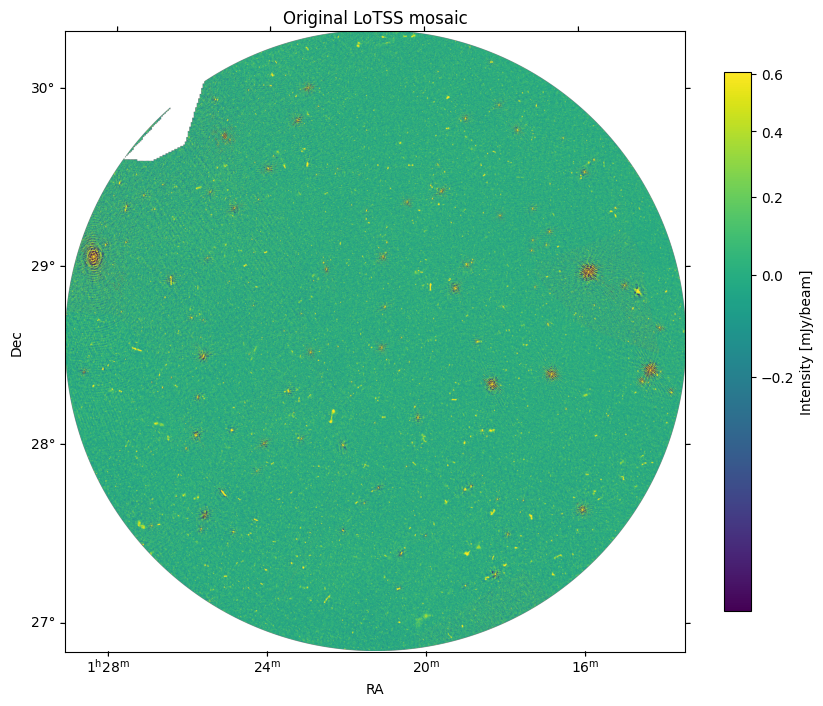

In [9]:
# Set up WCS plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
# Normalise the image
norm = ImageNormalize(data*1000, interval=ZScaleInterval(), stretch=SqrtStretch())
im = ax.imshow(data*1000, origin='lower', norm=norm)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title("Original LoTSS mosaic")
plt.colorbar(im, ax=ax, pad=0.05, shrink=0.7, aspect=20, label='Intensity [mJy/beam]')
output_mosaic = os.path.join(results_dir, 'SWF-010-T1_LoTSS_mosaic_radec.png')
plt.savefig(output_mosaic, dpi=300)
plt.show()

In [10]:
# Read catalogues that contain PyBDSF information

# Source catalogue (SRL)
srl_table = Table.read(outfile_srl)
srl_df = srl_table.to_pandas()
# Gaussian catalogue (GAUS)
gaus_table = Table.read(outfile_gaul)
gaus_df = gaus_table.to_pandas()

In [11]:
print("Columns in the source catalogue:", srl_df.columns.values)

Columns in the source catalogue: ['Source_id' 'Isl_id' 'RA' 'E_RA' 'DEC' 'E_DEC' 'Total_flux'
 'E_Total_flux' 'Peak_flux' 'E_Peak_flux' 'RA_max' 'E_RA_max' 'DEC_max'
 'E_DEC_max' 'Maj' 'E_Maj' 'Min' 'E_Min' 'PA' 'E_PA' 'Maj_img_plane'
 'E_Maj_img_plane' 'Min_img_plane' 'E_Min_img_plane' 'PA_img_plane'
 'E_PA_img_plane' 'DC_Maj' 'E_DC_Maj' 'DC_Min' 'E_DC_Min' 'DC_PA'
 'E_DC_PA' 'DC_Maj_img_plane' 'E_DC_Maj_img_plane' 'DC_Min_img_plane'
 'E_DC_Min_img_plane' 'DC_PA_img_plane' 'E_DC_PA_img_plane'
 'Isl_Total_flux' 'E_Isl_Total_flux' 'Isl_rms' 'Isl_mean' 'Resid_Isl_rms'
 'Resid_Isl_mean' 'S_Code']


In [ ]:
# Zoom in into a region and plot PyBDSF source and Gaussian positions and ellipses 

# --- CUTOUT SETUP ---
cutout_size = 512 #can define a wider area 

ny, nx = data.shape

# Can shift values (in pixels)
shift_x = -400   # positive = right, negative = left
shift_y = -1100  # positive = up, negative = down

# Calculate new central pixel with shift
yc = ny // 2 + shift_y
xc = nx // 2 + shift_x

half = cutout_size // 2
y1, y2 = yc - half, yc + half
x1, x2 = xc - half, xc + half

data_cut = data[y1:y2, x1:x2]
wcs_cut = wcs.slice((slice(y1, y2), slice(x1, x2)))

# --- RA/DEC BOUNDING BOX ---
cutout_corners = [(x1, y1), (x2, y2)]
cutout_world_coords = wcs.wcs_pix2world(cutout_corners, 0)
ra_min, dec_min = cutout_world_coords[0]
ra_max, dec_max = cutout_world_coords[1]

ra_low = min(ra_min, ra_max)
ra_high = max(ra_min, ra_max)
dec_low = min(dec_min, dec_max)
dec_high = max(dec_min, dec_max)

# --- FILTER CATALOGUESS ---
srl_cut = srl_df[
    (srl_df['RA'] >= ra_low) & (srl_df['RA'] <= ra_high) &
    (srl_df['DEC'] >= dec_low) & (srl_df['DEC'] <= dec_high)
]

gaus_cut = gaus_df[
    (gaus_df['RA'] >= ra_low) & (gaus_df['RA'] <= ra_high) &
    (gaus_df['DEC'] >= dec_low) & (gaus_df['DEC'] <= dec_high)
]

# --- PLOT ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': wcs_cut})

norm = ImageNormalize(data_cut*1000, interval=ZScaleInterval(), stretch=SqrtStretch())
im = ax.imshow(data_cut*1000, origin='lower', norm=norm)

ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title("Cutout of LoTSS mosaic with PyBDSF source and Gaussian positions and ellipses", pad=10)

# Add colorbar 
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, shrink=0.7, aspect=20)
cbar.set_label('Intensity [mJy/beam]')


# --- OVERLAY SOURCE POSITIONS & ELLIPSES ---
for _, row in srl_cut.iterrows():
    ra, dec = row['RA'], row['DEC']
    maj, min_, pa = row['Maj']*3600, row['Min']*3600, row['PA']

    # Convert RA/DEC to pixel coordinates
    x, y = wcs_cut.wcs_world2pix(ra, dec, 0)

    # Convert FWHM from arcsec → pixels
    arcsec_per_pixel = np.abs(header['CDELT1']) * 3600  # degrees → arcsec
    
    width = maj / arcsec_per_pixel
    height = min_ / arcsec_per_pixel
    #print(f"Maj={maj}, RA={ra}, Dec={dec}, width={width:.2f}, height={height:.2f}, PA={pa}")
    # Draw the ellipse
    ell = Ellipse((x, y), width=width, height=height, angle=pa,
                  edgecolor='red', facecolor='none', lw=1)
    ax.add_patch(ell)
    # mark the center
    ax.plot(x, y, 'rx', markersize=4, label='Sources')

# --- OVERLAY GAUSSIANS ---

for _, row in gaus_cut.iterrows():
    ra, dec = row['RA'], row['DEC']
    maj, min_, pa = row['Maj']*3600, row['Min']*3600, row['PA']
    x, y = wcs_cut.wcs_world2pix(ra, dec, 0)

    width = maj / arcsec_per_pixel
    height = min_ / arcsec_per_pixel

    ell = Ellipse((x, y), width=width, height=height, angle=pa,
                 edgecolor='blue', facecolor='none', lw=1)
    ax.plot(x, y, 'x', color ='blue',  markersize=4, label='Gaussians')
    ax.add_patch(ell)


legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Sources'),
    Line2D([0], [0], color='blue', lw=2, label='Gaussians')
]


ax.legend(handles=legend_elements, loc='upper right')
output_results = os.path.join(results_dir, 'SWF-010-T1_LoTSS_zoomed_in_validation_file.png')
plt.savefig(output_results, dpi=300)
plt.show()